<div style="width: 100%; clear: both;">
<div style="float: left; width: 50%;">
<img src="http://www.uoc.edu/portal/_resources/common/imatges/marca_UOC/UOC_Masterbrand.jpg", align="left">
</div>
<div style="float: right; width: 50%;">
<p style="margin: 0; padding-top: 22px; text-align:right;">M2.983 ¬∑ Aprenentatge per refor√ß</p>
<p style="margin: 0; text-align:right;">2024-1 ¬∑ M√†ster universitari en Ci√®ncia de dades (<i>Data science</i>)</p>
<p style="margin: 0; text-align:right; padding-bottom: 100px;">Estudis d'Inform√†tica, Multim√®dia i Telecomunicaci√≥</p>
<p style="margin: 0; text-align:right; padding-bottom: 100px;">Xavier Maltas Tarridas</p>
</div>
</div>
<div style="width:100%;">&nbsp;</div>

# PEC3: Deep Reinforcement Learning (II)

L'objectiu d'aquesta pr√†ctica √©s utilitzar la llibreria [stable baselines 3](https://stable-baselines3.readthedocs.io/en/master/), que ja te implementats algoritmes d'aprenentatge per refor√ß, per solucionar una versi√≥ modificada del cartpole, anomenada cartpole target. Els objectius d'aquesta pr√†ctica s√≥n:
<ol>
    <li>Desenvolupar una capacitat anal√≠tica sobre com est√† funcionant el model.</li>
    <li>Familiaritzar-se amb la llibreria stable baselines 3.</li>
    <li>Analitzar l'efecte de modificar la funci√≥ de recompensa durant l'entrenament de l'agent.</li>
    <li>Analitzar l'efecte de modificar l'espai d'accions.</li>
    <li>Ser capa√ßos de realitzar una cerca d'hiperpar√†metres.</li>
    <li>(Opcional) Familiaritzar-se amb l'an√†lisi mitjan√ßant tensorboard.</li>
</ol>

**Important: El lliurament s'ha de fer en format notebook i en format html on es vegi el codi i els resultats i comentaris de cada exercici. Per exportar el notebook a html es pot fer des del men√∫ File ‚Üí Download as ‚Üí HTML.**


# 0. Cartpole target (2 punts)

En aquesta pr√†ctica utilitzarem un entorn anomenat cartpole random target. Aquest entorn est√† fora de la llibreria gymnasium i √©s una modificaci√≥ de l'entorn [cartpole](https://gymnasium.farama.org/environments/classic_control/cart_pole/). En aquest entorn, l'objectiu no nom√©s √©s mantenir el pal estable, sin√≥ que el carro ha d'estar el m√©s a prop possible d'un punt objectiu, el qual es pot observar marcat en verd quan es renderitza l'entorn:

![image.png](image.png)

Hi ha alguns par√†metres en l'entorn que permeten regular com de rellevant volem que sigui el punt objectiu, fins al punt que podem aconseguir que aquesta modificaci√≥ es comporti com el cartpole original.


<div style="background-color: #EDF7FF; border-color: #7C9DBF; border-left: 5px solid #7C9DBF; padding: 0.5em;">
    <strong>Exercici 0.1 (0.75 punts):</strong> Llegeix el codi de l'entorn que es proporciona a continuaci√≥ detingudament. Ignoreu tots els TODOS, s√≥n coses que haurem d'implementar a mesura que la pr√†ctica avanci. Despr√©s, responeu les seg√ºents preguntes:
    <ul>
      <li>Quin √©s l'espai d'observacions? Com es distingeix respecte a la versi√≥ b√†sica de cartpole?</li>
      <li>Quines dues versions de la reward existeixen en l'entorn?</li>
      <li>Per al cas en que la reward √©s custom, qu√® fa el par√†metre target_desire_factor?</li>
    </ul>
</div>


In [37]:
"""
Classic cart-pole system implemented by Rich Sutton et al.
Copied from http://incompleteideas.net/sutton/book/code/pole.c
permalink: https://perma.cc/C9ZM-652R
"""

import math
from typing import Optional, Union

import numpy as np

import gymnasium as gym
from gymnasium import spaces
from gymnasium.envs.classic_control import utils
from gymnasium.error import DependencyNotInstalled



class CartPoleEnvRandomTarget(gym.Env[np.ndarray, Union[int, np.ndarray]]):
    """
    ## Description

    This environment corresponds to a modification of the version of the cart-pole problem described by Barto, Sutton, and Anderson in
    ["Neuronlike Adaptive Elements That Can Solve Difficult Learning Control Problem"](https://ieeexplore.ieee.org/document/6313077).
    A pole is attached by an un-actuated joint to a cart, which moves along a frictionless track.
    The pendulum is placed upright on the cart and the goal is to balance the pole by applying forces
     in the left and right direction on the cart.
     The modification consists on a target appearing into scene. The cart must be as close to the target as posible

    For more details about original cartpole look for source code in gymnasium.
    """


    metadata = {
        "render_modes": ["human", "rgb_array"],
        "render_fps": 50,
    }

    def __init__(
        self,
        target_desire_factor: float = 0.5,
        reward_function: str = "default",
        is_eval=False,
        increased_actions=False,
        render_mode: Optional[str] = None,
    ):

        self.gravity = 9.8
        self.masscart = 1.0
        self.masspole = 0.1
        self.total_mass = self.masspole + self.masscart
        self.length = 0.5  # actually half the pole's length
        self.polemass_length = self.masspole * self.length
        self.force_mag = 10.0
        self.tau = 0.02  # seconds between state updates

        self.max_steps = 500
        self.steps = 0

        # Angle at which to fail the episode
        self.theta_threshold_radians = 12 * 2 * math.pi / 360
        self.x_threshold = 2.4
        self.target_threshold = 2

        high = np.array(
            [
                self.x_threshold * 2,
                np.inf,
                self.theta_threshold_radians * 2,
                np.inf,
                self.target_threshold * 2,
            ],
            dtype=np.float32,
        )
        self.increased_actions = increased_actions
        if self.increased_actions:
            #TODO 3.1: Ampliar l'espai d'observacions
            raise NotImplementedError("Increased actions should be implemented")
        else:
            self.action_space = spaces.Discrete(2)
        self.observation_space = spaces.Box(-high, high, dtype=np.float32)

        self.render_mode = render_mode

        self.screen_width = 600
        self.screen_height = 400
        self.screen = None
        self.clock = None
        self.isopen = True
        self.state: np.ndarray | None = None

        self.steps_beyond_terminated = None

        #TODO 1.3: Tenir en compte si l'entorn √©s d'avaluaci√≥
        self.is_eval = is_eval
        self.target_position = self.generate_random_target_position()

        self.target_desire_factor = min(
            max(target_desire_factor, 0), 1
        )  # between 0 and 1
        if reward_function in ["default", "custom"]:
            self.reward_function = reward_function
        else:
            raise AttributeError("reward function must be either default or custom")

    def generate_random_target_position(
        self,
    ):
        if self.is_eval:
            #TODO 1.3:Tingueu en compte si l'entorn √©s d'avaluaci√≥ per situar el target en unes posicions concretes.
            raise NotImplementedError("You should implement is_eval casuistic")
            return target_position
        else:
            return np.random.uniform(-self.x_threshold, self.x_threshold)

    def custom_reward(self, target_position, current_position, angle, terminated):
        if self.reward_function == "default":
            #Reward default del cartpole
            return 1 if not terminated else 0
        else:
            angle_reward = (
                -abs(angle) / (2.0 * self.x_threshold) / self.theta_threshold_radians
            )
            target_reward = -(abs(target_position - current_position) ** 2) / (
                (2 * self.x_threshold) ** 2
            )
            return (
                1
                + self.target_desire_factor * target_reward
                + (1 - self.target_desire_factor) * angle_reward
            )
        #TODO 2.2: Implementar 2 funcions de reward extra

    def step(self, action):
        assert self.action_space.contains(
            action
        ), f"{action!r} ({type(action)}) invalid"
        assert self.state is not None, "Call reset before using step method."
        x, x_dot, theta, theta_dot, _ = self.state
        if self.increased_actions:
            force_factor = action - 3
            force = (
                force_factor / 3 * self.force_mag
                if force_factor > 0
                else (force_factor - 1) / 3 * self.force_mag
            )
        else:
            force = self.force_mag if action == 1 else -self.force_mag
        costheta = np.cos(theta)
        sintheta = np.sin(theta)

        # For the interested reader:
        # https://coneural.org/florian/papers/05_cart_pole.pdf
        temp = (
            force + self.polemass_length * np.square(theta_dot) * sintheta
        ) / self.total_mass
        thetaacc = (self.gravity * sintheta - costheta * temp) / (
            self.length
            * (4.0 / 3.0 - self.masspole * np.square(costheta) / self.total_mass)
        )
        xacc = temp - self.polemass_length * thetaacc * costheta / self.total_mass

        x = x + self.tau * x_dot
        x_dot = x_dot + self.tau * xacc
        theta = theta + self.tau * theta_dot
        theta_dot = theta_dot + self.tau * thetaacc

        self.state = np.array(
            (x, x_dot, theta, theta_dot, self.target_position), dtype=np.float64
        ) #Aquest estat es diferent respecte al del cartpole original

        terminated = bool(
            x < -self.x_threshold
            or x > self.x_threshold
            or theta < -self.theta_threshold_radians
            or theta > self.theta_threshold_radians
        )

        reward = self.custom_reward(self.target_position, x, theta, terminated)

        if self.render_mode == "human":
            self.render()

        # truncation=False as the time limit is handled by the `TimeLimit` wrapper added during `make`
        self.steps += 1
        if self.steps >= self.max_steps:
            truncated = True
        else:
            truncated = False
        return np.array(self.state, dtype=np.float32), reward, terminated, truncated, {}

    def reset(
        self,
        *,
        seed: Optional[int] = None,
        options: Optional[dict] = None,
    ):

        super().reset(seed=seed)
        self.steps = 0
        # Note that if you use custom reset bounds, it may lead to out-of-bound
        # state/observations.
        low, high = utils.maybe_parse_reset_bounds(
            options, -0.05, 0.05  # default low
        )  # default high

        self.state = self.np_random.uniform(low=low, high=high, size=(4,)).tolist()
        self.steps_beyond_terminated = None

        #Generar posici√≥ aleat√≤ria del target i guardar en l'estat
        self.target_position = self.generate_random_target_position()
        self.state.append(self.target_position)

        self.state = np.array(self.state)
        if self.render_mode == "human":
            self.render()
        return np.array(self.state, dtype=np.float32), {}

    def render(self):
        if self.render_mode is None:
            assert self.spec is not None
            gym.logger.warn(
                "You are calling render method without specifying any render mode. "
                "You can specify the render_mode at initialization, "
                f'e.g. gym.make("{self.spec.id}", render_mode="rgb_array")'
            )
            return

        try:
            import pygame
            from pygame import gfxdraw
        except ImportError as e:
            raise DependencyNotInstalled(
                'pygame is not installed, run `pip install "gymnasium[classic-control]"`'
            ) from e

        if self.screen is None:
            pygame.init()
            if self.render_mode == "human":
                pygame.display.init()
                self.screen = pygame.display.set_mode(
                    (self.screen_width, self.screen_height)
                )
            else:  # mode == "rgb_array"
                self.screen = pygame.Surface((self.screen_width, self.screen_height))
        if self.clock is None:
            self.clock = pygame.time.Clock()

        world_width = self.x_threshold * 2
        scale = self.screen_width / world_width
        polewidth = 10.0
        polelen = scale * (2 * self.length)
        cartwidth = 50.0
        cartheight = 30.0
        targetwidth = 10
        targetheight = 10

        if self.state is None:
            return None

        x = self.state

        self.surf = pygame.Surface((self.screen_width, self.screen_height))
        self.surf.fill((255, 255, 255))

        l, r, t, b = -cartwidth / 2, cartwidth / 2, cartheight / 2, -cartheight / 2
        axleoffset = cartheight / 4.0
        cartx = x[0] * scale + self.screen_width / 2.0  # MIDDLE OF CART
        carty = 100  # TOP OF CART
        cart_coords = [(l, b), (l, t), (r, t), (r, b)]
        cart_coords = [(c[0] + cartx, c[1] + carty) for c in cart_coords]
        gfxdraw.aapolygon(self.surf, cart_coords, (0, 0, 0))
        gfxdraw.filled_polygon(self.surf, cart_coords, (0, 0, 0))

        l, r, t, b = (
            -polewidth / 2,
            polewidth / 2,
            polelen - polewidth / 2,
            -polewidth / 2,
        )

        pole_coords = []
        for coord in [(l, b), (l, t), (r, t), (r, b)]:
            coord = pygame.math.Vector2(coord).rotate_rad(-x[2])
            coord = (coord[0] + cartx, coord[1] + carty + axleoffset)
            pole_coords.append(coord)
        gfxdraw.aapolygon(self.surf, pole_coords, (202, 152, 101))
        gfxdraw.filled_polygon(self.surf, pole_coords, (202, 152, 101))

        gfxdraw.aacircle(
            self.surf,
            int(cartx),
            int(carty + axleoffset),
            int(polewidth / 2),
            (129, 132, 203),
        )
        gfxdraw.filled_circle(
            self.surf,
            int(cartx),
            int(carty + axleoffset),
            int(polewidth / 2),
            (129, 132, 203),
        )

        l, r, t, b = (
            -targetwidth / 2,
            targetwidth / 2,
            targetheight / 2,
            -targetheight / 2,
        )
        axleoffset = targetheight / 4.0
        targetx = x[-1] * scale + self.screen_width / 2.0  # MIDDLE OF target
        targety = 90  # TOP OF target
        target_coords = [(l, b), (l, t), (r, t), (r, b)]
        target_coords = [(c[0] + targetx, c[1] + targety) for c in target_coords]
        gfxdraw.aapolygon(self.surf, target_coords, (10, 255, 10))
        gfxdraw.filled_polygon(self.surf, target_coords, (10, 255, 10))

        gfxdraw.hline(self.surf, 0, self.screen_width, carty, (0, 0, 0))

        self.surf = pygame.transform.flip(self.surf, False, True)
        self.screen.blit(self.surf, (0, 0))
        if self.render_mode == "human":
            pygame.event.pump()
            self.clock.tick(self.metadata["render_fps"])
            pygame.display.flip()

        elif self.render_mode == "rgb_array":
            return np.transpose(
                np.array(pygame.surfarray.pixels3d(self.screen)), axes=(1, 0, 2)
            )

    def close(self):
        if self.screen is not None:
            import pygame

            pygame.display.quit()
            pygame.quit()
            self.isopen = False


<div style="background-color: #fcf2f2; border-color: #dfb5b4; border-left: 5px solid #dfb5b4; padding: 0.5em;">
<strong>Comentari:</strong>
<br><br>
    
1.**Espai d'observacions**: 
   
L'espai d'observacions es tracta d'una caixa (Box) amb els l√≠mits seg√ºents:
    
* Posici√≥ del carro: entre -4.8 i 4.8.
* Velocitat del carro: entre -infinit i infinit.
* Angle del pal: entre -24¬∫ i 24¬∫ (radians).
* Velocitat angular del pal: entre -infinit i infinit.
* Posici√≥ del target: entre -4.8 i 4.8.
    
Definici√≥, creaci√≥ i assiganci√≥ dels l√≠mits de l'espai d'observaci√≥:
    
```
#Definition    
high = np.array(
    [
        self.x_threshold * 2,  # L√≠mit per la posici√≥ del carro
        np.inf,                # L√≠mit per la velocitat del carro
        self.theta_threshold_radians * 2,  # L√≠mit per l'angle del pal
        np.inf,                # L√≠mit per la velocitat angular del pal
        self.target_threshold * 2,  # L√≠mit per la posici√≥ del target
    ],
    dtype=np.float32,
)

#Creation
self.observation_space = spaces.Box(-high, high, dtype=np.float32)
    
#Assignment
self.state = np.array(
    (x, x_dot, theta, theta_dot, self.target_position), dtype=np.float64
)
    
```
    
Aquest espai d'observacions es distingeix de la versi√≥ b√†sica de 'cartpole' perqu√® inclou la posici√≥ del target com a una dimensi√≥ addicional. La versi√≥ original inclou 4 elements: posici√≥ del carro, velocitat del carro, angle del pal i velocitat del pal. 
    
2.**Reward**:
    
Hi ha dues versions de la funci√≥ de recompensa en aquest entorn:
    
* _Default_ : Recompensa similar a la de la versi√≥ b√†sica del 'cartpole'. La recompensa √©s 1 per a cada pas que el pal es mant√© dret i no ha acabat l'episodi.
    
```
if self.reward_function == "default":
    return 1 if not terminated else 0
```

* _Custom_ : La recompensa es calcula considerant la proximitat al target i l'angle del pal. Es calcula de la seg√ºent manera: 

```
angle_reward = (
    -abs(angle) / (2.0 * self.x_threshold) / self.theta_threshold_radians
)
target_reward = -(abs(target_position - current_position) ** 2) / (
    (2 * self.x_threshold) ** 2
)
return (
    1
    + self.target_desire_factor * target_reward
    + (1 - self.target_desire_factor) * angle_reward
)
```    
    
Quan ens trobem en el cas de la recompensa custom, el par√†metre 'target_desire_factor' determina el pes relatiu entre la proximitat al target i l'angle del pal. Un valor m√©s alt fa que la recompensa depengui m√©s de la proximitat al target, mentre que un valor m√©s baix fa que la recompensa depengui m√©s de l'angle del pal. 
  

</div>

<strong>IMPORTANT: PER ALS APARTATS 1 I 2 FAREM SERVIR LA REWARD DEFAULT.</strong> Aix√≤ implica que el nostre entorn ser√† el mateix que el del cartpole cl√†ssic sense target.

<div style="background-color: #EDF7FF; border-color: #7C9DBF; border-left: 5px solid #7C9DBF; padding: 0.5em;">
    <strong>Exercici 0.2 (0.75 punts):</strong> Executa l'entorn cartpole target utilitzant una policy random. Desa les observacions en una llista i posteriorment crea una funci√≥ per analitzar els resultats on es vegi:
    <ul>
    <li>Un scatter plot dels angles del pal aix√≠ com la posici√≥ relativa del carro respecte al target. Heu de marcar el punt inicial i final. De manera opcional, podeu marcar cada punt de forma diferent segons l'acci√≥ presa (empujar a l'esquerra o a la dreta). Per exemple, una creu si es prem a la dreta i un cercle si es fa cap a l'esquerra).</li>
    <li>L'evoluci√≥ de la reward.</li>
    <li>Imprimir el n√∫mero de steps realitzats.</li>
    </ul>
Comenta els resultats trobats.

<strong>NOTA: Per poder veure com l'agent va movent el Pal de manera interactiva, podeu utilitzar render_mode = 'human'. Aix√≤ NO s'ha de fer quan s'entrenin els models, ja que seran molt lents d'entrenar.
    
No √©s obligatori utilitzar render_mode = 'human' per a les avaluacions, per√≤ pot ser interessant. En cas de voler-ho fer, recordeu que cal executar-ho localment.</strong>
</div>



In [38]:
import gymnasium as gym
import time

In [39]:
#TODO: Completar codi
env = CartPoleEnvRandomTarget(render_mode='human',reward_function = 'default')

#Init variables
observations = []
current_step = [] #temporary storage
rewards = []
actions = []
steps = 0

#Reset env
state, _ = env.reset()
done = False

while not done:
    #random action
    action = env.action_space.sample() 
    actions.append(action) #save action

    #Info before step
    print(f"Step: {steps}, Action: {action}, State: {state}")

    #execute action
    next_state, reward, terminated, truncated, _ = env.step(action)

    #Status after step
    print(f"Next State: {next_state}, Reward: {reward}, Terminated: {terminated}, Truncated: {truncated}\n")

    current_step.append((state,action)) #save temporary state-action pair
    rewards.append(reward)#save reward
    
    #Check episode end
    if terminated or truncated:
        print("Episode ended.")
        done = True
        observations.append(current_step)
        break
        
    steps += 1 #increase steps
    state = next_state #next state to current state for next step

#Close env
env.close()

#Print steps
print(f"Number of steps taken: {steps}")

# # Print the values of observations and rewards
# print("\nObservations:")
# for episode in observations:
#     for step in episode:
#         print(step)

# print("\nRewards:")
# print(rewards)

# Convertim les observacions a un format numpy per facilitar l'an√†lisi
observations = np.array(observations, dtype=object) 
rewards = np.array(rewards)

Step: 0, Action: 0, State: [ 0.02330831  0.03441427 -0.01754698 -0.01561026  0.29285192]
Next State: [ 0.0239966  -0.1604517  -0.01785918  0.27148515  0.29285192], Reward: 1, Terminated: False, Truncated: False

Step: 1, Action: 1, State: [ 0.0239966  -0.1604517  -0.01785918  0.27148515  0.29285192]
Next State: [ 0.02078756  0.03492048 -0.01242948 -0.02677671  0.29285192], Reward: 1, Terminated: False, Truncated: False

Step: 2, Action: 0, State: [ 0.02078756  0.03492048 -0.01242948 -0.02677671  0.29285192]
Next State: [ 0.02148597 -0.16002104 -0.01296501  0.2619588   0.29285192], Reward: 1, Terminated: False, Truncated: False

Step: 3, Action: 1, State: [ 0.02148597 -0.16002104 -0.01296501  0.2619588   0.29285192]
Next State: [ 0.01828555  0.03528356 -0.00772584 -0.03478507  0.29285192], Reward: 1, Terminated: False, Truncated: False

Step: 4, Action: 1, State: [ 0.01828555  0.03528356 -0.00772584 -0.03478507  0.29285192]
Next State: [ 0.01899122  0.23051545 -0.00842154 -0.32989553  0

In [40]:
import numpy as np
import matplotlib.pylab as plt
X_THRESHOLD = env.unwrapped.x_threshold*1.25 #Limit de posicio del carro
ANGLE_THRESHOLD = env.unwrapped.theta_threshold_radians*1.25 #Limit de l'angle del pal
def analyze_results(observations, rewards):
    for step_idx, step in enumerate(observations):
        #Extract positions, angles and actions
        positions = [obs[0][0] for obs in step] #relative position to the target
        angles = [obs[0][2] for obs in step] #pole angles
        actions = [obs[1] for obs in step] #actions

        #Scatter plot
        plt.figure(figsize=(10, 6))
        for pos, angle, action in zip(positions, angles, actions):
            marker = 'x' if action == 1 else 'o'  #X right | O left
            plt.scatter(pos, angle, c='blue', marker=marker, alpha=0.7)

        #Highlight start and end points
        plt.scatter(positions[0], angles[0], c='green', label='Start', s=100) #start piont
        plt.scatter(positions[-1], angles[-1], c='red', label='End', s=100) #end point

        # Customize plot
        plt.xlabel('Position relative to target')
        plt.ylabel('Pole angle (radians)')
        plt.title(f'Distance-Angle Trajectory (Step {step_idx + 1})')
        plt.ylim(-ANGLE_THRESHOLD, ANGLE_THRESHOLD)
        plt.xlim(-X_THRESHOLD, X_THRESHOLD)
        plt.axhline(0, color='gray', linestyle='--', linewidth=0.7)
        plt.axvline(0, color='gray', linestyle='--', linewidth=0.7)
        plt.legend()
        plt.grid(alpha=0.3)
        plt.show()

    #Reward evolution plot
    cumulative_rewards = np.cumsum(rewards) #cumulative reward
    
    #lines
    plt.figure(figsize=(10, 6))
    plt.plot(range(len(rewards)), rewards, marker='o', linestyle='-', color='orange', alpha=0.8, label='Step Reward')
    plt.plot(range(len(cumulative_rewards)), cumulative_rewards, marker='s', linestyle='--', color='blue', alpha=0.8, label='Cumulative Reward')
    #annotations
    plt.text(len(rewards) - 1, rewards[-1] + 0.1, 'Step Reward', color='orange', fontsize=10)
    plt.text(len(cumulative_rewards) - 1, cumulative_rewards[-1] + 0.1, 'Cumulative Reward', color='blue', fontsize=10)
    
    plt.xlabel('Step')
    plt.ylabel('Reward')
    plt.title('Reward Evolution')
    plt.grid(alpha=0.3)
    plt.show()

    #print steps
    print(f'Number of steps taken: {steps}')

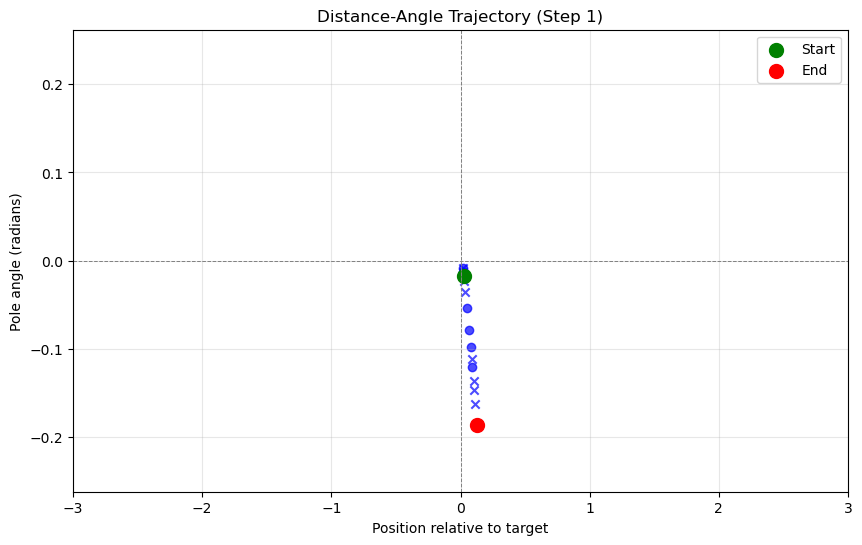

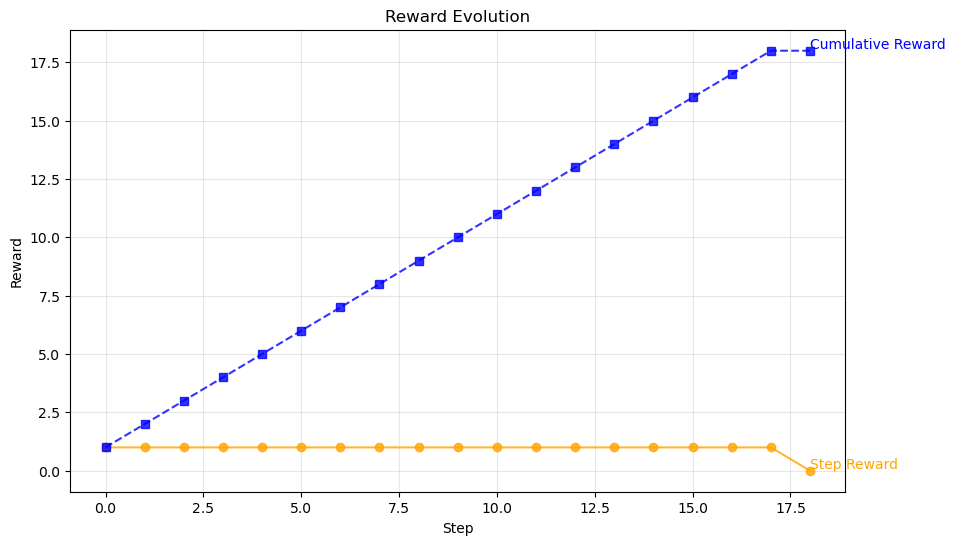

Number of steps taken: 18


In [41]:
# TODO: passar inputs necessaris
analyze_results(observations, rewards)

<div style="background-color: #fcf2f2; border-color: #dfb5b4; border-left: 5px solid #dfb5b4; padding: 0.5em;">
<strong>Comentari:</strong>
<br><br>
    
#### Distance - Angle plot 

Pel fa a la posici√≥ respecte a l'objectiu, la traject√≤ria es mant√© a prop del x=0. Aix√≤ indica que el carro s'ha mantingut gaireb√© centrat en relaci√≥ amb l'objectiu, suggerint un control estable sobre el moviment del carro. L'angle del pole oscil¬∑la lleugerament per sobre i sota ùúÉ = 0 (posici√≥ vertical), per√≤ dins d'un rang petit. El sistema mant√© el pal prop de la vertical durant els passos. Respecte a les accions realitzades (x -> emp√®nyer carro dreta, o -> emp√®nyer carro esquerra), veiem que l'agent alterna entre empentar esquerra i dreta de manera alterna per mantenir l'estabilitat.

#### Reward plot

La recompensa del pas es mant√© constant en 1 per a tots els passos, cosa que demostra que l'agent mant√© constantment un entorn estable (ni falla ni es desvia massa). Pel que a la recompensa acumulada, aquesta augmenta linealment amb el nombre de passos, reflectint l'acumulaci√≥ consistent de recompensa de passos. Aix√≤ indica que l'episodi avan√ßa sense finalitzar, mantenint el sistema de cart-pole equilibrat per a tots els passos observats.
</div>

<div style="background-color: #EDF7FF; border-color: #7C9DBF; border-left: 5px solid #7C9DBF; padding: 0.5em;">
    <strong>Exercici 0.3 (0.5 punts):</strong> Respecte al gr√†fic realitzat a l'apartat anterior, quina seria la traject√≤ria que realitzaria un agent que es comport√©s de manera √≤ptima?
</div>

<div style="background-color: #fcf2f2; border-color: #dfb5b4; border-left: 5px solid #dfb5b4; padding: 0.5em;">
<strong>Comentari:</strong>
<br><br>
    
Un agent √≤ptim que mantingu√©s el control perfecte del sistema CartPole hauria de presentar les seg√ºents caracter√≠stiques: 

1.**Posici√≥ relativa al target (eix x)**: 
    Mantenir la posici√≥ del carro molt pr√≤xima a 0, √©s a dir, el centre del l√≠mit de posici√≥.

2.**Angle del pal (eix y)**:
    L'angle del pal ha d'estar molt pr√≤xim a 0 radians (completament vertical). Realitzar microajustaments per assegurar que el pal no oscil¬∑li gaire, mantenint l'equilibri de forma cont√≠nua.

3.**Accions**:
    L'agent √≤ptim ha de realitzar un nombre m√≠nim d'accions per mantenir el sistema estable.

4.**Punts inicial i final**:
    Tant el punt inicial com el punt final haurien de ser molt pr√≤xims o id√®ntics a x=0 i ùúÉ=0. La traject√≤ria √≤ptima mostraria gaireb√© una l√≠nia recta o un punt fix.

</div>

# 1. Stable baselines 3 (2 pts)


<div style="background-color: #EDF7FF; border-color: #7C9DBF; border-left: 5px solid #7C9DBF; padding: 0.5em;">
    Comencem a entrenar un model per solucionar l'entorn. Recordeu que per als apartats 1 i 2 utilitzarem la reward default.
    Per solucionar l'entorn, utilitzarem el model A2C de la llibreria stable baselines.
</div>


In [42]:
from stable_baselines3 import A2C
from stable_baselines3.common.evaluation import evaluate_policy
from stable_baselines3.common.callbacks import EvalCallback
STEPS = 20_000
EVAL_FREQ = 2000
EVAL_EPISODES = 5

<div style="background-color: #EDF7FF; border-color: #7C9DBF; border-left: 5px solid #7C9DBF; padding: 0.5em;">
    <strong>Exercici 1.1 (0.25 punts):</strong> Entrena un model A2C amb par√†metres default i utilitzant una MlpPolicy per entrenar un agent que solucioni el cartpole amb reward default.
    Afegeix un callback per avaluar el model 5 vegades cada 2 mil iteracions.
    A m√©s, fes que cada vegada que es trobi un model millor, es guardi el model. Inicialment, abans de comen√ßar l'entrenament, utilitza la funci√≥ evaluate_policy per avaluar el model sense entrenar. Utilitza tamb√© la funci√≥ evaluate_policy just abans d'entrenar el model per tenir una idea de com funciona el model abans de ser entrenat.
</div>


Opcional: Per a aquells que vulgueu aprofundir una mica m√©s en l'assignatura, tamb√© existeix una eina anomenada TensorBoard, molt √∫til per analitzar el proc√©s d'entrenament de qualsevol xarxa neuronal en general. Stable Baselines 3 t√© automatitzada la captura de logs amb TensorBoard. Per fer-ho, nom√©s cal que passeu al constructor del model el par√†metre tensorboard_log=path on vulgueu guardar el log. Podeu utilitzar aquests logs per veure no nom√©s les rewards d'evaluaci√≥, sin√≥ tamb√© per veure els gradients, la loss i altres par√†metres durant l'entrenament.

Podeu utilitzar-lo en aquest apartat i en tots els que vulgueu durant la pr√†ctica. No puntu√Øar√† ni es tindr√† en compte, per√≤ permet con√®ixer m√©s en detall com s'est√† entrenant el model.

In [43]:
env = CartPoleEnvRandomTarget(render_mode=None, reward_function = 'default')

#best model save path
model_save_path = "./best_a2c_model"

#carregar callback
#callback = 
callback = EvalCallback(
    env,  # Environment for evaluation
    best_model_save_path=model_save_path,  # Directory to save the best model
    log_path=model_save_path,  # Log directory
    eval_freq=EVAL_FREQ,  # Evaluate the model every EVAL_FREQ steps
    n_eval_episodes=EVAL_EPISODES,  # Number of episodes for each evaluation
    deterministic=True,  # Use deterministic actions for evaluation
    render=False  # Don't render during evaluation
)

#carregar model
model = A2C('MlpPolicy', env, verbose=1)

#avaluaci√≥ inicial
#initial_eval = 
initial_eval = evaluate_policy(model, env, n_eval_episodes=EVAL_EPISODES, deterministic=True)
print(f"Initial evaluation before training: Mean reward = {initial_eval[0]:.2f}, Std reward = {initial_eval[1]:.2f}")

#TODO: entrenar model
model.learn(total_timesteps=STEPS, callback=callback)

Using cpu device
Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.
Initial evaluation before training: Mean reward = 8.60, Std reward = 0.49
------------------------------------
| rollout/              |          |
|    ep_len_mean        | 20.4     |
|    ep_rew_mean        | 19.4     |
| time/                 |          |
|    fps                | 796      |
|    iterations         | 100      |
|    time_elapsed       | 0        |
|    total_timesteps    | 500      |
| train/                |          |
|    entropy_loss       | -0.686   |
|    explained_variance | -0.627   |
|    learning_rate      | 0.0007   |
|    n_updates          | 99       |
|    policy_loss        | 2.33     |
|    value_loss         | 12.9     |
------------------------------------
------------------------------------
| rollout/              |          |
|    ep_len_mean        | 21.8     |
|    ep_rew_mean        | 20.8     |
| time/                 |          |
|    fps          

---------------------------------
| rollout/           |          |
|    ep_len_mean     | 54.8     |
|    ep_rew_mean     | 53.8     |
| time/              |          |
|    fps             | 687      |
|    iterations      | 1200     |
|    time_elapsed    | 8        |
|    total_timesteps | 6000     |
---------------------------------
-------------------------------------
| rollout/              |           |
|    ep_len_mean        | 58.4      |
|    ep_rew_mean        | 57.4      |
| time/                 |           |
|    fps                | 693       |
|    iterations         | 1300      |
|    time_elapsed       | 9         |
|    total_timesteps    | 6500      |
| train/                |           |
|    entropy_loss       | -0.511    |
|    explained_variance | -0.000445 |
|    learning_rate      | 0.0007    |
|    n_updates          | 1299      |
|    policy_loss        | 0.776     |
|    value_loss         | 1.91      |
-------------------------------------
--------------

---------------------------------
| rollout/           |          |
|    ep_len_mean     | 103      |
|    ep_rew_mean     | 102      |
| time/              |          |
|    fps             | 663      |
|    iterations      | 2400     |
|    time_elapsed    | 18       |
|    total_timesteps | 12000    |
---------------------------------
------------------------------------
| rollout/              |          |
|    ep_len_mean        | 107      |
|    ep_rew_mean        | 106      |
| time/                 |          |
|    fps                | 667      |
|    iterations         | 2500     |
|    time_elapsed       | 18       |
|    total_timesteps    | 12500    |
| train/                |          |
|    entropy_loss       | -0.485   |
|    explained_variance | -0.00614 |
|    learning_rate      | 0.0007   |
|    n_updates          | 2499     |
|    policy_loss        | 0.00223  |
|    value_loss         | 2.54e-05 |
------------------------------------
-------------------------------

---------------------------------
| rollout/           |          |
|    ep_len_mean     | 141      |
|    ep_rew_mean     | 140      |
| time/              |          |
|    fps             | 667      |
|    iterations      | 3600     |
|    time_elapsed    | 26       |
|    total_timesteps | 18000    |
---------------------------------
------------------------------------
| rollout/              |          |
|    ep_len_mean        | 142      |
|    ep_rew_mean        | 141      |
| time/                 |          |
|    fps                | 670      |
|    iterations         | 3700     |
|    time_elapsed       | 27       |
|    total_timesteps    | 18500    |
| train/                |          |
|    entropy_loss       | -0.45    |
|    explained_variance | -0.0147  |
|    learning_rate      | 0.0007   |
|    n_updates          | 3699     |
|    policy_loss        | 0.00101  |
|    value_loss         | 2.23e-05 |
------------------------------------
-------------------------------

<div style="background-color: #EDF7FF; border-color: #7C9DBF; border-left: 5px solid #7C9DBF; padding: 0.5em;">
    <strong>Exercici 1.2 (0.25 punts):</strong> Carrega el millor model trobat i executa la funci√≥ evaluate_policy. Compara les rewards inicials i finals.
    Executa un episodi i analitza els resultats utilitzant la funci√≥ pr√®viament creada per visualitzar el comportament de l'agent en l'espai d'angle-posici√≥.
</div>


In [44]:
import os
#best model path
best_model_path = "./best_a2c_model/best_model.zip"

#carregar el millor model
if os.path.exists(best_model_path):
    model = A2C.load(best_model_path)
    print("El millor model ha estat carregat correctament.")
else:
    raise FileNotFoundError(f"No s'ha trobat el model a {best_model_path}")

#avaluaci√≥ final
final_eval = final_eval = evaluate_policy(model, env, n_eval_episodes=EVAL_EPISODES, deterministic=True)
print (f'Initial evaluation: {initial_eval}')
print (f'Best model evaluation: {final_eval}')
print(f"Recompensa final mitjana: {final_eval[0]:.2f} +/- {final_eval[1]:.2f}")

El millor model ha estat carregat correctament.
Initial evaluation: (8.6, 0.48989794855663565)
Best model evaluation: (500.0, 0.0)
Recompensa final mitjana: 500.00 +/- 0.00


In [45]:
#TODO: Completar funcio d'avaluaci√≥ del model entrenat
def evaluate_trained_model(env,model):
    #Primer executem un cop l'entorn
    obs,_ = env.reset()
    done = False
    
    #Init variables
    observations = []
    rewards = []
    step = []

    while not done:
        # TODO: Escollir accio en base al model
        action, _ = model.predict(obs, deterministic=True)

        # TODO: Executar accio i esperar resposta de l'entorn
        next_obs, reward, terminated, truncated, _ = env.step(action)

        # TODO: Guardar informacio necesaria per a poder fer les grafiques despres
        step.append((obs, action))
        rewards.append(reward)
        
        #update state and check end
        obs = next_obs
        done = terminated or truncated
        
    observations.append(step)

    #Analitzem resultats
    analyze_results(observations,rewards)
    print(f"Total Reward: {sum(rewards)}")

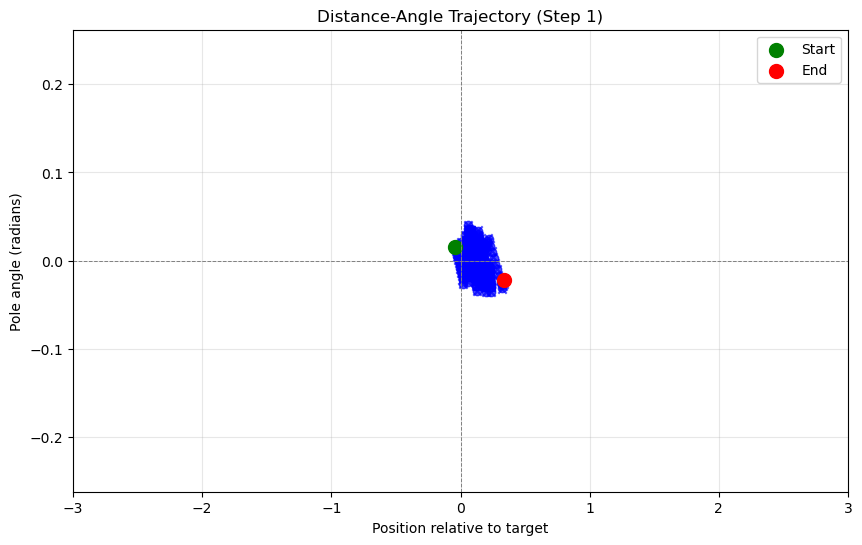

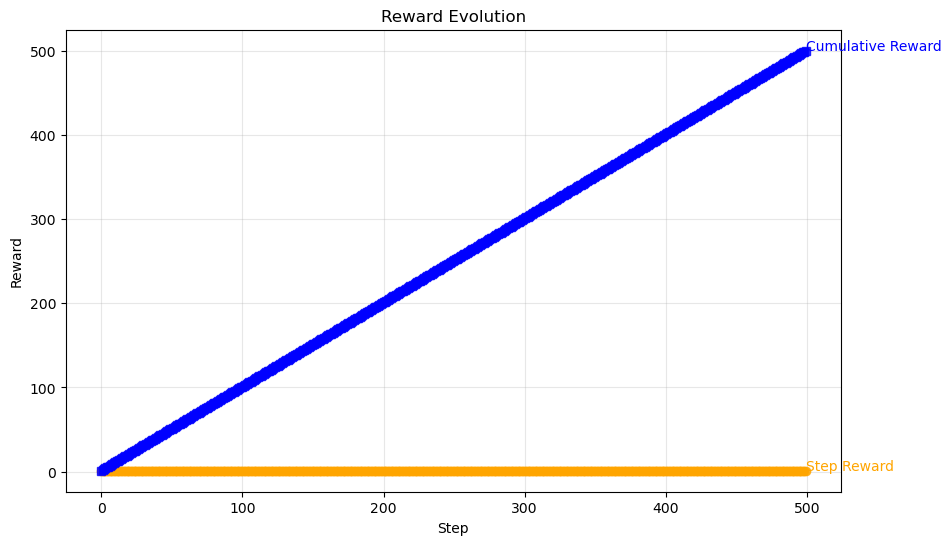

Number of steps taken: 18
Total Reward: 500


In [46]:
env = CartPoleEnvRandomTarget(render_mode='human',reward_function = 'default') #podeis hacer render mode = None
evaluate_trained_model(env,model)

env.close()

<div style="background-color: #fcf2f2; border-color: #dfb5b4; border-left: 5px solid #dfb5b4; padding: 0.5em;">
<strong>Comentari:</strong>
<br><br>
    
#### Distance - Angle plot 
La traject√≤ria mostra que el pal s'ha mogut amb una oscil¬∑laci√≥ redu√Øda al voltant del centre (target), mantenint l'angle sota control durant tot el temps. L'agent ha sigut capa√ß de mantenir el balan√ß i controlar la posici√≥ del carro. Tot i aix√≤, les oscil¬∑lacions s√≥n visibles i indiquen que l'agent ho ha trobat una traject√≤ria √≤ptima completament estable. 

#### Reward plot
    
La recompensa acumulativa mostra una l√≠nia amb una pujada constant, suggerint que l'agent acumula punts a cada pas sense fallar durant els episodis. 


    
    
Com a conclusions finals podem dir que l'agent ha tingut un control efectiu amb algunes oscil¬∑lacions en la traject√≤ria de posici√≥ i angle que mostren que hi ha marge de millora, per√≤ amb un bon rendiment general. 
</div>

<div style="background-color: #EDF7FF; border-color: #7C9DBF; border-left: 5px solid #7C9DBF; padding: 0.5em;">
    <strong>Exercici 1.3 (0.5 punts):</strong> Un dels problemes que tenim amb aquest entorn √©s que estem avaluant el model sobre un entorn random. Aix√≤ genera que durant el callback puguem guardar un model no perqu√® sigui millor que els anteriors, sin√≥ perqu√® els entorns sobre els quals s'ha avaluat s√≥n m√©s senzills. Per exemple, si en un dels callbacks el target es situa als extrems, tot i que l'agent es comporti millor que les seves versions anteriors, potser no ho sabrem perqu√® la reward total ser√† m√©s petita que, per exemple, una versi√≥ amb un comportament pitjor, per√≤ en qu√® el target s'ha situat al centre.
    Modifica l'entorn de cartpole (veure TODOS dins del codi) perqu√® en avaluaci√≥ el target es trobi en 9 posicions diferents:
    <ul>
    <li> Als extrems</li>
    <li> A 3/4, 1/2 i 1/4 de la dist√†ncia entre el centre i els extrems</li>
    <li> Just al centre</li>
    </ul>
    Setejarem a partir d'ara el n√∫mero d'episodis d'avaluaci√≥ a 18 (EVAL_EPISODES) perqu√® s'executi 2 vegades cada casu√≠stica.
</div>


In [47]:
"""
Classic cart-pole system implemented by Rich Sutton et al.
Copied from http://incompleteideas.net/sutton/book/code/pole.c
permalink: https://perma.cc/C9ZM-652R
"""

import math
from typing import Optional, Union

import numpy as np

import gymnasium as gym
from gymnasium import spaces
from gymnasium.envs.classic_control import utils
from gymnasium.error import DependencyNotInstalled



class CartPoleEnvRandomTarget(gym.Env[np.ndarray, Union[int, np.ndarray]]):
    """
    ## Description

    This environment corresponds to a modification of the version of the cart-pole problem described by Barto, Sutton, and Anderson in
    ["Neuronlike Adaptive Elements That Can Solve Difficult Learning Control Problem"](https://ieeexplore.ieee.org/document/6313077).
    A pole is attached by an un-actuated joint to a cart, which moves along a frictionless track.
    The pendulum is placed upright on the cart and the goal is to balance the pole by applying forces
     in the left and right direction on the cart.
     The modification consists on a target appearing into scene. The cart must be as close to the target as posible

    For more details about original cartpole look for source code in gymnasium.
    """


    metadata = {
        "render_modes": ["human", "rgb_array"],
        "render_fps": 50,
    }

    def __init__(
        self,
        target_desire_factor: float = 0.5,
        reward_function: str = "default",
        is_eval=False,
        increased_actions=False,
        render_mode: Optional[str] = None,
    ):

        self.gravity = 9.8
        self.masscart = 1.0
        self.masspole = 0.1
        self.total_mass = self.masspole + self.masscart
        self.length = 0.5  # actually half the pole's length
        self.polemass_length = self.masspole * self.length
        self.force_mag = 10.0
        self.tau = 0.02  # seconds between state updates

        self.max_steps = 500
        self.steps = 0

        # Angle at which to fail the episode
        self.theta_threshold_radians = 12 * 2 * math.pi / 360
        self.x_threshold = 2.4
        self.target_threshold = 2

        high = np.array(
            [
                self.x_threshold * 2,
                np.inf,
                self.theta_threshold_radians * 2,
                np.inf,
                self.target_threshold * 2,
            ],
            dtype=np.float32,
        )
        self.increased_actions = increased_actions
        if self.increased_actions:
            #TODO 3.1: Ampliar l'espai d'observacions
            raise NotImplementedError("Increased actions should be implemented")
        else:
            self.action_space = spaces.Discrete(2)
        self.observation_space = spaces.Box(-high, high, dtype=np.float32)

        self.render_mode = render_mode

        self.screen_width = 600
        self.screen_height = 400
        self.screen = None
        self.clock = None
        self.isopen = True
        self.state: np.ndarray | None = None

        self.steps_beyond_terminated = None

        #TODO 1.3: Tenir en compte si l'entorn √©s d'avaluaci√≥
        self.is_eval = is_eval
        self.target_position_index = None #index to control target position
        self.target_position = self.generate_random_target_position()

        self.target_desire_factor = min(
            max(target_desire_factor, 0), 1
        )  # between 0 and 1
        if reward_function in ["default", "custom"]:
            self.reward_function = reward_function
        else:
            raise AttributeError("reward function must be either default or custom")

    def generate_random_target_position(
        self,
    ):
        if self.is_eval:
            #TODO 1.3:Tingueu en compte si l'entorn √©s d'avaluaci√≥ per situar el target en unes posicions concretes.
            #preset target positions for evaluation mode
            eval_positions = [
                -self.x_threshold,                      # Extrem esquerre
                -self.x_threshold * 0.75,               # 3/4 esquerre
                -self.x_threshold * 0.5,                # 1/2 esquerre
                -self.x_threshold * 0.25,               # 1/4 esquerre
                0.0,                                    # Centre
                self.x_threshold * 0.25,                # 1/4 dret
                self.x_threshold * 0.5,                 # 1/2 dret
                self.x_threshold * 0.75,                # 3/4 dret
                self.x_threshold                        # Extrem dret
            ]
            #select a random position (first execution)
            if self.target_position_index is None:
                self.target_position_index = np.random.randint(0,9)

            #select the target position based on the index
            target_position = eval_positions[self.target_position_index]

            #update the index
            self.target_position_index = (self.target_position_index + 1) % 9
            
            return target_position
        else:
            return np.random.uniform(-self.x_threshold, self.x_threshold)

    def custom_reward(self, target_position, current_position, angle, terminated):
        if self.reward_function == "default":
            #Reward default del cartpole
            return 1 if not terminated else 0
        else:
            angle_reward = (
                -abs(angle) / (2.0 * self.x_threshold) / self.theta_threshold_radians
            )
            target_reward = -(abs(target_position - current_position) ** 2) / (
                (2 * self.x_threshold) ** 2
            )
            return (
                1
                + self.target_desire_factor * target_reward
                + (1 - self.target_desire_factor) * angle_reward
            )
        #TODO 2.2: Implementar 2 funcions de reward extra

    def step(self, action):
        assert self.action_space.contains(
            action
        ), f"{action!r} ({type(action)}) invalid"
        assert self.state is not None, "Call reset before using step method."
        x, x_dot, theta, theta_dot, _ = self.state
        if self.increased_actions:
            force_factor = action - 3
            force = (
                force_factor / 3 * self.force_mag
                if force_factor > 0
                else (force_factor - 1) / 3 * self.force_mag
            )
        else:
            force = self.force_mag if action == 1 else -self.force_mag
        costheta = np.cos(theta)
        sintheta = np.sin(theta)

        # For the interested reader:
        # https://coneural.org/florian/papers/05_cart_pole.pdf
        temp = (
            force + self.polemass_length * np.square(theta_dot) * sintheta
        ) / self.total_mass
        thetaacc = (self.gravity * sintheta - costheta * temp) / (
            self.length
            * (4.0 / 3.0 - self.masspole * np.square(costheta) / self.total_mass)
        )
        xacc = temp - self.polemass_length * thetaacc * costheta / self.total_mass

        x = x + self.tau * x_dot
        x_dot = x_dot + self.tau * xacc
        theta = theta + self.tau * theta_dot
        theta_dot = theta_dot + self.tau * thetaacc

        self.state = np.array(
            (x, x_dot, theta, theta_dot, self.target_position), dtype=np.float64
        ) #Aquest estat es diferent respecte al del cartpole original

        terminated = bool(
            x < -self.x_threshold
            or x > self.x_threshold
            or theta < -self.theta_threshold_radians
            or theta > self.theta_threshold_radians
        )

        reward = self.custom_reward(self.target_position, x, theta, terminated)

        if self.render_mode == "human":
            self.render()

        # truncation=False as the time limit is handled by the `TimeLimit` wrapper added during `make`
        self.steps += 1
        if self.steps >= self.max_steps:
            truncated = True
        else:
            truncated = False
        return np.array(self.state, dtype=np.float32), reward, terminated, truncated, {}

    def reset(
        self,
        *,
        seed: Optional[int] = None,
        options: Optional[dict] = None,
    ):

        super().reset(seed=seed)
        self.steps = 0
        # Note that if you use custom reset bounds, it may lead to out-of-bound
        # state/observations.
        low, high = utils.maybe_parse_reset_bounds(
            options, -0.05, 0.05  # default low
        )  # default high

        self.state = self.np_random.uniform(low=low, high=high, size=(4,)).tolist()
        self.steps_beyond_terminated = None

        #Generar posici√≥ aleat√≤ria del target i guardar en l'estat
        self.target_position = self.generate_random_target_position()
        self.state.append(self.target_position)

        self.state = np.array(self.state)
        if self.render_mode == "human":
            self.render()
        return np.array(self.state, dtype=np.float32), {}

    def render(self):
        if self.render_mode is None:
            assert self.spec is not None
            gym.logger.warn(
                "You are calling render method without specifying any render mode. "
                "You can specify the render_mode at initialization, "
                f'e.g. gym.make("{self.spec.id}", render_mode="rgb_array")'
            )
            return

        try:
            import pygame
            from pygame import gfxdraw
        except ImportError as e:
            raise DependencyNotInstalled(
                'pygame is not installed, run `pip install "gymnasium[classic-control]"`'
            ) from e

        if self.screen is None:
            pygame.init()
            if self.render_mode == "human":
                pygame.display.init()
                self.screen = pygame.display.set_mode(
                    (self.screen_width, self.screen_height)
                )
            else:  # mode == "rgb_array"
                self.screen = pygame.Surface((self.screen_width, self.screen_height))
        if self.clock is None:
            self.clock = pygame.time.Clock()

        world_width = self.x_threshold * 2
        scale = self.screen_width / world_width
        polewidth = 10.0
        polelen = scale * (2 * self.length)
        cartwidth = 50.0
        cartheight = 30.0
        targetwidth = 10
        targetheight = 10

        if self.state is None:
            return None

        x = self.state

        self.surf = pygame.Surface((self.screen_width, self.screen_height))
        self.surf.fill((255, 255, 255))

        l, r, t, b = -cartwidth / 2, cartwidth / 2, cartheight / 2, -cartheight / 2
        axleoffset = cartheight / 4.0
        cartx = x[0] * scale + self.screen_width / 2.0  # MIDDLE OF CART
        carty = 100  # TOP OF CART
        cart_coords = [(l, b), (l, t), (r, t), (r, b)]
        cart_coords = [(c[0] + cartx, c[1] + carty) for c in cart_coords]
        gfxdraw.aapolygon(self.surf, cart_coords, (0, 0, 0))
        gfxdraw.filled_polygon(self.surf, cart_coords, (0, 0, 0))

        l, r, t, b = (
            -polewidth / 2,
            polewidth / 2,
            polelen - polewidth / 2,
            -polewidth / 2,
        )

        pole_coords = []
        for coord in [(l, b), (l, t), (r, t), (r, b)]:
            coord = pygame.math.Vector2(coord).rotate_rad(-x[2])
            coord = (coord[0] + cartx, coord[1] + carty + axleoffset)
            pole_coords.append(coord)
        gfxdraw.aapolygon(self.surf, pole_coords, (202, 152, 101))
        gfxdraw.filled_polygon(self.surf, pole_coords, (202, 152, 101))

        gfxdraw.aacircle(
            self.surf,
            int(cartx),
            int(carty + axleoffset),
            int(polewidth / 2),
            (129, 132, 203),
        )
        gfxdraw.filled_circle(
            self.surf,
            int(cartx),
            int(carty + axleoffset),
            int(polewidth / 2),
            (129, 132, 203),
        )

        l, r, t, b = (
            -targetwidth / 2,
            targetwidth / 2,
            targetheight / 2,
            -targetheight / 2,
        )
        axleoffset = targetheight / 4.0
        targetx = x[-1] * scale + self.screen_width / 2.0  # MIDDLE OF target
        targety = 90  # TOP OF target
        target_coords = [(l, b), (l, t), (r, t), (r, b)]
        target_coords = [(c[0] + targetx, c[1] + targety) for c in target_coords]
        gfxdraw.aapolygon(self.surf, target_coords, (10, 255, 10))
        gfxdraw.filled_polygon(self.surf, target_coords, (10, 255, 10))

        gfxdraw.hline(self.surf, 0, self.screen_width, carty, (0, 0, 0))

        self.surf = pygame.transform.flip(self.surf, False, True)
        self.screen.blit(self.surf, (0, 0))
        if self.render_mode == "human":
            pygame.event.pump()
            self.clock.tick(self.metadata["render_fps"])
            pygame.display.flip()

        elif self.render_mode == "rgb_array":
            return np.transpose(
                np.array(pygame.surfarray.pixels3d(self.screen)), axes=(1, 0, 2)
            )

    def close(self):
        if self.screen is not None:
            import pygame

            pygame.display.quit()
            pygame.quit()
            self.isopen = False


<div style="background-color: #EDF7FF; border-color: #7C9DBF; border-left: 5px solid #7C9DBF; padding: 0.5em;">
    <strong>Exercici 1.4.1 (0.5 punts):</strong> Modifica la funci√≥ analyze_results perqu√® cre√Ø els mateixos gr√†fics que es generaven abans per√≤ per a cada casu√≠stica. Suposa que a la funci√≥ li arribaran 9 episodis diferents, 1 per a cada casu√≠stica. Podeu utilitzar subplots de matplotlib. Us hauria de quedar alguna cosa aix√≠:
</div>


![image-3.png](exemple_sortida.png)

<div style="background-color: #EDF7FF; border-color: #7C9DBF; border-left: 5px solid #7C9DBF; padding: 0.5em;">
    <strong>Exercici 1.4.2 (0.5 punts):</strong> Repeteix els exercicis 1.1 i 1.2 per√≤ avaluant amb un entorn d'avaluaci√≥ i utilitzant la nova funci√≥ d'avaluaci√≥. Recorda que tot i que els EVAL_EPISODES s√≥n 18, per avaluar l'agent i fer els gr√†fics executarem 1 vegada cada casu√≠stica, fent un total de 9 execucions.
</div>


In [48]:
import gymnasium as gym
from stable_baselines3 import PPO
from stable_baselines3.common.callbacks import EvalCallback
from stable_baselines3.common.env_util import DummyVecEnv

#Modificar primer els TODOS de l'entorn
EVAL_EPISODES = 18
STEPS = 20000
EVAL_FREQ = 2000
env = CartPoleEnvRandomTarget(render_mode=None,reward_function = 'default')
eval_env = CartPoleEnvRandomTarget(render_mode=None,reward_function = 'default',is_eval = True)

#TODO: Completar codi
#Creem callback i model. Per al callback farem servir l'entorn d'evaluacio, per al model el normal
callback = EvalCallback(
    eval_env=DummyVecEnv([lambda: eval_env]),  # Vectoritzar l'entorn d'avaluaci√≥
    best_model_save_path="./best_model/",
    log_path="./logs/",
    eval_freq=EVAL_FREQ,  # Freq√º√®ncia d'avaluaci√≥
    n_eval_episodes=EVAL_EPISODES,  # Episodis d'avaluaci√≥
    deterministic=True,
    render=False
)

model = PPO(
    "MlpPolicy",  # Pol√≠tica basada en xarxes neuronals
    env,
    verbose=1,
    tensorboard_log="./tensorboard/"
)

#Executem evaluacio inicial
initial_eval = evaluate_policy(
    model,
    DummyVecEnv([lambda: eval_env]),
    n_eval_episodes=9,  # Un episodi per a cada casu√≠stica
    return_episode_rewards=True  # Retornar els resultats per episodi
)
print(f"Initial evaluation: {initial_eval}")

#Entrenem model
model.learn(total_timesteps=STEPS, callback=callback)

#Carreguem millor model i executem validaci√≥ final
best_model_path = "./best_model/best_model.zip"
if os.path.exists(best_model_path):
    model = PPO.load(best_model_path)
    print("El millor model ha estat carregat correctament.")
else:
    raise FileNotFoundError(f"No s'ha trobat el model a {best_model_path}")

final_eval = evaluate_policy(
    model,
    DummyVecEnv([lambda: eval_env]),
    n_eval_episodes=9,  # Un episodi per a cada casu√≠stica
    return_episode_rewards=True
)
# print (f'Initial evaluation: {initial_eval}')
print (f'Best model evaluation: {final_eval}')

Using cpu device
Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.
Initial evaluation: ([9.0, 8.0, 9.0, 9.0, 9.0, 8.0, 9.0, 8.0, 8.0], [10, 9, 10, 10, 10, 9, 10, 9, 9])
Logging to ./tensorboard/PPO_15
Eval num_timesteps=2000, episode_reward=8.44 +/- 0.68
Episode length: 9.44 +/- 0.68
---------------------------------
| eval/              |          |
|    mean_ep_length  | 9.44     |
|    mean_reward     | 8.44     |
| time/              |          |
|    total_timesteps | 2000     |
---------------------------------
New best mean reward!
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 21.8     |
|    ep_rew_mean     | 20.8     |
| time/              |          |
|    fps             | 1536     |
|    iterations      | 1        |
|    time_elapsed    | 1        |
|    total_timesteps | 2048     |
---------------------------------
Eval num_timesteps=4000, episode_reward=161.17 +/- 111.54
Episode length: 162.17 +/- 111

---------------------------------
| rollout/           |          |
|    ep_len_mean     | 107      |
|    ep_rew_mean     | 106      |
| time/              |          |
|    fps             | 496      |
|    iterations      | 8        |
|    time_elapsed    | 33       |
|    total_timesteps | 16384    |
---------------------------------
Eval num_timesteps=18000, episode_reward=285.33 +/- 100.15
Episode length: 286.22 +/- 99.91
------------------------------------------
| eval/                   |              |
|    mean_ep_length       | 286          |
|    mean_reward          | 285          |
| time/                   |              |
|    total_timesteps      | 18000        |
| train/                  |              |
|    approx_kl            | 0.0043039303 |
|    clip_fraction        | 0.0194       |
|    clip_range           | 0.2          |
|    entropy_loss         | -0.584       |
|    explained_variance   | 0.716        |
|    learning_rate        | 0.0003       |
|    loss

In [49]:
def analyze_results(observations, rewards):
    """
    Genera subplots per cada casu√≠stica:
    - Gr√†fiques de traject√≤ries "dist√†ncia-angle"
    - Gr√†fiques de recompenses per cada pas
    """
    n_cases = len(observations)
    fig, axes = plt.subplots(3, 5, figsize=(20, 12))  # Subplots de 3 files i 5 columnes
    axes = axes.flatten()  # Aplanem per facilitar l'iteraci√≥

    for case_idx in range(n_cases):
        obs_case = observations[case_idx]
        rewards_case = rewards[case_idx]

        # Dades d'observacions i accions
        positions = [obs[0][0] for obs in obs_case]  # Posicions relatives al target
        angles = [obs[0][2] for obs in obs_case]  # Angles del pal
        actions = [obs[1] for obs in obs_case]  # Accions

        # Gr√†fic de traject√≤ria posici√≥-angle
        ax = axes[case_idx]
        ax.plot(positions, angles, label="Traject√≤ria", color='blue', alpha=0.8)
        ax.scatter(positions[0], angles[0], label="Inicial", color='green', s=50)
        ax.scatter(positions[-1], angles[-1], label="Final", color='red', s=50)

        ax.set_title(f"Casu√≠stica {case_idx + 1} (Recompensa acumulada: {sum(rewards_case)})")
        ax.set_xlabel("Dist√†ncia al target")
        ax.set_ylabel("Angle del pal (rad)")
        ax.legend()
        ax.grid(alpha=0.3)

    # Omplir subplots sobrants (si n_cases < 15)
    for empty_ax in axes[n_cases:]:
        empty_ax.axis('off')

    plt.tight_layout()
    plt.show()

    # Gr√†fiques de recompenses per pas
    fig, reward_axes = plt.subplots(3, 5, figsize=(20, 12))
    reward_axes = reward_axes.flatten()

    for case_idx in range(n_cases):
        rewards_case = rewards[case_idx]

        # Gr√†fic de recompenses per pas
        reward_ax = reward_axes[case_idx]
        reward_ax.plot(range(len(rewards_case)), rewards_case, label="Recompenses per pas", color='blue')
        reward_ax.set_title(f"Casu√≠stica {case_idx + 1} (Recompensa acumulada: {sum(rewards_case)})")
        reward_ax.set_xlabel("Step")
        reward_ax.set_ylabel("Recompensa")
        reward_ax.grid(alpha=0.3)

    # Omplir subplots sobrants (si n_cases < 15)
    for empty_ax in reward_axes[n_cases:]:
        empty_ax.axis('off')

    plt.tight_layout()
    plt.show()


In [50]:
from tqdm import tqdm

def evaluate_trained_model(env, model):
    """
    Avaluem un model entrenat per 9 casu√≠stiques i generem gr√†fiques.
    """
    n_eval_cases = 9
    observations = []  # Guardar les observacions (traject√≤ries)
    rewards = []  # Guardar les recompenses per cada casu√≠stica

    # Executem una iteraci√≥ per casu√≠stica
    for _ in tqdm(range(n_eval_cases), desc="Avaluant casu√≠stiques"):
        done = False
        episode_obs = []
        episode_rewards = []

        obs, _ = env.reset()
        while not done:
            action, _states = model.predict(obs, deterministic=True)  # Acci√≥ del model entrenat
            next_obs, reward, done, _, _ = env.step(action)  # Pas de simulaci√≥

            # Guardem observacions, accions i recompenses
            episode_obs.append((obs, action))
            episode_rewards.append(reward)
            obs = next_obs

        # Guardem traject√≤ria i recompenses d'aquest cas
        observations.append(episode_obs)
        rewards.append(episode_rewards)

    # Generem gr√†fiques amb la funci√≥ `analyze_results`
    analyze_results(observations, rewards)

Avaluant casu√≠stiques: 100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 9/9 [00:02<00:00,  3.75it/s]


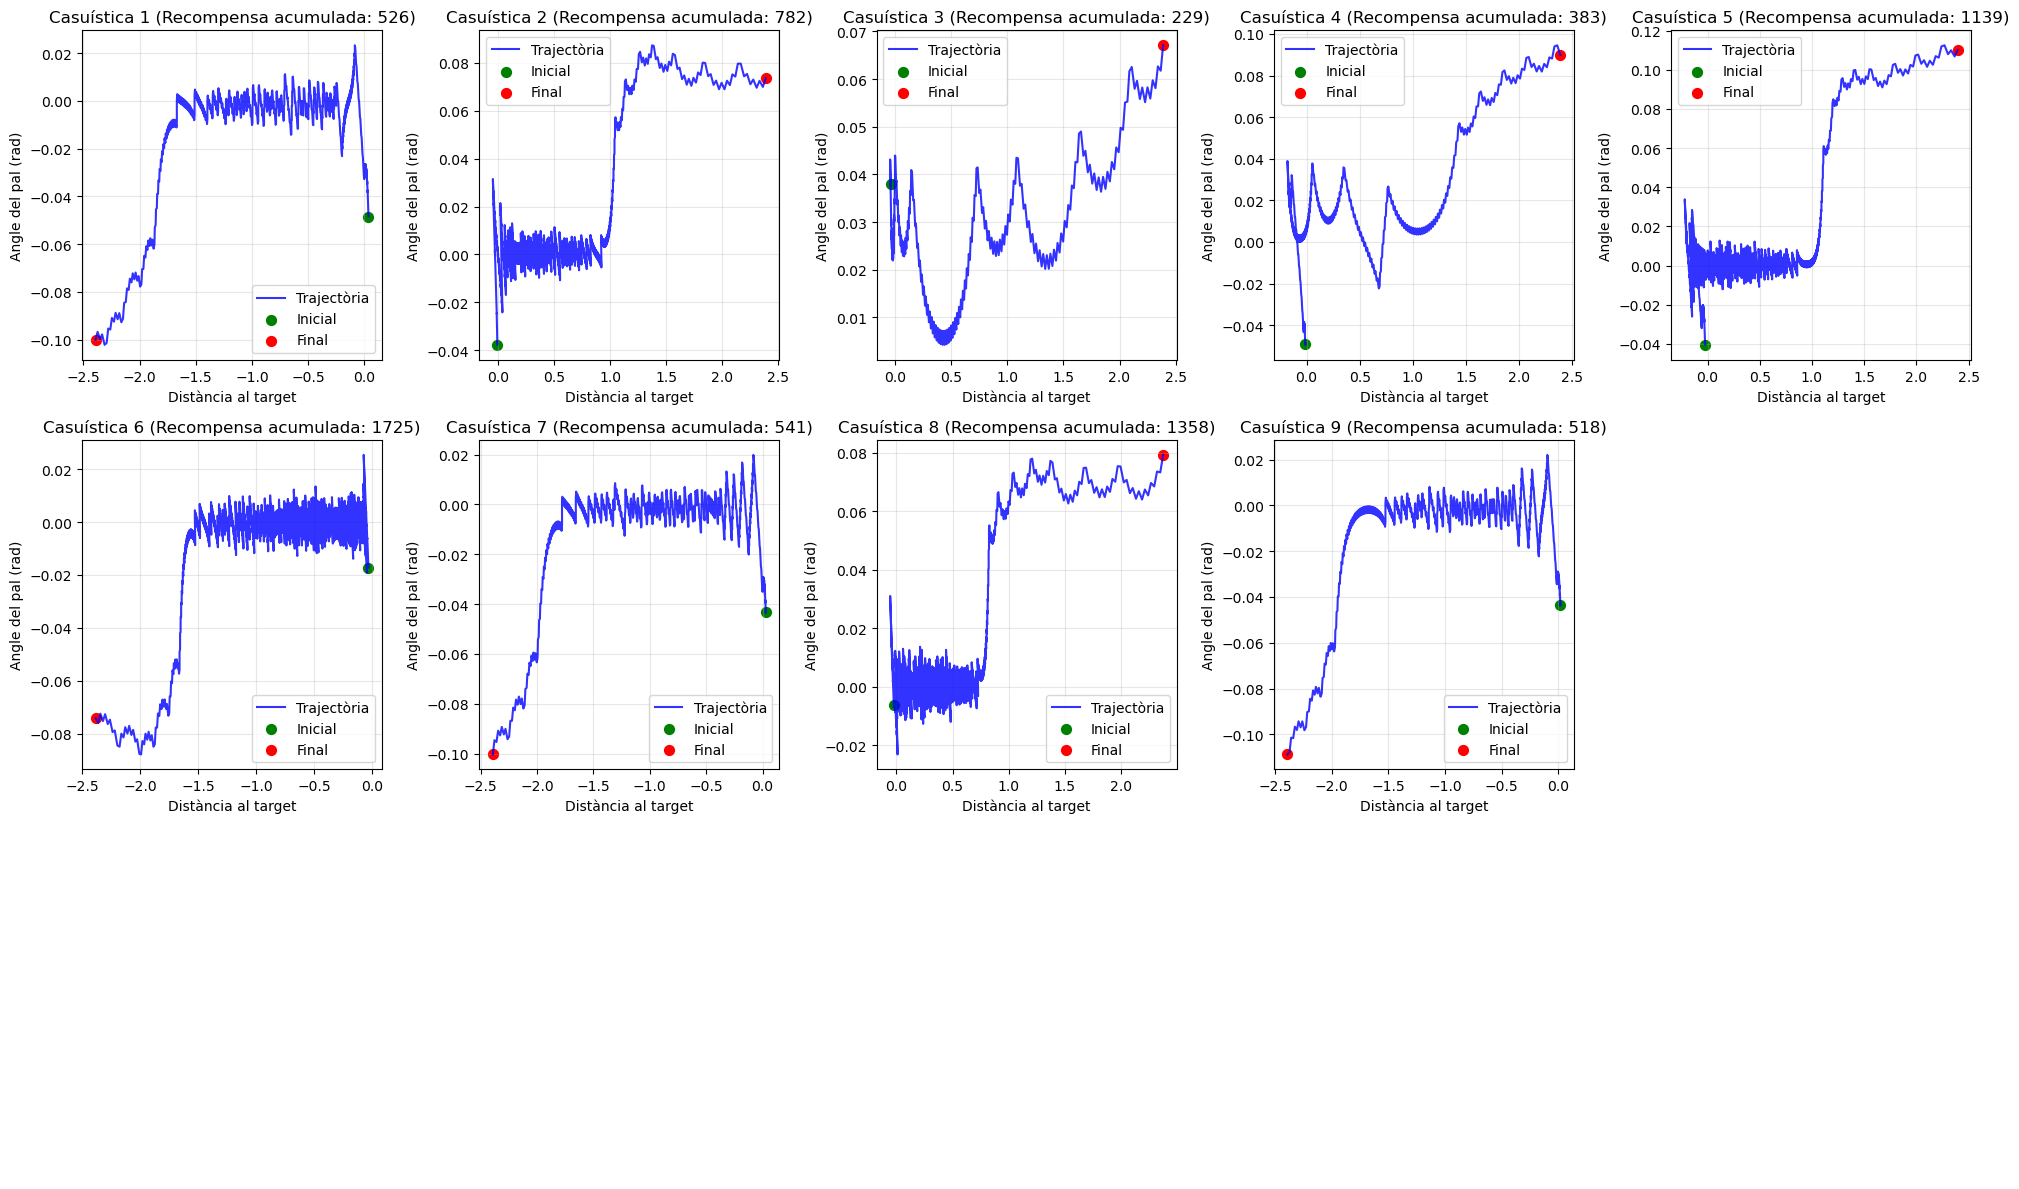

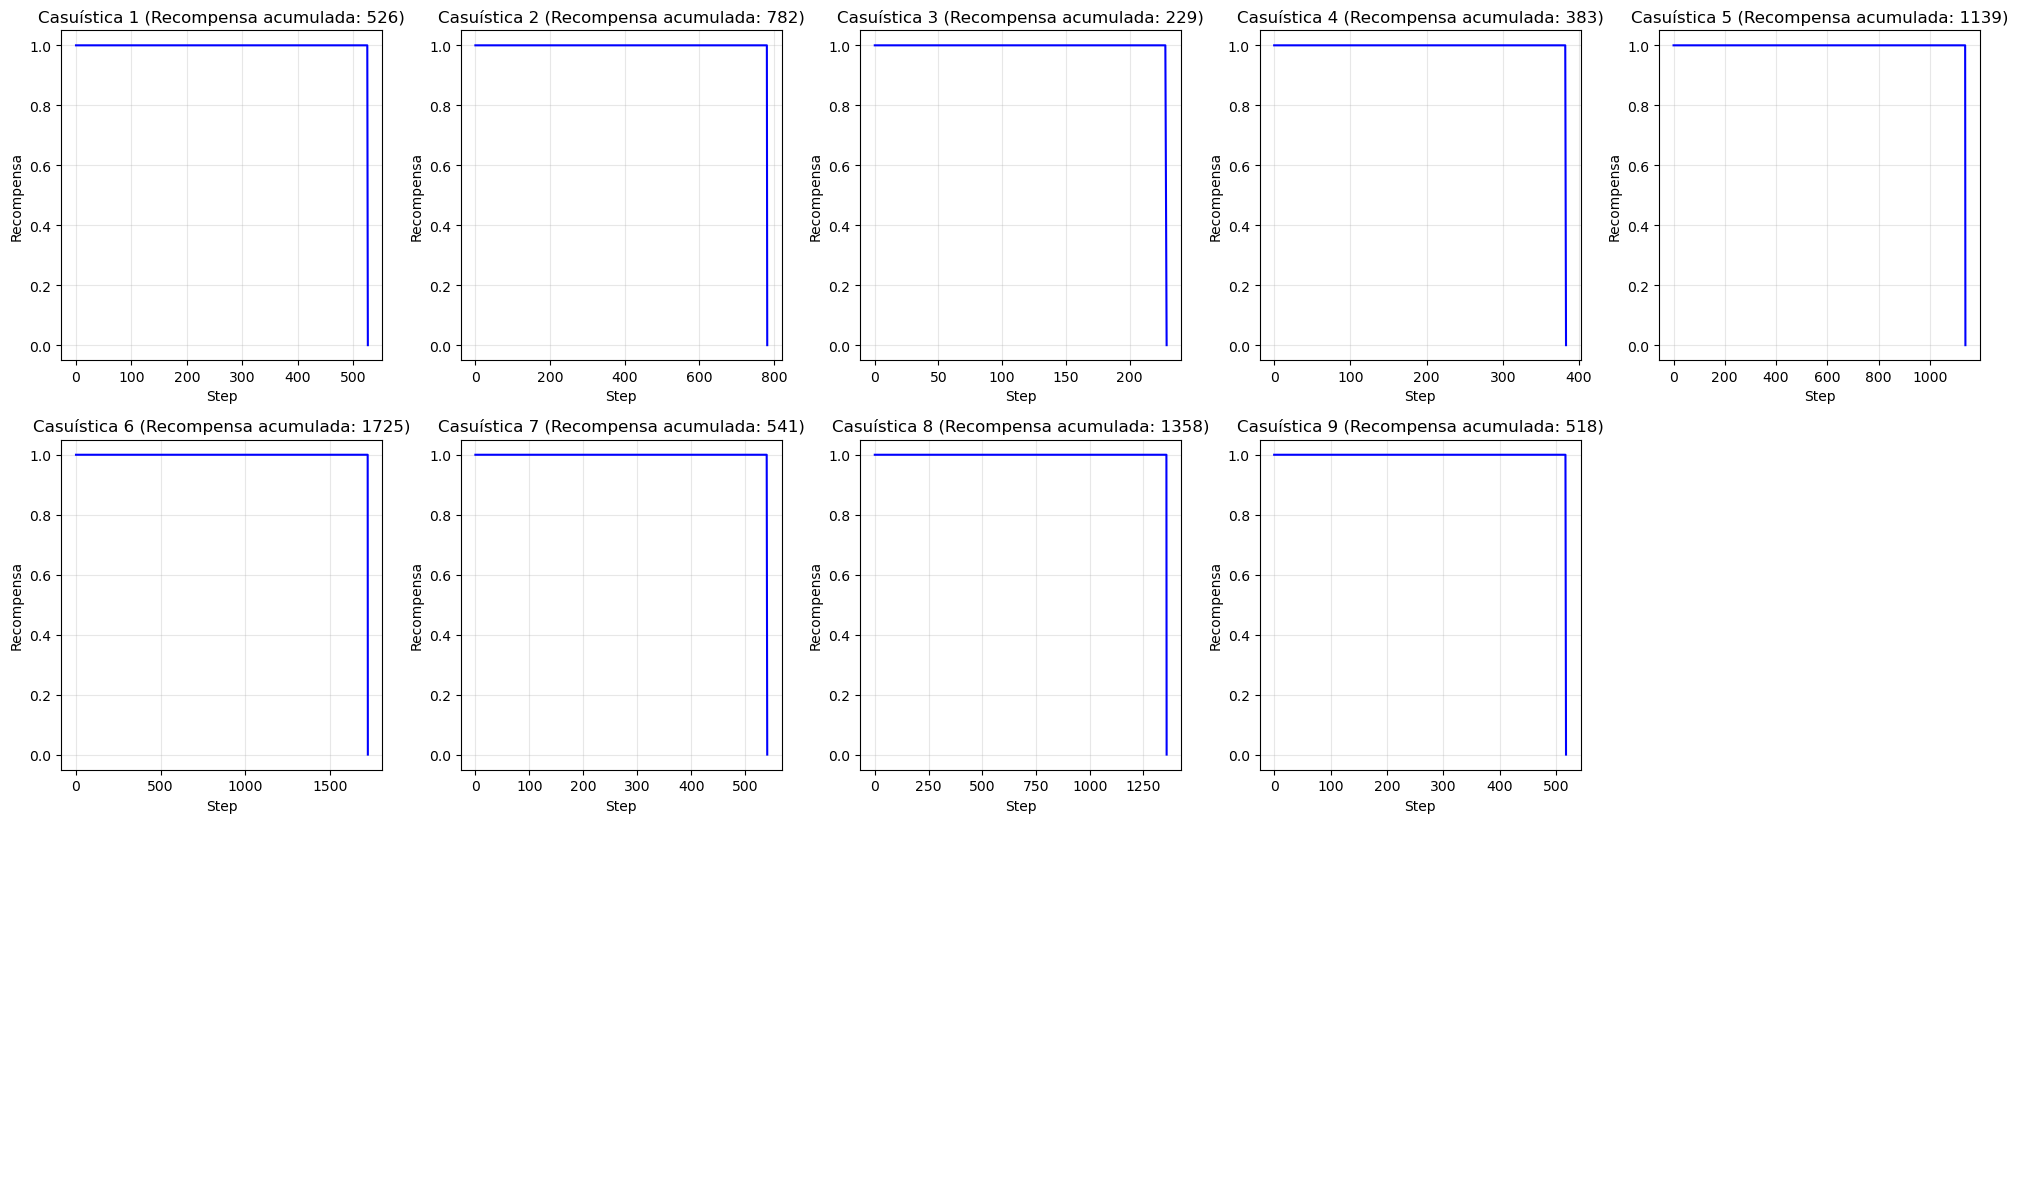

In [51]:
#Executem la funcio
eval_env = CartPoleEnvRandomTarget(render_mode='human',reward_function = 'default',is_eval = True) #podeis modificar el render mode a None
eval_env = CartPoleEnvRandomTarget(render_mode='None',reward_function = 'default',is_eval = True)
evaluate_trained_model(eval_env,model)

eval_env.close()

<div style="background-color: #fcf2f2; border-color: #dfb5b4; border-left: 5px solid #dfb5b4; padding: 0.5em;">
<strong>Comentari:</strong>
<br><br>
    
#### Distance - Angle plot 
Les traject√≤ries de les diferents gr√†fiques mostren de forma recorrent un patr√≥ on les oscil¬∑lacions al inici s√≥n molt reduides i suaus, i que seguidament, comen√ßen a apareixer moviments un pel m√©s bruscos (m√©s llargs). Aquests en part sembla que aturen la intensitat, per√≤ s√≥n l'inici de la perdua del control i posterior finalitzaci√≥ de l'episodi.  

#### Reward plot
    
El reward en cada un dels gr√†fics de recompensa sembla indicar que la finalitzaci√≥ de l'episodi √©s causat per un factor trucated. Ho podem deduir donat que en tots ells tenim un punt on la recompensa passa a tenir un valor de 0 i l'episodi no continua. 
</div>

# 2. Efecte del reward (3 pts)

<div style="background-color: #EDF7FF; border-color: #7C9DBF; border-left: 5px solid #7C9DBF; padding: 0.5em;">
    <strong>Exercici 2.1 (1.25 punts):</strong> Entrena un agent utilitzant diferents valors del par√†metre target_desire_factor:
    <ul>
        <li>target_desire_factor=0</li>
        <li>target_desire_factor=0.5</li>
        <li>target_desire_factor=1</li>
    </ul>

Executa un episodi amb el millor agent (recorda utilitzar els callbacks) i comenta els resultats obtinguts.
</div>


In [52]:
#TODO: Repetir el mateix que en els exercicis anteriors. Callback, model, avaluaci√≥ inicial, c√†rrega del millor model i entrenament.
#Al final, analitzar els resultats utilitzant la funci√≥ evaluate_trained_model.
#Repetir per a cada valor de target_desire_factor.

target_desire_factors = [0, 0.5, 1]
STEPS = 20000
EVAL_FREQ = 2000

# Funci√≥ per entrenar l'agent per un valor de target_desire_factor
def train_agent(target_desire_factor):
    # Creem l'entorn d'entrenament i avaluaci√≥ amb el valor actual de target_desire_factor
    env = CartPoleEnvRandomTarget(render_mode=None, reward_function='custom', target_desire_factor=target_desire_factor)
    eval_env = CartPoleEnvRandomTarget(render_mode=None, reward_function='custom', target_desire_factor=target_desire_factor, is_eval=True)

    # Modl
    model = PPO("MlpPolicy", env, verbose=1)
    
    # Avaluaci√≥ inicial abans de l'entrenament
    print(f"Evaluaci√≥ inicial per target_desire_factor = {target_desire_factor}:")
    initial_eval = evaluate_trained_model(model, eval_env)  # Avaluem el model sense entrenar
    print(f"Initial evaluation: {initial_eval}")

    # Iniciem l'entrenament
    print(f"Iniciant l'entrenament per target_desire_factor = {target_desire_factor}...")
    
    # Callback per a l'avaluaci√≥ durant l'entrenament
    eval_callback = EvalCallback(
        DummyVecEnv([lambda: eval_env]),  # Creem l'entorn vectoritzat dins del callback
        best_model_save_path=f"./best_model_{target_desire_factor}", 
        log_path=f"./logs_{target_desire_factor}", 
        eval_freq=EVAL_FREQ,
        verbose=1
    )

    # Entrenem el model
    model.learn(total_timesteps=STEPS, callback=eval_callback)

    # Carreguem el millor model
    model = PPO.load(f"./best_model_{target_desire_factor}/best_model.zip")
    
    return model, eval_env
    
# Funci√≥ per avaluar el model entrenat
def evaluate_trained_model(model, eval_env):
    total_reward = 0
    total_steps = 0
    for _ in range(10):  # Evaluem durant 10 episodis
        obs, _ = eval_env.reset()  # Ens assegurem d'obeir nom√©s l'observaci√≥
        done = False
        episode_reward = 0
        steps = 0
        while not done:
            action, _ = model.predict(obs)
            result = eval_env.step(action)
            # Desempaquetem els primers 4 elements
            obs, reward, done, _ = result[:4]
            episode_reward += reward
            steps += 1
        total_reward += episode_reward
        total_steps += steps
    
    average_reward = total_reward / 10
    average_steps = total_steps / 10
    return average_reward, average_steps

# Funci√≥ per avaluar els tres models
def evaluate_all_models(models, eval_envs):
    for target_desire_factor, (model, eval_env) in zip(target_desire_factors, zip(models, eval_envs)):
        print(f"\nAvaluant el millor model per target_desire_factor = {target_desire_factor}:")
        average_reward, average_steps = evaluate_trained_model(model, eval_env)
        print(f"Recompensa mitjana: {average_reward}, Passos mitjans per episodi: {average_steps}")

# Entrenament dels tres models
models = []
eval_envs = []
for target_desire_factor in target_desire_factors:
    print(f"\n{'-'*50}")
    print(f"Entrenament amb target_desire_factor = {target_desire_factor}")
    model, eval_env = train_agent(target_desire_factor)
    models.append(model)
    eval_envs.append(eval_env)
    print(f"\n{'-'*50}")

# Avaluem els tres models
evaluate_all_models(models, eval_envs)



--------------------------------------------------
Entrenament amb target_desire_factor = 0
Using cpu device
Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.
Evaluaci√≥ inicial per target_desire_factor = 0:
Initial evaluation: (25.747312311489708, 28.0)
Iniciant l'entrenament per target_desire_factor = 0...
Eval num_timesteps=2000, episode_reward=7.95 +/- 0.77
Episode length: 8.80 +/- 0.75
---------------------------------
| eval/              |          |
|    mean_ep_length  | 8.8      |
|    mean_reward     | 7.95     |
| time/              |          |
|    total_timesteps | 2000     |
---------------------------------
New best mean reward!
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 21.3     |
|    ep_rew_mean     | 19.7     |
| time/              |          |
|    fps             | 1602     |
|    iterations      | 1        |
|    time_elapsed    | 1        |
|    total_timesteps | 2048     |
------------

Eval num_timesteps=16000, episode_reward=249.82 +/- 81.92
Episode length: 258.00 +/- 81.74
-----------------------------------------
| eval/                   |             |
|    mean_ep_length       | 258         |
|    mean_reward          | 250         |
| time/                   |             |
|    total_timesteps      | 16000       |
| train/                  |             |
|    approx_kl            | 0.007066078 |
|    clip_fraction        | 0.0814      |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.57       |
|    explained_variance   | 0.647       |
|    learning_rate        | 0.0003      |
|    loss                 | 12.5        |
|    n_updates            | 70          |
|    policy_gradient_loss | -0.0103     |
|    value_loss           | 48.2        |
-----------------------------------------
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 108      |
|    ep_rew_mean     | 100      |
| time/          

Eval num_timesteps=10000, episode_reward=144.73 +/- 12.99
Episode length: 155.20 +/- 9.66
-----------------------------------------
| eval/                   |             |
|    mean_ep_length       | 155         |
|    mean_reward          | 145         |
| time/                   |             |
|    total_timesteps      | 10000       |
| train/                  |             |
|    approx_kl            | 0.007902047 |
|    clip_fraction        | 0.0884      |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.611      |
|    explained_variance   | 0.247       |
|    learning_rate        | 0.0003      |
|    loss                 | 28.1        |
|    n_updates            | 40          |
|    policy_gradient_loss | -0.0168     |
|    value_loss           | 52.4        |
-----------------------------------------
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 56.6     |
|    ep_rew_mean     | 51.2     |
| time/           

Eval num_timesteps=4000, episode_reward=255.65 +/- 178.75
Episode length: 279.00 +/- 181.44
-----------------------------------------
| eval/                   |             |
|    mean_ep_length       | 279         |
|    mean_reward          | 256         |
| time/                   |             |
|    total_timesteps      | 4000        |
| train/                  |             |
|    approx_kl            | 0.008163398 |
|    clip_fraction        | 0.1         |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.686      |
|    explained_variance   | 0.0129      |
|    learning_rate        | 0.0003      |
|    loss                 | 6.83        |
|    n_updates            | 10          |
|    policy_gradient_loss | -0.0162     |
|    value_loss           | 55          |
-----------------------------------------
New best mean reward!
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 26       |
|    ep_rew_mean     | 24.1 

Eval num_timesteps=18000, episode_reward=391.13 +/- 43.70
Episode length: 500.00 +/- 0.00
------------------------------------------
| eval/                   |              |
|    mean_ep_length       | 500          |
|    mean_reward          | 391          |
| time/                   |              |
|    total_timesteps      | 18000        |
| train/                  |              |
|    approx_kl            | 0.0064209076 |
|    clip_fraction        | 0.058        |
|    clip_range           | 0.2          |
|    entropy_loss         | -0.55        |
|    explained_variance   | 0.695        |
|    learning_rate        | 0.0003       |
|    loss                 | 13.2         |
|    n_updates            | 80           |
|    policy_gradient_loss | -0.00599     |
|    value_loss           | 33.8         |
------------------------------------------
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 129      |
|    ep_rew_mean     | 117      |


<div style="background-color: #fcf2f2; border-color: #dfb5b4; border-left: 5px solid #dfb5b4; padding: 0.5em;">
<strong>Comentari:</strong>
<br><br>
    
Observant els resultats obtinguts veiem que obtenim el millor rendiment amb un 'target_desire_factor' de 0.5, on l'agent aconsegueix la millor recompensa i el nombre de passos mitjans m√©s alt. Amb el valor 'target_desire_factor = 1', tot i tenir una recompensa acceptable, el model no acaba d'explorar tant com amb el 'target_desire_factor = 0.5'. Pel que fa a quan el valor √©s 'target_desire_factor = 0', veiem que tenim el pitjor rendiment. Aix√≤ podria indicar que un objectiu massa fort pot perjudicar l'aprenentatge de l'agent on cal equilibrar l'exploraci√≥ i l'explotaci√≥ de l'entorn. Aix√≠ doncs, aquests resultats suggereixen un equilibri moderat ('target_desire_factor = 0.5') sembla ser el m√©s √≤ptim per aquest entorn.

</div>

<div style="background-color: #EDF7FF; border-color: #7C9DBF; border-left: 5px solid #7C9DBF; padding: 0.5em;">
    <strong>Exercici 2.2 (1.25 punts):</strong> Fixant ara target_desire_factor = 1, proposa 2 modificacions de la funci√≥ de recompensa √∫nicament de la component que t√© a veure amb el target i comenta els resultats obtinguts. Utilitza la mateixa estructura que fins ara (callback, model, avaluaci√≥ inicial...).
</div>


In [53]:
#env = CartPoleEnvRandomTarget(render_mode=None,reward_function = 'custom_1',target_desire_factor=0)
#eval_env = CartPoleEnvRandomTarget(render_mode=None,reward_function = 'custom_1',target_desire_factor=0,is_eval = True)

#TODO: Repetir el mateix que en els exercicis anteriors. Callback, model, avaluaci√≥ inicial, c√†rrega del millor model i entrenament.
#Al final, analitzar els resultats.
#Repetir per a les dues noves funcions d'error.

In [54]:
"""
Classic cart-pole system implemented by Rich Sutton et al.
Copied from http://incompleteideas.net/sutton/book/code/pole.c
permalink: https://perma.cc/C9ZM-652R
"""

import math
from typing import Optional, Union

import numpy as np

import gymnasium as gym
from gymnasium import spaces
from gymnasium.envs.classic_control import utils
from gymnasium.error import DependencyNotInstalled



class CartPoleEnvRandomTarget(gym.Env[np.ndarray, Union[int, np.ndarray]]):
    """
    ## Description

    This environment corresponds to a modification of the version of the cart-pole problem described by Barto, Sutton, and Anderson in
    ["Neuronlike Adaptive Elements That Can Solve Difficult Learning Control Problem"](https://ieeexplore.ieee.org/document/6313077).
    A pole is attached by an un-actuated joint to a cart, which moves along a frictionless track.
    The pendulum is placed upright on the cart and the goal is to balance the pole by applying forces
     in the left and right direction on the cart.
     The modification consists on a target appearing into scene. The cart must be as close to the target as posible

    For more details about original cartpole look for source code in gymnasium.
    """


    metadata = {
        "render_modes": ["human", "rgb_array"],
        "render_fps": 50,
    }

    def __init__(
        self,
        target_desire_factor: float = 0.5,
        reward_function: str = "default",
        is_eval=False,
        increased_actions=False,
        render_mode: Optional[str] = None,
    ):

        self.gravity = 9.8
        self.masscart = 1.0
        self.masspole = 0.1
        self.total_mass = self.masspole + self.masscart
        self.length = 0.5  # actually half the pole's length
        self.polemass_length = self.masspole * self.length
        self.force_mag = 10.0
        self.tau = 0.02  # seconds between state updates

        self.max_steps = 500
        self.steps = 0

        # Angle at which to fail the episode
        self.theta_threshold_radians = 12 * 2 * math.pi / 360
        self.x_threshold = 2.4
        self.target_threshold = 2

        high = np.array(
            [
                self.x_threshold * 2,
                np.inf,
                self.theta_threshold_radians * 2,
                np.inf,
                self.target_threshold * 2,
            ],
            dtype=np.float32,
        )
        self.increased_actions = increased_actions
        if self.increased_actions:
            #TODO 3.1: Ampliar l'espai d'observacions
            raise NotImplementedError("Increased actions should be implemented")
        else:
            self.action_space = spaces.Discrete(2)
        self.observation_space = spaces.Box(-high, high, dtype=np.float32)

        self.render_mode = render_mode

        self.screen_width = 600
        self.screen_height = 400
        self.screen = None
        self.clock = None
        self.isopen = True
        self.state: np.ndarray | None = None

        self.steps_beyond_terminated = None

        #TODO 1.3: Tenir en compte si l'entorn √©s d'avaluaci√≥
        self.is_eval = is_eval
        self.target_position_index = None #index to control target position
        self.target_position = self.generate_random_target_position()

        self.target_desire_factor = min(
            max(target_desire_factor, 0), 1
        )  # between 0 and 1
        if reward_function in ["default", "custom", "custom1", "custom2"]:
            self.reward_function = reward_function
        else:
            raise AttributeError("reward function must be either default or custom")

    def generate_random_target_position(
        self,
    ):
        if self.is_eval:
            #TODO 1.3:Tingueu en compte si l'entorn √©s d'avaluaci√≥ per situar el target en unes posicions concretes.
            #preset target positions for evaluation mode
            eval_positions = [
                -self.x_threshold,                      # Extrem esquerre
                -self.x_threshold * 0.75,               # 3/4 esquerre
                -self.x_threshold * 0.5,                # 1/2 esquerre
                -self.x_threshold * 0.25,               # 1/4 esquerre
                0.0,                                    # Centre
                self.x_threshold * 0.25,                # 1/4 dret
                self.x_threshold * 0.5,                 # 1/2 dret
                self.x_threshold * 0.75,                # 3/4 dret
                self.x_threshold                        # Extrem dret
            ]
            #select a random position (first execution)
            if self.target_position_index is None:
                self.target_position_index = np.random.randint(0,9)

            #select the target position based on the index
            target_position = eval_positions[self.target_position_index]

            #update the index
            self.target_position_index = (self.target_position_index + 1) % 9
            
            return target_position
        else:
            return np.random.uniform(-self.x_threshold, self.x_threshold)

    def custom_reward(self, target_position, current_position, angle, terminated):
        if self.reward_function == "default":
            #Reward default del cartpole
            return 1 if not terminated else 0
        elif self.reward_function == "custom":
            angle_reward = ( -abs(angle) / (2.0 * self.x_threshold) / self.theta_threshold_radians )
            target_reward = -(abs(target_position - current_position) ** 2) / ((2 * self.x_threshold) ** 2)
            return ( 1 + self.target_desire_factor * target_reward + (1 - self.target_desire_factor) * angle_reward )
        #TODO 2.2: Implementar 2 funcions de reward extra

        elif self.reward_function == "custom1":
            #Custom Reward 1: Recompensa basada en la dist√†ncia entre la posici√≥ del carret i el target
            #Penalitza m√©s l'angle i premia si la posici√≥ del carret √©s a prop del target
            angle_penalty = abs(angle) / self.theta_threshold_radians
            distance_to_target = abs(target_position - current_position)
            target_reward = 1 - (distance_to_target / self.x_threshold) ** 2
            return max(0, target_reward - angle_penalty)
        elif self.reward_function == "custom2":
            #Custom Reward 2: Recompensa per llindar
            #Penalitzaci√≥ de l'angle
            angle_penalty = abs(angle) / self.theta_threshold_radians
            #Dist√†ncia al target
            distance_to_target = abs(target_position - current_position)
            #Penalitzaci√≥ cont√≠nua de la dist√†ncia (inspirada en custom1)
            target_reward = 1 - (distance_to_target / self.x_threshold) ** 2
            #Llindar per recompensa extra
            distance_threshold = 0.2  # Llindar de 0.2 unitats al voltant del target
            if distance_to_target <= distance_threshold:
                target_reward += 0.5  # Bonificaci√≥ si √©s prou a prop del target
            # Combinaci√≥ de les components
            return max(0, target_reward - angle_penalty)

        else:
            raise AttributeError("Invalid reward function specified")

    def step(self, action):
        assert self.action_space.contains(
            action
        ), f"{action!r} ({type(action)}) invalid"
        assert self.state is not None, "Call reset before using step method."
        x, x_dot, theta, theta_dot, _ = self.state
        if self.increased_actions:
            force_factor = action - 3
            force = (
                force_factor / 3 * self.force_mag
                if force_factor > 0
                else (force_factor - 1) / 3 * self.force_mag
            )
        else:
            force = self.force_mag if action == 1 else -self.force_mag
        costheta = np.cos(theta)
        sintheta = np.sin(theta)

        # For the interested reader:
        # https://coneural.org/florian/papers/05_cart_pole.pdf
        temp = (
            force + self.polemass_length * np.square(theta_dot) * sintheta
        ) / self.total_mass
        thetaacc = (self.gravity * sintheta - costheta * temp) / (
            self.length
            * (4.0 / 3.0 - self.masspole * np.square(costheta) / self.total_mass)
        )
        xacc = temp - self.polemass_length * thetaacc * costheta / self.total_mass

        x = x + self.tau * x_dot
        x_dot = x_dot + self.tau * xacc
        theta = theta + self.tau * theta_dot
        theta_dot = theta_dot + self.tau * thetaacc

        self.state = np.array(
            (x, x_dot, theta, theta_dot, self.target_position), dtype=np.float64
        ) #Aquest estat es diferent respecte al del cartpole original

        terminated = bool(
            x < -self.x_threshold
            or x > self.x_threshold
            or theta < -self.theta_threshold_radians
            or theta > self.theta_threshold_radians
        )

        reward = self.custom_reward(self.target_position, x, theta, terminated)

        if self.render_mode == "human":
            self.render()

        # truncation=False as the time limit is handled by the `TimeLimit` wrapper added during `make`
        self.steps += 1
        if self.steps >= self.max_steps:
            truncated = True
        else:
            truncated = False
        return np.array(self.state, dtype=np.float32), reward, terminated, truncated, {}

    def reset(
        self,
        *,
        seed: Optional[int] = None,
        options: Optional[dict] = None,
    ):

        super().reset(seed=seed)
        self.steps = 0
        # Note that if you use custom reset bounds, it may lead to out-of-bound
        # state/observations.
        low, high = utils.maybe_parse_reset_bounds(
            options, -0.05, 0.05  # default low
        )  # default high

        self.state = self.np_random.uniform(low=low, high=high, size=(4,)).tolist()
        self.steps_beyond_terminated = None

        #Generar posici√≥ aleat√≤ria del target i guardar en l'estat
        self.target_position = self.generate_random_target_position()
        self.state.append(self.target_position)

        self.state = np.array(self.state)
        if self.render_mode == "human":
            self.render()
        return np.array(self.state, dtype=np.float32), {}

    def render(self):
        if self.render_mode is None:
            assert self.spec is not None
            gym.logger.warn(
                "You are calling render method without specifying any render mode. "
                "You can specify the render_mode at initialization, "
                f'e.g. gym.make("{self.spec.id}", render_mode="rgb_array")'
            )
            return

        try:
            import pygame
            from pygame import gfxdraw
        except ImportError as e:
            raise DependencyNotInstalled(
                'pygame is not installed, run `pip install "gymnasium[classic-control]"`'
            ) from e

        if self.screen is None:
            pygame.init()
            if self.render_mode == "human":
                pygame.display.init()
                self.screen = pygame.display.set_mode(
                    (self.screen_width, self.screen_height)
                )
            else:  # mode == "rgb_array"
                self.screen = pygame.Surface((self.screen_width, self.screen_height))
        if self.clock is None:
            self.clock = pygame.time.Clock()

        world_width = self.x_threshold * 2
        scale = self.screen_width / world_width
        polewidth = 10.0
        polelen = scale * (2 * self.length)
        cartwidth = 50.0
        cartheight = 30.0
        targetwidth = 10
        targetheight = 10

        if self.state is None:
            return None

        x = self.state

        self.surf = pygame.Surface((self.screen_width, self.screen_height))
        self.surf.fill((255, 255, 255))

        l, r, t, b = -cartwidth / 2, cartwidth / 2, cartheight / 2, -cartheight / 2
        axleoffset = cartheight / 4.0
        cartx = x[0] * scale + self.screen_width / 2.0  # MIDDLE OF CART
        carty = 100  # TOP OF CART
        cart_coords = [(l, b), (l, t), (r, t), (r, b)]
        cart_coords = [(c[0] + cartx, c[1] + carty) for c in cart_coords]
        gfxdraw.aapolygon(self.surf, cart_coords, (0, 0, 0))
        gfxdraw.filled_polygon(self.surf, cart_coords, (0, 0, 0))

        l, r, t, b = (
            -polewidth / 2,
            polewidth / 2,
            polelen - polewidth / 2,
            -polewidth / 2,
        )

        pole_coords = []
        for coord in [(l, b), (l, t), (r, t), (r, b)]:
            coord = pygame.math.Vector2(coord).rotate_rad(-x[2])
            coord = (coord[0] + cartx, coord[1] + carty + axleoffset)
            pole_coords.append(coord)
        gfxdraw.aapolygon(self.surf, pole_coords, (202, 152, 101))
        gfxdraw.filled_polygon(self.surf, pole_coords, (202, 152, 101))

        gfxdraw.aacircle(
            self.surf,
            int(cartx),
            int(carty + axleoffset),
            int(polewidth / 2),
            (129, 132, 203),
        )
        gfxdraw.filled_circle(
            self.surf,
            int(cartx),
            int(carty + axleoffset),
            int(polewidth / 2),
            (129, 132, 203),
        )

        l, r, t, b = (
            -targetwidth / 2,
            targetwidth / 2,
            targetheight / 2,
            -targetheight / 2,
        )
        axleoffset = targetheight / 4.0
        targetx = x[-1] * scale + self.screen_width / 2.0  # MIDDLE OF target
        targety = 90  # TOP OF target
        target_coords = [(l, b), (l, t), (r, t), (r, b)]
        target_coords = [(c[0] + targetx, c[1] + targety) for c in target_coords]
        gfxdraw.aapolygon(self.surf, target_coords, (10, 255, 10))
        gfxdraw.filled_polygon(self.surf, target_coords, (10, 255, 10))

        gfxdraw.hline(self.surf, 0, self.screen_width, carty, (0, 0, 0))

        self.surf = pygame.transform.flip(self.surf, False, True)
        self.screen.blit(self.surf, (0, 0))
        if self.render_mode == "human":
            pygame.event.pump()
            self.clock.tick(self.metadata["render_fps"])
            pygame.display.flip()

        elif self.render_mode == "rgb_array":
            return np.transpose(
                np.array(pygame.surfarray.pixels3d(self.screen)), axes=(1, 0, 2)
            )

    def close(self):
        if self.screen is not None:
            import pygame

            pygame.display.quit()
            pygame.quit()
            self.isopen = False


In [55]:
target_desire_factor = 1
reward_functions = ['custom1', 'custom2']  # Funcions de recompensa a comparar
STEPS = 20000
EVAL_FREQ = 2000

# Funci√≥ per entrenar l'agent per una reward_function
def train_agent(reward_function):
    # Creem l'entorn d'entrenament i d'avaluaci√≥ amb el valor fix de target_desire_factor
    env = CartPoleEnvRandomTarget(render_mode=None, reward_function=reward_function, target_desire_factor=target_desire_factor)
    eval_env = CartPoleEnvRandomTarget(render_mode=None, reward_function=reward_function, target_desire_factor=target_desire_factor, is_eval=True)

    # Creem l'agent (PPO en aquest cas)
    model = PPO("MlpPolicy", env, verbose=1)
    
    # Avaluaci√≥ inicial abans de l'entrenament
    print(f"Evaluaci√≥ inicial per reward_function = {reward_function}:")
    initial_eval = evaluate_trained_model(model, eval_env)  # Avaluem el model sense entrenar
    print(f"Initial evaluation: {initial_eval}")

    # Callback per a l'avaluaci√≥ durant l'entrenament
    eval_callback = EvalCallback(
        DummyVecEnv([lambda: eval_env]),  # Creem l'entorn vectoritzat dins del callback
        best_model_save_path=f"./best_model_{reward_function}", 
        log_path=f"./logs_{reward_function}", 
        eval_freq=EVAL_FREQ,  # Establert a EVAL_FREQ
        verbose=1
    )

    # Entrenem el model
    print(f"Iniciant l'entrenament per reward_function = {reward_function}...")
    model.learn(total_timesteps=STEPS, callback=eval_callback)  # Establert a STEPS

    # Carreguem el millor model
    model = PPO.load(f"./best_model_{reward_function}/best_model.zip")
    
    return model, eval_env

# Funci√≥ per avaluar el model entrenat
def evaluate_trained_model(model, eval_env):
    total_reward = 0
    total_steps = 0
    for _ in range(10):  # Evaluem durant 10 episodis
        obs, _ = eval_env.reset()  # Ens assegurem d'obeir nom√©s l'observaci√≥
        done = False
        episode_reward = 0
        steps = 0
        while not done:
            action, _ = model.predict(obs)
            result = eval_env.step(action)
            # Desempaquetem els primers 4 elements
            obs, reward, done, _ = result[:4]
            episode_reward += reward
            steps += 1
        total_reward += episode_reward
        total_steps += steps
    
    average_reward = total_reward / 10
    average_steps = total_steps / 10
    return average_reward, average_steps

# Entrenament dels dos models amb funcions de recompensa diferents
models = []
eval_envs = []

for reward_function in reward_functions:
    print(f"\n{'-'*50}")
    print(f"Entrenament amb reward_function = {reward_function}")
    model, eval_env = train_agent(reward_function)
    models.append(model)
    eval_envs.append(eval_env)
    print(f"\n{'-'*50}")

# Avaluaci√≥ comparativa dels dos models
for reward_function, (model, eval_env) in zip(reward_functions, zip(models, eval_envs)):
    print(f"\nEvaluant el millor model amb reward_function = {reward_function}:")
    average_reward, average_steps = evaluate_trained_model(model, eval_env)
    print(f"Recompensa mitjana: {average_reward}, Passos mitjans per episodi: {average_steps}")



--------------------------------------------------
Entrenament amb reward_function = custom1
Using cpu device
Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.
Evaluaci√≥ inicial per reward_function = custom1:
Initial evaluation: (5.431754500622983, 22.9)
Iniciant l'entrenament per reward_function = custom1...
Eval num_timesteps=2000, episode_reward=4.22 +/- 1.34
Episode length: 9.60 +/- 0.80
---------------------------------
| eval/              |          |
|    mean_ep_length  | 9.6      |
|    mean_reward     | 4.22     |
| time/              |          |
|    total_timesteps | 2000     |
---------------------------------
New best mean reward!
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 21.5     |
|    ep_rew_mean     | 8.03     |
| time/              |          |
|    fps             | 1569     |
|    iterations      | 1        |
|    time_elapsed    | 1        |
|    total_timesteps | 2048     |
----------

Eval num_timesteps=16000, episode_reward=208.48 +/- 42.39
Episode length: 430.20 +/- 86.05
------------------------------------------
| eval/                   |              |
|    mean_ep_length       | 430          |
|    mean_reward          | 208          |
| time/                   |              |
|    total_timesteps      | 16000        |
| train/                  |              |
|    approx_kl            | 0.0065383567 |
|    clip_fraction        | 0.0627       |
|    clip_range           | 0.2          |
|    entropy_loss         | -0.574       |
|    explained_variance   | 0.801        |
|    learning_rate        | 0.0003       |
|    loss                 | 8.21         |
|    n_updates            | 70           |
|    policy_gradient_loss | -0.00911     |
|    value_loss           | 18.5         |
------------------------------------------
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 105      |
|    ep_rew_mean     | 38.8     |

Eval num_timesteps=10000, episode_reward=398.67 +/- 170.29
Episode length: 480.40 +/- 39.20
------------------------------------------
| eval/                   |              |
|    mean_ep_length       | 480          |
|    mean_reward          | 399          |
| time/                   |              |
|    total_timesteps      | 10000        |
| train/                  |              |
|    approx_kl            | 0.0074765086 |
|    clip_fraction        | 0.0795       |
|    clip_range           | 0.2          |
|    entropy_loss         | -0.622       |
|    explained_variance   | 0.398        |
|    learning_rate        | 0.0003       |
|    loss                 | 5.36         |
|    n_updates            | 40           |
|    policy_gradient_loss | -0.0151      |
|    value_loss           | 13.5         |
------------------------------------------
New best mean reward!
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 58.1     |
|    ep_re

<div style="background-color: #fcf2f2; border-color: #dfb5b4; border-left: 5px solid #dfb5b4; padding: 0.5em;">
<strong>Comentari:</strong>
<br><br>
    
#### Recompensa custom 1 : Recompensa de l'angle i dist√†ncia
    
    
Aquesta comput de recompensa penalitza l'angle i recompensa en funci√≥ de la dist√†ncia entre el carro i el target. L'objectiu √©s guiar el carro cap al target, tot mantenint el pal en una posici√≥ estable (angle petit). 
    
#### Recompensa custom 2 : Recompensa de llindar
    
Incentiva que el carro s'acosti al target i dona una bonificaci√≥ addicional quan la dist√†ncia entre el carri i el target estigui dins d'un llindar petit, penalitzant angles grans.
    
    
Despr√©s d'analitzar els resultats, podem veure que la recompensa mitjana √©s molt m√©s gran en la primera funci√≥ de recompensa que en la segona. A la vegada, obtenim una mitjana de passos per episodi tamb√© molt m√©s gran. 
    
</div>

<div style="background-color: #EDF7FF; border-color: #7C9DBF; border-left: 5px solid #7C9DBF; padding: 0.5em;">
    <strong>Exercici 2.3 (0.5 punts):</strong> A nivell te√≤ric i suposant un temps d'entrenament m√©s llarg amb uns hiperpar√†metres m√©s √≤ptims, podr√≠em arribar a esperar mai d'un agent amb una alpha = 1 (nom√©s es fixa en estar a prop del target) que aprengui a mantenir el pal en equilibri?
    Sabries trobar una equival√®ncia amb el cas sense el target?
</div>


<div style="background-color: #fcf2f2; border-color: #dfb5b4; border-left: 5px solid #dfb5b4; padding: 0.5em;">
<strong>Comentari:</strong>
<br><br>

No, no podr√≠em esperar que un agent amb un alpha = 1 (que nom√©s es fixa en estar a prop del target) aprengui mai a mantenir el pal en equilibri. Aquesta configuraci√≥ portaria a una desconnexi√≥ entre l'objectiu d'equilibrar el pal i l'objectiu de seguir el target. 

En cas de no tenir target, l'√∫nica preocupaci√≥ de l'agent √©s la de mantenir el pal en equilibri, fent que es minimitzi l'angle del pal respecte a la vertical i minimitzant els despla√ßaments del carro. Donat que en context del CartPole tenim dos objectius (est√† a prop del target i mantenir el pal el m√©s vertical possible), el m√©s equilibrat seria en un punt intermedi (voltants alpha = 0.5) per tenir un comprom√≠s entre els dos objectius.
</div>

# 3. Increment de l'espai d'accions (1.5 pts)

<div style="background-color: #EDF7FF; border-color: #7C9DBF; border-left: 5px solid #7C9DBF; padding: 0.5em;">
    <strong>Exercici 3.1 (0.5 punts):</strong> Modifica el codi de tal manera que ara existeixin 6 accions en comptes de 2:
    <ul>
    <li>Accions 6,5,4, fer un 100%, 66% i 33% de for√ßa positiva respectivament</li>
    <li>Accions 1,2,3, fer un 100%, 66% i 33% de for√ßa negativa respectivament</li>
    </ul>

<strong>NOTA: A partir d'ara i fins al final de la pr√†ctica es far√† servir la recompensa custom que ja venia implementada amb target_desire_factor = 1</strong>
</div>


In [56]:
"""
Classic cart-pole system implemented by Rich Sutton et al.
Copied from http://incompleteideas.net/sutton/book/code/pole.c
permalink: https://perma.cc/C9ZM-652R
"""

import math
from typing import Optional, Union

import numpy as np

import gymnasium as gym
from gymnasium import spaces
from gymnasium.envs.classic_control import utils
from gymnasium.error import DependencyNotInstalled



class CartPoleEnvRandomTarget(gym.Env[np.ndarray, Union[int, np.ndarray]]):
    """
    ## Description

    This environment corresponds to a modification of the version of the cart-pole problem described by Barto, Sutton, and Anderson in
    ["Neuronlike Adaptive Elements That Can Solve Difficult Learning Control Problem"](https://ieeexplore.ieee.org/document/6313077).
    A pole is attached by an un-actuated joint to a cart, which moves along a frictionless track.
    The pendulum is placed upright on the cart and the goal is to balance the pole by applying forces
     in the left and right direction on the cart.
     The modification consists on a target appearing into scene. The cart must be as close to the target as posible

    For more details about original cartpole look for source code in gymnasium.
    """


    metadata = {
        "render_modes": ["human", "rgb_array"],
        "render_fps": 50,
    }

    def __init__(
        self,
        target_desire_factor: float = 0.5,
        reward_function: str = "default",
        is_eval=False,
        increased_actions=False,
        render_mode: Optional[str] = None,
    ):

        self.gravity = 9.8
        self.masscart = 1.0
        self.masspole = 0.1
        self.total_mass = self.masspole + self.masscart
        self.length = 0.5  # actually half the pole's length
        self.polemass_length = self.masspole * self.length
        self.force_mag = 10.0
        self.tau = 0.02  # seconds between state updates

        self.max_steps = 500
        self.steps = 0

        # Angle at which to fail the episode
        self.theta_threshold_radians = 12 * 2 * math.pi / 360
        self.x_threshold = 2.4
        self.target_threshold = 2

        high = np.array(
            [
                self.x_threshold * 2,
                np.inf,
                self.theta_threshold_radians * 2,
                np.inf,
                self.target_threshold * 2,
            ],
            dtype=np.float32,
        )
        self.increased_actions = increased_actions
        if self.increased_actions:
            #TODO 3.1: Ampliar l'espai d'observacions
            self.action_space = spaces.Discrete(6)
        else:
            self.action_space = spaces.Discrete(2)
        self.observation_space = spaces.Box(-high, high, dtype=np.float32)

        self.render_mode = render_mode

        self.screen_width = 600
        self.screen_height = 400
        self.screen = None
        self.clock = None
        self.isopen = True
        self.state: np.ndarray | None = None

        self.steps_beyond_terminated = None

        #TODO 1.3: Tenir en compte si l'entorn √©s d'avaluaci√≥
        self.is_eval = is_eval
        self.target_position_index = None #index to control target position
        self.target_position = self.generate_random_target_position()

        self.target_desire_factor = min(
            max(target_desire_factor, 0), 1
        )  # between 0 and 1
        if reward_function in ["default", "custom", "custom1", "custom2"]:
            self.reward_function = reward_function
        else:
            raise AttributeError("reward function must be either default or custom")

    def generate_random_target_position(
        self,
    ):
        if self.is_eval:
            #TODO 1.3:Tingueu en compte si l'entorn √©s d'avaluaci√≥ per situar el target en unes posicions concretes.
            #preset target positions for evaluation mode
            eval_positions = [
                -self.x_threshold,                      # Extrem esquerre
                -self.x_threshold * 0.75,               # 3/4 esquerre
                -self.x_threshold * 0.5,                # 1/2 esquerre
                -self.x_threshold * 0.25,               # 1/4 esquerre
                0.0,                                    # Centre
                self.x_threshold * 0.25,                # 1/4 dret
                self.x_threshold * 0.5,                 # 1/2 dret
                self.x_threshold * 0.75,                # 3/4 dret
                self.x_threshold                        # Extrem dret
            ]
            #select a random position (first execution)
            if self.target_position_index is None:
                self.target_position_index = np.random.randint(0,9)

            #select the target position based on the index
            target_position = eval_positions[self.target_position_index]

            #update the index
            self.target_position_index = (self.target_position_index + 1) % 9
            
            return target_position
        else:
            return np.random.uniform(-self.x_threshold, self.x_threshold)

    def custom_reward(self, target_position, current_position, angle, terminated):
        if self.reward_function == "default":
            #Reward default del cartpole
            return 1 if not terminated else 0
        elif self.reward_function == "custom":
            angle_reward = ( -abs(angle) / (2.0 * self.x_threshold) / self.theta_threshold_radians )
            target_reward = -(abs(target_position - current_position) ** 2) / ((2 * self.x_threshold) ** 2)
            return ( 1 + self.target_desire_factor * target_reward + (1 - self.target_desire_factor) * angle_reward )
        #TODO 2.2: Implementar 2 funcions de reward extra

        elif self.reward_function == "custom1":
            #Custom Reward 1: Recompensa basada en la dist√†ncia entre la posici√≥ del carret i el target
            #Penalitza m√©s l'angle i premia si la posici√≥ del carret √©s a prop del target
            angle_penalty = abs(angle) / self.theta_threshold_radians
            distance_to_target = abs(target_position - current_position)
            target_reward = 1 - (distance_to_target / self.x_threshold) ** 2
            return max(0, target_reward - angle_penalty)
        elif self.reward_function == "custom2":
            #Custom Reward 2: Recompensa per llindar
            #Penalitzaci√≥ de l'angle
            angle_penalty = abs(angle) / self.theta_threshold_radians
            #Dist√†ncia al target
            distance_to_target = abs(target_position - current_position)
            #Penalitzaci√≥ cont√≠nua de la dist√†ncia (inspirada en custom1)
            target_reward = 1 - (distance_to_target / self.x_threshold) ** 2
            #Llindar per recompensa extra
            distance_threshold = 0.2  # Llindar de 0.2 unitats al voltant del target
            if distance_to_target <= distance_threshold:
                target_reward += 0.5  # Bonificaci√≥ si √©s prou a prop del target
            # Combinaci√≥ de les components
            return max(0, target_reward - angle_penalty)

        else:
            raise AttributeError("Invalid reward function specified")

    def step(self, action):
        assert self.action_space.contains(
            action
        ), f"{action!r} ({type(action)}) invalid"
        assert self.state is not None, "Call reset before using step method."
        x, x_dot, theta, theta_dot, _ = self.state
        if self.increased_actions:
            # Accions negatives (0, 1, 2)
            if action in [0, 1, 2]:  
                force_multipliers = [1.0, 0.66, 0.33]
                force = -force_multipliers[action] * self.force_mag
            # Accions positives (3, 4, 5)
            elif action in [3, 4, 5]:  
                force_multipliers = [1.0, 0.66, 0.33]
                force = force_multipliers[action - 3] * self.force_mag
        else:
            force = self.force_mag if action == 1 else -self.force_mag
        costheta = np.cos(theta)
        sintheta = np.sin(theta)

        # For the interested reader:
        # https://coneural.org/florian/papers/05_cart_pole.pdf
        temp = (
            force + self.polemass_length * np.square(theta_dot) * sintheta
        ) / self.total_mass
        thetaacc = (self.gravity * sintheta - costheta * temp) / (
            self.length
            * (4.0 / 3.0 - self.masspole * np.square(costheta) / self.total_mass)
        )
        xacc = temp - self.polemass_length * thetaacc * costheta / self.total_mass

        x = x + self.tau * x_dot
        x_dot = x_dot + self.tau * xacc
        theta = theta + self.tau * theta_dot
        theta_dot = theta_dot + self.tau * thetaacc

        self.state = np.array(
            (x, x_dot, theta, theta_dot, self.target_position), dtype=np.float64
        ) #Aquest estat es diferent respecte al del cartpole original

        terminated = bool(
            x < -self.x_threshold
            or x > self.x_threshold
            or theta < -self.theta_threshold_radians
            or theta > self.theta_threshold_radians
        )

        reward = self.custom_reward(self.target_position, x, theta, terminated)

        if self.render_mode == "human":
            self.render()

        # truncation=False as the time limit is handled by the `TimeLimit` wrapper added during `make`
        self.steps += 1
        if self.steps >= self.max_steps:
            truncated = True
        else:
            truncated = False
        return np.array(self.state, dtype=np.float32), reward, terminated, truncated, {}

    def reset(
        self,
        *,
        seed: Optional[int] = None,
        options: Optional[dict] = None,
    ):

        super().reset(seed=seed)
        self.steps = 0
        # Note that if you use custom reset bounds, it may lead to out-of-bound
        # state/observations.
        low, high = utils.maybe_parse_reset_bounds(
            options, -0.05, 0.05  # default low
        )  # default high

        self.state = self.np_random.uniform(low=low, high=high, size=(4,)).tolist()
        self.steps_beyond_terminated = None

        #Generar posici√≥ aleat√≤ria del target i guardar en l'estat
        self.target_position = self.generate_random_target_position()
        self.state.append(self.target_position)

        self.state = np.array(self.state)
        if self.render_mode == "human":
            self.render()
        return np.array(self.state, dtype=np.float32), {}

    def render(self):
        if self.render_mode is None:
            assert self.spec is not None
            gym.logger.warn(
                "You are calling render method without specifying any render mode. "
                "You can specify the render_mode at initialization, "
                f'e.g. gym.make("{self.spec.id}", render_mode="rgb_array")'
            )
            return

        try:
            import pygame
            from pygame import gfxdraw
        except ImportError as e:
            raise DependencyNotInstalled(
                'pygame is not installed, run `pip install "gymnasium[classic-control]"`'
            ) from e

        if self.screen is None:
            pygame.init()
            if self.render_mode == "human":
                pygame.display.init()
                self.screen = pygame.display.set_mode(
                    (self.screen_width, self.screen_height)
                )
            else:  # mode == "rgb_array"
                self.screen = pygame.Surface((self.screen_width, self.screen_height))
        if self.clock is None:
            self.clock = pygame.time.Clock()

        world_width = self.x_threshold * 2
        scale = self.screen_width / world_width
        polewidth = 10.0
        polelen = scale * (2 * self.length)
        cartwidth = 50.0
        cartheight = 30.0
        targetwidth = 10
        targetheight = 10

        if self.state is None:
            return None

        x = self.state

        self.surf = pygame.Surface((self.screen_width, self.screen_height))
        self.surf.fill((255, 255, 255))

        l, r, t, b = -cartwidth / 2, cartwidth / 2, cartheight / 2, -cartheight / 2
        axleoffset = cartheight / 4.0
        cartx = x[0] * scale + self.screen_width / 2.0  # MIDDLE OF CART
        carty = 100  # TOP OF CART
        cart_coords = [(l, b), (l, t), (r, t), (r, b)]
        cart_coords = [(c[0] + cartx, c[1] + carty) for c in cart_coords]
        gfxdraw.aapolygon(self.surf, cart_coords, (0, 0, 0))
        gfxdraw.filled_polygon(self.surf, cart_coords, (0, 0, 0))

        l, r, t, b = (
            -polewidth / 2,
            polewidth / 2,
            polelen - polewidth / 2,
            -polewidth / 2,
        )

        pole_coords = []
        for coord in [(l, b), (l, t), (r, t), (r, b)]:
            coord = pygame.math.Vector2(coord).rotate_rad(-x[2])
            coord = (coord[0] + cartx, coord[1] + carty + axleoffset)
            pole_coords.append(coord)
        gfxdraw.aapolygon(self.surf, pole_coords, (202, 152, 101))
        gfxdraw.filled_polygon(self.surf, pole_coords, (202, 152, 101))

        gfxdraw.aacircle(
            self.surf,
            int(cartx),
            int(carty + axleoffset),
            int(polewidth / 2),
            (129, 132, 203),
        )
        gfxdraw.filled_circle(
            self.surf,
            int(cartx),
            int(carty + axleoffset),
            int(polewidth / 2),
            (129, 132, 203),
        )

        l, r, t, b = (
            -targetwidth / 2,
            targetwidth / 2,
            targetheight / 2,
            -targetheight / 2,
        )
        axleoffset = targetheight / 4.0
        targetx = x[-1] * scale + self.screen_width / 2.0  # MIDDLE OF target
        targety = 90  # TOP OF target
        target_coords = [(l, b), (l, t), (r, t), (r, b)]
        target_coords = [(c[0] + targetx, c[1] + targety) for c in target_coords]
        gfxdraw.aapolygon(self.surf, target_coords, (10, 255, 10))
        gfxdraw.filled_polygon(self.surf, target_coords, (10, 255, 10))

        gfxdraw.hline(self.surf, 0, self.screen_width, carty, (0, 0, 0))

        self.surf = pygame.transform.flip(self.surf, False, True)
        self.screen.blit(self.surf, (0, 0))
        if self.render_mode == "human":
            pygame.event.pump()
            self.clock.tick(self.metadata["render_fps"])
            pygame.display.flip()

        elif self.render_mode == "rgb_array":
            return np.transpose(
                np.array(pygame.surfarray.pixels3d(self.screen)), axes=(1, 0, 2)
            )

    def close(self):
        if self.screen is not None:
            import pygame

            pygame.display.quit()
            pygame.quit()
            self.isopen = False


<div style="background-color: #EDF7FF; border-color: #7C9DBF; border-left: 5px solid #7C9DBF; padding: 0.5em;">
    <strong>Exercici 3.2 (1 punt):</strong> Executa un entrenament i analitza els resultats. Per qu√® han anat millor/pitjor? √âs el que esperaves?
</div>


In [57]:
#implementar abans els TODO de l'entorn
#env = CartPoleEnvRandomTarget(render_mode=None,reward_function = 'custom',increased_actions = True,target_desire_factor=1)
#eval_env = CartPoleEnvRandomTarget(render_mode=None,reward_function = 'custom',increased_actions = True,target_desire_factor=1,is_eval = True)

#TODO: Repetir el mateix que en els exercicis anteriors. Callback, model, avaluaci√≥ inicial, c√†rrega del millor model i entrenament.
#Al final, analitzar els resultats.

#implementar abans els TODO de l'entorn
# env = CartPoleEnvRandomTarget(render_mode=None,reward_function = 'custom',increased_actions = True,target_desire_factor=1)
# eval_env = CartPoleEnvRandomTarget(render_mode=None,reward_function = 'custom',increased_actions = True,target_desire_factor=1,is_eval = True)

#TODO: Repetir el mateix que en els exercicis anteriors. Callback, model, avaluaci√≥ inicial, c√†rrega del millor model i entrenament.
#Al final, analitzar els resultats.
import os
from stable_baselines3 import PPO
from stable_baselines3.common.callbacks import EvalCallback
from stable_baselines3.common.vec_env import DummyVecEnv
from stable_baselines3.common.evaluation import evaluate_policy

# Constants
STEPS = 20000
EVAL_FREQ = 2000
EVAL_EPISODES = 18

# Crear l'entorn amb les opcions especificades
env = CartPoleEnvRandomTarget(render_mode=None, reward_function='custom', increased_actions=True, target_desire_factor=1)
eval_env = CartPoleEnvRandomTarget(render_mode=None, reward_function='custom', increased_actions=True, target_desire_factor=1, is_eval=True)

# Callback for evaluation
callback = EvalCallback(
    eval_env=DummyVecEnv([lambda: eval_env]),
    best_model_save_path="./best_model/",
    log_path="./logs/",
    eval_freq=EVAL_FREQ, 
    n_eval_episodes=EVAL_EPISODES,
    deterministic=True,
    render=False
)

# Define PPO model
model = PPO(
    "MlpPolicy", 
    env, 
    verbose=1, 
    tensorboard_log="./ppo_cartpole_tensorboard/"
)

# Avaluaci√≥ inicial
initial_eval = evaluate_policy(
    model,
    DummyVecEnv([lambda: eval_env]),
    n_eval_episodes=EVAL_EPISODES,
    deterministic=True
)
print(f"Initial evaluation: {initial_eval}")
print(f"Avaluaci√≥ inicial - Mitjana de recompensa: {initial_eval[0]}")

# Entrenament
model.learn(total_timesteps=STEPS, callback=callback)

# C√†rrega del millor model desat
best_model_path = "./best_model/best_model.zip"

if os.path.exists(best_model_path):
    model = PPO.load(best_model_path)
    print("El millor model ha estat carregat correctament.")
else:
    raise FileNotFoundError(f"No s'ha trobat el model a {best_model_path}")

# Avaluaci√≥ final del millor model
final_eval = evaluate_policy(
    model,
    DummyVecEnv([lambda: eval_env]),
    n_eval_episodes=EVAL_EPISODES,
    return_episode_rewards=True
)

# C√†lcul de la recompensa mitjana i passos mitjans
total_reward = sum(final_eval[0])  # Suma de totes les recompenses
total_steps = sum(final_eval[1])   # Suma de tots els passos

average_reward = total_reward / EVAL_EPISODES
average_steps = total_steps / EVAL_EPISODES
print(f'Best model evaluation: {final_eval}')
print(f"Recompensa mitjana: {average_reward}, Passos mitjans per episodi: {average_steps}")


Using cpu device
Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.
Initial evaluation: (26.04329349597295, 31.02649571432631)
Avaluaci√≥ inicial - Mitjana de recompensa: 26.04329349597295
Logging to ./ppo_cartpole_tensorboard/PPO_8
Eval num_timesteps=2000, episode_reward=26.26 +/- 27.45
Episode length: 28.11 +/- 27.07
---------------------------------
| eval/              |          |
|    mean_ep_length  | 28.1     |
|    mean_reward     | 26.3     |
| time/              |          |
|    total_timesteps | 2000     |
---------------------------------
New best mean reward!
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 24.4     |
|    ep_rew_mean     | 22.7     |
| time/              |          |
|    fps             | 1400     |
|    iterations      | 1        |
|    time_elapsed    | 1        |
|    total_timesteps | 2048     |
---------------------------------
Eval num_timesteps=4000, episode_reward=55.66 +/- 27.

New best mean reward!
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 93.2     |
|    ep_rew_mean     | 82.5     |
| time/              |          |
|    fps             | 607      |
|    iterations      | 8        |
|    time_elapsed    | 26       |
|    total_timesteps | 16384    |
---------------------------------
Eval num_timesteps=18000, episode_reward=365.79 +/- 94.16
Episode length: 411.56 +/- 91.81
-----------------------------------------
| eval/                   |             |
|    mean_ep_length       | 412         |
|    mean_reward          | 366         |
| time/                   |             |
|    total_timesteps      | 18000       |
| train/                  |             |
|    approx_kl            | 0.007872638 |
|    clip_fraction        | 0.0646      |
|    clip_range           | 0.2         |
|    entropy_loss         | -1.69       |
|    explained_variance   | 0.886       |
|    learning_rate        | 0.0003      |
|

<div style="background-color: #fcf2f2; border-color: #dfb5b4; border-left: 5px solid #dfb5b4; padding: 0.5em;">
<strong>Comentari:</strong>
<br><br>
    
Despr√©s de realitzar l'entrenament amb els canvis aplicats augmentant les possibles accions a realitzar i continuant amb el par√†metre 'target_desire_factor=1', podem veure que els resultats s√≥n molt m√©s bons. Tant la recompensa mitjana com el nombre de passos mitjans per episodi s'han disparat. 

Realment esperava una millora significativa, ja que tenir major quantitat de possibles moviments ens porta a tenir un millor control del CartPole i com a resultat una millora en el rendiment en general. Tot i aix√≤, no pensava que l'increment en la millora fos tan gran. 
</div>

# 4. Cerca d'hiperpar√†metres (1.5 pts)

<div style="background-color: #EDF7FF; border-color: #7C9DBF; border-left: 5px solid #7C9DBF; padding: 0.5em;">
    <strong>Exercici 4.1 (1 punt):</strong> Utilitzant l'entorn amb desire_factor = 1 i amb les accions per defecte (no ampliades), busca els hiperpar√†metres del model perqu√® aquest aprengui en menys de 10 mil passos. Us donem algunes pistes sobre el rang de valors que val la pena explorar:
    <ul>
    <li>gamma = (0.9,0.999). Es recomana cerca en escala logar√≠tmica</li>
    <li>max_grad_norm = (0.3,5.0). Es recomana cerca en escala logar√≠tmica</li>
    <li>n_steps = (8,32)</li>
    <li>learning_rate = (1e-5,1e-1). Es recomana cerca en escala logar√≠tmica</li>
    <li>ent_coef = (1e-8,1e-3). Es recomana cerca en escala logar√≠tmica</li>
    </ul>
    <strong>Important:</strong> La cerca d'hiperpar√†metres s'ha de poder fer en 100 passos, √©s a dir, nom√©s caldria entrenar el model amb 100 combinacions diferents d'hiperpar√†metres, res m√©s.
    
Explica l'estrat√®gia de cerca que s'ha seguit. Si s'utilitza una estrat√®gia dummy tipus grid search, la puntuaci√≥ m√†xima ser√† de 0.5/1 punts. Per aconseguir la m√†xima puntuaci√≥, podeu utilitzar frameworks com [optuna](https://optuna.org/#code_examples) per fer l'optimitzaci√≥ d'hiperpar√†metres.
</div>


In [22]:
STEPS = 10_000 #BAIXEM ELS STEPS A 10_000 per fer la cerca m√©s r√†pida
EVAL_EPISODES = 18
EVAL_FREQ = 2_000
N_TRIALS = 100  #Nom√©s farem 100 trials amb diferents combinacions d'hiperpar√†metres

In [27]:
#eval_env = CartPoleEnvRandomTarget(render_mode=None,reward_function = 'custom',increased_actions = False,target_desire_factor=1,is_eval = True)

import random
from stable_baselines3 import PPO
from stable_baselines3.common.env_util import make_vec_env
from stable_baselines3.common.evaluation import evaluate_policy

#Define the evaluation environment
eval_env = CartPoleEnvRandomTarget(render_mode=None, reward_function='custom', increased_actions=False, target_desire_factor=1, is_eval=True)

#Define the ranges for hyperparameters
gamma_range = (0.9, 0.999)
max_grad_norm_range = (0.3, 5.0)
n_steps_range = (8, 32)
learning_rate_range = (1e-5, 1e-1)
ent_coef_range = (1e-8, 1e-3)


#Number of trials
N_TRIALS = 100

#Function to sample hyperparameters
def sample_hyperparameters():
    gamma = random.uniform(*gamma_range)
    max_grad_norm = random.uniform(*max_grad_norm_range)
    n_steps = random.randint(*n_steps_range)
    learning_rate = random.uniform(*learning_rate_range)
    ent_coef = random.uniform(*ent_coef_range)
    return gamma, max_grad_norm, n_steps, learning_rate, ent_coef

#Perform random search
best_mean_reward = -float('inf')
best_hyperparams = None

for trial in range(N_TRIALS):
    gamma, max_grad_norm, n_steps, learning_rate, ent_coef = sample_hyperparameters()
    
    #Create the training environment
    train_env = make_vec_env(lambda: CartPoleEnvRandomTarget(render_mode=None, reward_function='custom', increased_actions=False, target_desire_factor=1), n_envs=1)
    
    #Create the PPO model with the sampled hyperparameters
    model = PPO('MlpPolicy', train_env, gamma=gamma, max_grad_norm=max_grad_norm, n_steps=n_steps, learning_rate=learning_rate, ent_coef=ent_coef, verbose=0)
    
    #Train the model
    model.learn(total_timesteps=10_000)
    
    #Evaluate the model
    mean_reward, _ = evaluate_policy(model, eval_env, n_eval_episodes=EVAL_EPISODES)
    
    #Update the best hyperparameters if the current ones are better
    if mean_reward > best_mean_reward:
        best_mean_reward = mean_reward
        best_hyperparams = (gamma, max_grad_norm, n_steps, learning_rate, ent_coef)

#Print the best hyperparameters
print('Best hyperparameters:', best_hyperparams)

C:\Users\xavim\anaconda3\Lib\site-packages\stable_baselines3\ppo\ppo.py:155: UserWarning: You have specified a mini-batch size of 64, but because the `RolloutBuffer` is of size `n_steps * n_envs = 31`, after every 0 untruncated mini-batches, there will be a truncated mini-batch of size 31
We recommend using a `batch_size` that is a factor of `n_steps * n_envs`.
Info: (n_steps=31 and n_envs=1)
  warnings.warn(
C:\Users\xavim\anaconda3\Lib\site-packages\stable_baselines3\ppo\ppo.py:155: UserWarning: You have specified a mini-batch size of 64, but because the `RolloutBuffer` is of size `n_steps * n_envs = 9`, after every 0 untruncated mini-batches, there will be a truncated mini-batch of size 9
We recommend using a `batch_size` that is a factor of `n_steps * n_envs`.
Info: (n_steps=9 and n_envs=1)
  warnings.warn(
C:\Users\xavim\anaconda3\Lib\site-packages\stable_baselines3\ppo\ppo.py:155: UserWarning: You have specified a mini-batch size of 64, but because the `RolloutBuffer` is of size 

C:\Users\xavim\anaconda3\Lib\site-packages\stable_baselines3\ppo\ppo.py:155: UserWarning: You have specified a mini-batch size of 64, but because the `RolloutBuffer` is of size `n_steps * n_envs = 16`, after every 0 untruncated mini-batches, there will be a truncated mini-batch of size 16
We recommend using a `batch_size` that is a factor of `n_steps * n_envs`.
Info: (n_steps=16 and n_envs=1)
  warnings.warn(
C:\Users\xavim\anaconda3\Lib\site-packages\stable_baselines3\ppo\ppo.py:155: UserWarning: You have specified a mini-batch size of 64, but because the `RolloutBuffer` is of size `n_steps * n_envs = 27`, after every 0 untruncated mini-batches, there will be a truncated mini-batch of size 27
We recommend using a `batch_size` that is a factor of `n_steps * n_envs`.
Info: (n_steps=27 and n_envs=1)
  warnings.warn(
C:\Users\xavim\anaconda3\Lib\site-packages\stable_baselines3\ppo\ppo.py:155: UserWarning: You have specified a mini-batch size of 64, but because the `RolloutBuffer` is of si

Best hyperparameters: (0.9468236588380935, 4.894034448865782, 25, 0.0017854305116525432, 0.0006231141896977283)


<div style="background-color: #fcf2f2; border-color: #dfb5b4; border-left: 5px solid #dfb5b4; padding: 0.5em;">
<strong>Comentari:</strong>
<br><br>
Per tal de cercar els hiperpar√†metres hem utilitzat una Random Search. Aquest m√®tode cerca de forma aleat√≤ria dins d'uns intervals establerts espec√≠fics. Despr√©s de l'execuci√≥ d'aquest m√®tode trobem que tots els valors obtinguts es troben dins dels intervals establerts. 
</div>

<div style="background-color: #EDF7FF; border-color: #7C9DBF; border-left: 5px solid #7C9DBF; padding: 0.5em;">
    <strong>Exercici 4.2 (0.5 punts):</strong> Ara torna a entrenar un model durant 30_000 passos i analitza els resultats obtinguts.
</div>

In [58]:
STEPS = 30_000
env = CartPoleEnvRandomTarget(render_mode=None,reward_function = 'custom',increased_actions = False,target_desire_factor=1)
eval_env = CartPoleEnvRandomTarget(render_mode=None,reward_function = 'custom',increased_actions = False,target_desire_factor=1,is_eval = True)

#TODO: Repetir el mateix que en els exercicis anteriors. Callback, model, avaluaci√≥ inicial, c√†rrega del millor model i entrenament.
#Recordeu fer servir els millors hiperparametres trobats
#Al final, analitzar els resultats.

import os
from stable_baselines3 import PPO
from stable_baselines3.common.evaluation import evaluate_policy
from stable_baselines3.common.callbacks import EvalCallback
from stable_baselines3.common.env_util import make_vec_env

# Millors hiperpar√†metres trobats
best_hyperparams = {
    "gamma": 0.9468236588380935,
    "max_grad_norm": 4.894034448865782,
    "n_steps": 25,
    "learning_rate": 0.0017854305116525432,
    "ent_coef": 0.0006231141896977283,
}

# Constants
STEPS = 30_000
EVAL_EPISODES = 18
EVAL_FREQ = 5_000

# Crear els entorns d'entrenament i avaluaci√≥
env = make_vec_env(lambda: CartPoleEnvRandomTarget(render_mode=None, reward_function='custom', increased_actions=False, target_desire_factor=1), n_envs=1)
eval_env = CartPoleEnvRandomTarget(render_mode=None, reward_function='custom', increased_actions=False, target_desire_factor=1, is_eval=True)

# Callback per avaluar durant l'entrenament
callback = EvalCallback(
    eval_env=DummyVecEnv([lambda: eval_env]),
    best_model_save_path="./best_model_30000/",
    log_path="./logs_30000/",
    eval_freq=EVAL_FREQ, 
    n_eval_episodes=EVAL_EPISODES,
    deterministic=True,
    render=False
)

# Crear i configurar el model PPO
model = PPO(
    "MlpPolicy",
    env,
    gamma=best_hyperparams["gamma"],
    max_grad_norm=best_hyperparams["max_grad_norm"],
    n_steps=best_hyperparams["n_steps"],
    learning_rate=best_hyperparams["learning_rate"],
    ent_coef=best_hyperparams["ent_coef"],
    verbose=1,
    tensorboard_log="./ppo_cartpole_tensorboard_30000/"
)

# Avaluaci√≥ inicial abans de l'entrenament
initial_mean_reward, initial_mean_length = evaluate_policy(
    model,
    eval_env,
    n_eval_episodes=EVAL_EPISODES,
    deterministic=True,
    return_episode_rewards=True
)
print(f"Avaluaci√≥ inicial - Recompensa mitjana: {initial_mean_reward}, Passos mitjans per episodi: {initial_mean_length}")

# Entrenament del model
model.learn(total_timesteps=STEPS, callback=callback)

# C√†rrega del millor model desat
best_model_path = "./best_model_30000/best_model.zip"
if os.path.exists(best_model_path):
    model = PPO.load(best_model_path)
    print("El millor model ha estat carregat correctament.")
else:
    raise FileNotFoundError(f"No s'ha trobat el model a {best_model_path}")

# Avaluaci√≥ final del millor model
final_rewards, final_lengths = evaluate_policy(
    model,
    eval_env,
    n_eval_episodes=EVAL_EPISODES,
    return_episode_rewards=True
)

# Resultats finals
average_reward = sum(final_rewards) / len(final_rewards)
average_steps = sum(final_lengths) / len(final_lengths)

print(f"Avaluaci√≥ final - Recompensa mitjana: {average_reward}, Passos mitjans per episodi: {average_steps}")



Using cpu device
Avaluaci√≥ inicial - Recompensa mitjana: [30.46279925107956, 32.99761152267456, 56.91296458244324, 15.897740185260773, 11.092984020709991, 10.361815571784973, 13.05851298570633, 11.156120479106903, 23.243831634521484, 37.247851848602295, 39.99673545360565, 39.20028817653656, 14.974602997303009, 17.635996222496033, 8.955252051353455, 8.862250685691833, 13.594478368759155, 22.335206031799316], Passos mitjans per episodi: [31, 33, 58, 17, 13, 14, 18, 13, 25, 38, 40, 40, 16, 21, 12, 12, 16, 24]
Logging to ./ppo_cartpole_tensorboard_30000/PPO_1
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 19       |
|    ep_rew_mean     | 18.2     |
| time/              |          |
|    fps             | 1226     |
|    iterations      | 1        |
|    time_elapsed    | 0        |
|    total_timesteps | 25       |
---------------------------------


C:\Users\xavim\anaconda3\Lib\site-packages\stable_baselines3\ppo\ppo.py:155: UserWarning: You have specified a mini-batch size of 64, but because the `RolloutBuffer` is of size `n_steps * n_envs = 25`, after every 0 untruncated mini-batches, there will be a truncated mini-batch of size 25
We recommend using a `batch_size` that is a factor of `n_steps * n_envs`.
Info: (n_steps=25 and n_envs=1)
  warnings.warn(


-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 15.7        |
|    ep_rew_mean          | 15.1        |
| time/                   |             |
|    fps                  | 686         |
|    iterations           | 2           |
|    time_elapsed         | 0           |
|    total_timesteps      | 50          |
| train/                  |             |
|    approx_kl            | 0.015820231 |
|    clip_fraction        | 0.184       |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.685      |
|    explained_variance   | 0.00442     |
|    learning_rate        | 0.00179     |
|    loss                 | 9.56        |
|    n_updates            | 10          |
|    policy_gradient_loss | -0.00741    |
|    value_loss           | 24.2        |
-----------------------------------------
-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 15.2  

-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 17.2        |
|    ep_rew_mean          | 16          |
| time/                   |             |
|    fps                  | 483         |
|    iterations           | 12          |
|    time_elapsed         | 0           |
|    total_timesteps      | 300         |
| train/                  |             |
|    approx_kl            | 0.016824977 |
|    clip_fraction        | 0.048       |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.685      |
|    explained_variance   | -0.0243     |
|    learning_rate        | 0.00179     |
|    loss                 | 4.75        |
|    n_updates            | 110         |
|    policy_gradient_loss | -0.0169     |
|    value_loss           | 10.9        |
-----------------------------------------
-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 17.4  

----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 20.3       |
|    ep_rew_mean          | 19.2       |
| time/                   |            |
|    fps                  | 464        |
|    iterations           | 22         |
|    time_elapsed         | 1          |
|    total_timesteps      | 550        |
| train/                  |            |
|    approx_kl            | 0.07468962 |
|    clip_fraction        | 0.344      |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.484     |
|    explained_variance   | -0.00519   |
|    learning_rate        | 0.00179    |
|    loss                 | 7.15       |
|    n_updates            | 210        |
|    policy_gradient_loss | -0.0333    |
|    value_loss           | 14.9       |
----------------------------------------
-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 20.3        |
|    ep_rew_m

-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 25.7        |
|    ep_rew_mean          | 23.6        |
| time/                   |             |
|    fps                  | 462         |
|    iterations           | 32          |
|    time_elapsed         | 1           |
|    total_timesteps      | 800         |
| train/                  |             |
|    approx_kl            | 0.024612922 |
|    clip_fraction        | 0.144       |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.521      |
|    explained_variance   | -0.179      |
|    learning_rate        | 0.00179     |
|    loss                 | 2.35        |
|    n_updates            | 310         |
|    policy_gradient_loss | -0.0209     |
|    value_loss           | 6.02        |
-----------------------------------------
-------------------------------------------
| rollout/                |               |
|    ep_len_mean          | 25

-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 30.5        |
|    ep_rew_mean          | 28.6        |
| time/                   |             |
|    fps                  | 456         |
|    iterations           | 42          |
|    time_elapsed         | 2           |
|    total_timesteps      | 1050        |
| train/                  |             |
|    approx_kl            | 0.005336112 |
|    clip_fraction        | 0.02        |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.557      |
|    explained_variance   | -0.145      |
|    learning_rate        | 0.00179     |
|    loss                 | 22.7        |
|    n_updates            | 410         |
|    policy_gradient_loss | 0.0102      |
|    value_loss           | 47.1        |
-----------------------------------------
-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 30.5  

----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 35.6       |
|    ep_rew_mean          | 33.7       |
| time/                   |            |
|    fps                  | 453        |
|    iterations           | 52         |
|    time_elapsed         | 2          |
|    total_timesteps      | 1300       |
| train/                  |            |
|    approx_kl            | 0.07243855 |
|    clip_fraction        | 0.284      |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.517     |
|    explained_variance   | 0.699      |
|    learning_rate        | 0.00179    |
|    loss                 | -0.0222    |
|    n_updates            | 510        |
|    policy_gradient_loss | -0.0177    |
|    value_loss           | 0.000224   |
----------------------------------------
----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 35.4       |
|    ep_rew_mean

-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 38          |
|    ep_rew_mean          | 35.7        |
| time/                   |             |
|    fps                  | 451         |
|    iterations           | 62          |
|    time_elapsed         | 3           |
|    total_timesteps      | 1550        |
| train/                  |             |
|    approx_kl            | 0.057468276 |
|    clip_fraction        | 0.336       |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.409      |
|    explained_variance   | 0.498       |
|    learning_rate        | 0.00179     |
|    loss                 | 2.82        |
|    n_updates            | 610         |
|    policy_gradient_loss | 0.0416      |
|    value_loss           | 31.3        |
-----------------------------------------
-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 38.1  

-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 39.9        |
|    ep_rew_mean          | 37.5        |
| time/                   |             |
|    fps                  | 451         |
|    iterations           | 72          |
|    time_elapsed         | 3           |
|    total_timesteps      | 1800        |
| train/                  |             |
|    approx_kl            | 0.008768983 |
|    clip_fraction        | 0.036       |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.416      |
|    explained_variance   | -4.72       |
|    learning_rate        | 0.00179     |
|    loss                 | 0.0288      |
|    n_updates            | 710         |
|    policy_gradient_loss | 0.00272     |
|    value_loss           | 0.0847      |
-----------------------------------------
------------------------------------------
| rollout/                |              |
|    ep_len_mean          | 39.9

------------------------------------------
| rollout/                |              |
|    ep_len_mean          | 42.3         |
|    ep_rew_mean          | 39.5         |
| time/                   |              |
|    fps                  | 451          |
|    iterations           | 82           |
|    time_elapsed         | 4            |
|    total_timesteps      | 2050         |
| train/                  |              |
|    approx_kl            | 0.0061049974 |
|    clip_fraction        | 0.012        |
|    clip_range           | 0.2          |
|    entropy_loss         | -0.514       |
|    explained_variance   | -0.0493      |
|    learning_rate        | 0.00179      |
|    loss                 | 0.149        |
|    n_updates            | 810          |
|    policy_gradient_loss | -0.006       |
|    value_loss           | 1.06         |
------------------------------------------
------------------------------------------
| rollout/                |              |
|    ep_len

------------------------------------------
| rollout/                |              |
|    ep_len_mean          | 42.8         |
|    ep_rew_mean          | 39.9         |
| time/                   |              |
|    fps                  | 454          |
|    iterations           | 92           |
|    time_elapsed         | 5            |
|    total_timesteps      | 2300         |
| train/                  |              |
|    approx_kl            | 0.0010990787 |
|    clip_fraction        | 0            |
|    clip_range           | 0.2          |
|    entropy_loss         | -0.523       |
|    explained_variance   | -0.00328     |
|    learning_rate        | 0.00179      |
|    loss                 | 16.6         |
|    n_updates            | 910          |
|    policy_gradient_loss | -0.00124     |
|    value_loss           | 36.3         |
------------------------------------------
-----------------------------------------
| rollout/                |             |
|    ep_len_m

------------------------------------------
| rollout/                |              |
|    ep_len_mean          | 44.6         |
|    ep_rew_mean          | 41.6         |
| time/                   |              |
|    fps                  | 455          |
|    iterations           | 102          |
|    time_elapsed         | 5            |
|    total_timesteps      | 2550         |
| train/                  |              |
|    approx_kl            | 0.0018430006 |
|    clip_fraction        | 0.012        |
|    clip_range           | 0.2          |
|    entropy_loss         | -0.479       |
|    explained_variance   | 0.406        |
|    learning_rate        | 0.00179      |
|    loss                 | 3.72         |
|    n_updates            | 1010         |
|    policy_gradient_loss | -0.000744    |
|    value_loss           | 14.5         |
------------------------------------------
------------------------------------------
| rollout/                |              |
|    ep_len

-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 45          |
|    ep_rew_mean          | 41.9        |
| time/                   |             |
|    fps                  | 457         |
|    iterations           | 112         |
|    time_elapsed         | 6           |
|    total_timesteps      | 2800        |
| train/                  |             |
|    approx_kl            | 0.023752086 |
|    clip_fraction        | 0.092       |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.433      |
|    explained_variance   | -0.00909    |
|    learning_rate        | 0.00179     |
|    loss                 | 14.9        |
|    n_updates            | 1110        |
|    policy_gradient_loss | -0.0335     |
|    value_loss           | 30.9        |
-----------------------------------------
-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 45    

-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 44.7        |
|    ep_rew_mean          | 41.5        |
| time/                   |             |
|    fps                  | 457         |
|    iterations           | 122         |
|    time_elapsed         | 6           |
|    total_timesteps      | 3050        |
| train/                  |             |
|    approx_kl            | 0.006107416 |
|    clip_fraction        | 0.072       |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.523      |
|    explained_variance   | 0.879       |
|    learning_rate        | 0.00179     |
|    loss                 | 0.357       |
|    n_updates            | 1210        |
|    policy_gradient_loss | -0.00839    |
|    value_loss           | 5.97        |
-----------------------------------------
----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 44.5    

------------------------------------------
| rollout/                |              |
|    ep_len_mean          | 43.3         |
|    ep_rew_mean          | 40.1         |
| time/                   |              |
|    fps                  | 458          |
|    iterations           | 132          |
|    time_elapsed         | 7            |
|    total_timesteps      | 3300         |
| train/                  |              |
|    approx_kl            | 0.0042759455 |
|    clip_fraction        | 0.108        |
|    clip_range           | 0.2          |
|    entropy_loss         | -0.494       |
|    explained_variance   | 0.221        |
|    learning_rate        | 0.00179      |
|    loss                 | 3.65         |
|    n_updates            | 1310         |
|    policy_gradient_loss | -0.00616     |
|    value_loss           | 7.59         |
------------------------------------------
----------------------------------------
| rollout/                |            |
|    ep_len_mea

------------------------------------------
| rollout/                |              |
|    ep_len_mean          | 40.6         |
|    ep_rew_mean          | 37.7         |
| time/                   |              |
|    fps                  | 459          |
|    iterations           | 142          |
|    time_elapsed         | 7            |
|    total_timesteps      | 3550         |
| train/                  |              |
|    approx_kl            | 0.0090589365 |
|    clip_fraction        | 0.06         |
|    clip_range           | 0.2          |
|    entropy_loss         | -0.468       |
|    explained_variance   | 0.579        |
|    learning_rate        | 0.00179      |
|    loss                 | 2.49         |
|    n_updates            | 1410         |
|    policy_gradient_loss | -0.00408     |
|    value_loss           | 6.23         |
------------------------------------------
-----------------------------------------
| rollout/                |             |
|    ep_len_m

------------------------------------------
| rollout/                |              |
|    ep_len_mean          | 38.2         |
|    ep_rew_mean          | 35.5         |
| time/                   |              |
|    fps                  | 460          |
|    iterations           | 152          |
|    time_elapsed         | 8            |
|    total_timesteps      | 3800         |
| train/                  |              |
|    approx_kl            | 0.0037540698 |
|    clip_fraction        | 0.012        |
|    clip_range           | 0.2          |
|    entropy_loss         | -0.409       |
|    explained_variance   | 0.945        |
|    learning_rate        | 0.00179      |
|    loss                 | 0.34         |
|    n_updates            | 1510         |
|    policy_gradient_loss | -0.00918     |
|    value_loss           | 1.61         |
------------------------------------------
-----------------------------------------
| rollout/                |             |
|    ep_len_m

-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 39.4        |
|    ep_rew_mean          | 36.6        |
| time/                   |             |
|    fps                  | 461         |
|    iterations           | 162         |
|    time_elapsed         | 8           |
|    total_timesteps      | 4050        |
| train/                  |             |
|    approx_kl            | 0.019306876 |
|    clip_fraction        | 0.184       |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.405      |
|    explained_variance   | 0.926       |
|    learning_rate        | 0.00179     |
|    loss                 | 0.164       |
|    n_updates            | 1610        |
|    policy_gradient_loss | -0.00671    |
|    value_loss           | 0.435       |
-----------------------------------------
-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 40.1  

-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 40.1        |
|    ep_rew_mean          | 37.3        |
| time/                   |             |
|    fps                  | 462         |
|    iterations           | 172         |
|    time_elapsed         | 9           |
|    total_timesteps      | 4300        |
| train/                  |             |
|    approx_kl            | 0.026846614 |
|    clip_fraction        | 0.196       |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.495      |
|    explained_variance   | -0.039      |
|    learning_rate        | 0.00179     |
|    loss                 | 0.0528      |
|    n_updates            | 1710        |
|    policy_gradient_loss | -0.0205     |
|    value_loss           | 0.441       |
-----------------------------------------
----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 42.2    

-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 43.7        |
|    ep_rew_mean          | 40.7        |
| time/                   |             |
|    fps                  | 463         |
|    iterations           | 182         |
|    time_elapsed         | 9           |
|    total_timesteps      | 4550        |
| train/                  |             |
|    approx_kl            | 0.007881863 |
|    clip_fraction        | 0.1         |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.404      |
|    explained_variance   | -11.3       |
|    learning_rate        | 0.00179     |
|    loss                 | 0.392       |
|    n_updates            | 1810        |
|    policy_gradient_loss | -0.00768    |
|    value_loss           | 1.3         |
-----------------------------------------
------------------------------------------
| rollout/                |              |
|    ep_len_mean          | 43.7

-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 45.4        |
|    ep_rew_mean          | 41.6        |
| time/                   |             |
|    fps                  | 464         |
|    iterations           | 192         |
|    time_elapsed         | 10          |
|    total_timesteps      | 4800        |
| train/                  |             |
|    approx_kl            | 0.015046792 |
|    clip_fraction        | 0.052       |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.412      |
|    explained_variance   | 0.405       |
|    learning_rate        | 0.00179     |
|    loss                 | 0.189       |
|    n_updates            | 1910        |
|    policy_gradient_loss | -0.00195    |
|    value_loss           | 1.22        |
-----------------------------------------
-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 45.4  

-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 47.4        |
|    ep_rew_mean          | 43.5        |
| time/                   |             |
|    fps                  | 409         |
|    iterations           | 201         |
|    time_elapsed         | 12          |
|    total_timesteps      | 5025        |
| train/                  |             |
|    approx_kl            | 0.021998815 |
|    clip_fraction        | 0.048       |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.489      |
|    explained_variance   | 0.501       |
|    learning_rate        | 0.00179     |
|    loss                 | -0.0346     |
|    n_updates            | 2000        |
|    policy_gradient_loss | -0.0161     |
|    value_loss           | 0.0109      |
-----------------------------------------
---------------------------------------
| rollout/                |           |
|    ep_len_mean          | 47.4      

----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 50.9       |
|    ep_rew_mean          | 46.6       |
| time/                   |            |
|    fps                  | 412        |
|    iterations           | 211        |
|    time_elapsed         | 12         |
|    total_timesteps      | 5275       |
| train/                  |            |
|    approx_kl            | 0.00687173 |
|    clip_fraction        | 0.02       |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.491     |
|    explained_variance   | 0.0156     |
|    learning_rate        | 0.00179    |
|    loss                 | 21.5       |
|    n_updates            | 2100       |
|    policy_gradient_loss | -0.0128    |
|    value_loss           | 47.6       |
----------------------------------------
----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 50.9       |
|    ep_rew_mean

----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 50.9       |
|    ep_rew_mean          | 46.6       |
| time/                   |            |
|    fps                  | 415        |
|    iterations           | 221        |
|    time_elapsed         | 13         |
|    total_timesteps      | 5525       |
| train/                  |            |
|    approx_kl            | 0.07433787 |
|    clip_fraction        | 0.348      |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.43      |
|    explained_variance   | -8.83      |
|    learning_rate        | 0.00179    |
|    loss                 | -0.00933   |
|    n_updates            | 2200       |
|    policy_gradient_loss | -0.0151    |
|    value_loss           | 0.0302     |
----------------------------------------
------------------------------------------
| rollout/                |              |
|    ep_len_mean          | 50.9         |
|    ep_re

-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 54.6        |
|    ep_rew_mean          | 50.1        |
| time/                   |             |
|    fps                  | 417         |
|    iterations           | 231         |
|    time_elapsed         | 13          |
|    total_timesteps      | 5775        |
| train/                  |             |
|    approx_kl            | 0.002578727 |
|    clip_fraction        | 0.008       |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.355      |
|    explained_variance   | -0.275      |
|    learning_rate        | 0.00179     |
|    loss                 | 0.00354     |
|    n_updates            | 2300        |
|    policy_gradient_loss | -0.00111    |
|    value_loss           | 0.0166      |
-----------------------------------------
------------------------------------------
| rollout/                |              |
|    ep_len_mean          | 54.6

----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 54.6       |
|    ep_rew_mean          | 50.1       |
| time/                   |            |
|    fps                  | 420        |
|    iterations           | 241        |
|    time_elapsed         | 14         |
|    total_timesteps      | 6025       |
| train/                  |            |
|    approx_kl            | 0.07392468 |
|    clip_fraction        | 0.2        |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.303     |
|    explained_variance   | 0.325      |
|    learning_rate        | 0.00179    |
|    loss                 | -0.0236    |
|    n_updates            | 2400       |
|    policy_gradient_loss | -0.0209    |
|    value_loss           | 0.00101    |
----------------------------------------
-------------------------------------------
| rollout/                |               |
|    ep_len_mean          | 54.6          |
|    ep

----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 59.5       |
|    ep_rew_mean          | 54.9       |
| time/                   |            |
|    fps                  | 422        |
|    iterations           | 251        |
|    time_elapsed         | 14         |
|    total_timesteps      | 6275       |
| train/                  |            |
|    approx_kl            | 0.14411001 |
|    clip_fraction        | 0.116      |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.202     |
|    explained_variance   | -3.99      |
|    learning_rate        | 0.00179    |
|    loss                 | 0.132      |
|    n_updates            | 2500       |
|    policy_gradient_loss | -0.0428    |
|    value_loss           | 0.475      |
----------------------------------------
------------------------------------------
| rollout/                |              |
|    ep_len_mean          | 59.5         |
|    ep_re

--------------------------------------
| rollout/                |          |
|    ep_len_mean          | 62.9     |
|    ep_rew_mean          | 58.2     |
| time/                   |          |
|    fps                  | 424      |
|    iterations           | 261      |
|    time_elapsed         | 15       |
|    total_timesteps      | 6525     |
| train/                  |          |
|    approx_kl            | 0.015711 |
|    clip_fraction        | 0.212    |
|    clip_range           | 0.2      |
|    entropy_loss         | -0.422   |
|    explained_variance   | 0.171    |
|    learning_rate        | 0.00179  |
|    loss                 | -0.00112 |
|    n_updates            | 2600     |
|    policy_gradient_loss | -0.0254  |
|    value_loss           | 0.0558   |
--------------------------------------
----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 62.9       |
|    ep_rew_mean          | 58.2       |
| time/          

----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 62.9       |
|    ep_rew_mean          | 58.2       |
| time/                   |            |
|    fps                  | 426        |
|    iterations           | 271        |
|    time_elapsed         | 15         |
|    total_timesteps      | 6775       |
| train/                  |            |
|    approx_kl            | 0.11154188 |
|    clip_fraction        | 0.22       |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.304     |
|    explained_variance   | -0.214     |
|    learning_rate        | 0.00179    |
|    loss                 | -0.0265    |
|    n_updates            | 2700       |
|    policy_gradient_loss | -0.0284    |
|    value_loss           | 0.0393     |
----------------------------------------
----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 62.9       |
|    ep_rew_mean

-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 66.8        |
|    ep_rew_mean          | 61.6        |
| time/                   |             |
|    fps                  | 428         |
|    iterations           | 281         |
|    time_elapsed         | 16          |
|    total_timesteps      | 7025        |
| train/                  |             |
|    approx_kl            | 0.008855468 |
|    clip_fraction        | 0.28        |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.418      |
|    explained_variance   | 0.679       |
|    learning_rate        | 0.00179     |
|    loss                 | -0.00857    |
|    n_updates            | 2800        |
|    policy_gradient_loss | -0.0165     |
|    value_loss           | 0.0499      |
-----------------------------------------
----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 66.8    

------------------------------------------
| rollout/                |              |
|    ep_len_mean          | 66.8         |
|    ep_rew_mean          | 61.6         |
| time/                   |              |
|    fps                  | 430          |
|    iterations           | 291          |
|    time_elapsed         | 16           |
|    total_timesteps      | 7275         |
| train/                  |              |
|    approx_kl            | 0.0009544289 |
|    clip_fraction        | 0            |
|    clip_range           | 0.2          |
|    entropy_loss         | -0.549       |
|    explained_variance   | 0.743        |
|    learning_rate        | 0.00179      |
|    loss                 | 0.255        |
|    n_updates            | 2900         |
|    policy_gradient_loss | 0.0012       |
|    value_loss           | 0.729        |
------------------------------------------
-----------------------------------------
| rollout/                |             |
|    ep_len_m

-------------------------------------------
| rollout/                |               |
|    ep_len_mean          | 70.3          |
|    ep_rew_mean          | 64.9          |
| time/                   |               |
|    fps                  | 431           |
|    iterations           | 301           |
|    time_elapsed         | 17            |
|    total_timesteps      | 7525          |
| train/                  |               |
|    approx_kl            | 0.00010721087 |
|    clip_fraction        | 0.028         |
|    clip_range           | 0.2           |
|    entropy_loss         | -0.228        |
|    explained_variance   | 0.114         |
|    learning_rate        | 0.00179       |
|    loss                 | 0.00325       |
|    n_updates            | 3000          |
|    policy_gradient_loss | -0.000119     |
|    value_loss           | 0.0335        |
-------------------------------------------
------------------------------------------
| rollout/                |      

----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 70.3       |
|    ep_rew_mean          | 64.9       |
| time/                   |            |
|    fps                  | 433        |
|    iterations           | 311        |
|    time_elapsed         | 17         |
|    total_timesteps      | 7775       |
| train/                  |            |
|    approx_kl            | 0.23651439 |
|    clip_fraction        | 0.192      |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.215     |
|    explained_variance   | 0.419      |
|    learning_rate        | 0.00179    |
|    loss                 | -0.0193    |
|    n_updates            | 3100       |
|    policy_gradient_loss | -0.0174    |
|    value_loss           | 0.0184     |
----------------------------------------
------------------------------------------
| rollout/                |              |
|    ep_len_mean          | 75.1         |
|    ep_re

------------------------------------------
| rollout/                |              |
|    ep_len_mean          | 75.1         |
|    ep_rew_mean          | 69.2         |
| time/                   |              |
|    fps                  | 434          |
|    iterations           | 321          |
|    time_elapsed         | 18           |
|    total_timesteps      | 8025         |
| train/                  |              |
|    approx_kl            | 0.0020994686 |
|    clip_fraction        | 0.12         |
|    clip_range           | 0.2          |
|    entropy_loss         | -0.269       |
|    explained_variance   | 0.344        |
|    learning_rate        | 0.00179      |
|    loss                 | -0.00837     |
|    n_updates            | 3200         |
|    policy_gradient_loss | -0.00406     |
|    value_loss           | 0.0045       |
------------------------------------------
------------------------------------------
| rollout/                |              |
|    ep_len

------------------------------------------
| rollout/                |              |
|    ep_len_mean          | 75.1         |
|    ep_rew_mean          | 69.2         |
| time/                   |              |
|    fps                  | 436          |
|    iterations           | 331          |
|    time_elapsed         | 18           |
|    total_timesteps      | 8275         |
| train/                  |              |
|    approx_kl            | 0.0037394357 |
|    clip_fraction        | 0.028        |
|    clip_range           | 0.2          |
|    entropy_loss         | -0.36        |
|    explained_variance   | -0.913       |
|    learning_rate        | 0.00179      |
|    loss                 | 0.00274      |
|    n_updates            | 3300         |
|    policy_gradient_loss | -0.00391     |
|    value_loss           | 0.0152       |
------------------------------------------
--------------------------------------
| rollout/                |          |
|    ep_len_mean   

----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 79.9       |
|    ep_rew_mean          | 73.9       |
| time/                   |            |
|    fps                  | 437        |
|    iterations           | 341        |
|    time_elapsed         | 19         |
|    total_timesteps      | 8525       |
| train/                  |            |
|    approx_kl            | 0.07062559 |
|    clip_fraction        | 0.248      |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.302     |
|    explained_variance   | 0.127      |
|    learning_rate        | 0.00179    |
|    loss                 | -0.0268    |
|    n_updates            | 3400       |
|    policy_gradient_loss | -0.0258    |
|    value_loss           | 0.000569   |
----------------------------------------
----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 79.9       |
|    ep_rew_mean

-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 84.4        |
|    ep_rew_mean          | 78.1        |
| time/                   |             |
|    fps                  | 438         |
|    iterations           | 351         |
|    time_elapsed         | 20          |
|    total_timesteps      | 8775        |
| train/                  |             |
|    approx_kl            | 0.013611479 |
|    clip_fraction        | 0.156       |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.313      |
|    explained_variance   | 0.537       |
|    learning_rate        | 0.00179     |
|    loss                 | 0.0545      |
|    n_updates            | 3500        |
|    policy_gradient_loss | -0.00705    |
|    value_loss           | 0.169       |
-----------------------------------------
----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 84.4    

------------------------------------------
| rollout/                |              |
|    ep_len_mean          | 86.8         |
|    ep_rew_mean          | 80           |
| time/                   |              |
|    fps                  | 439          |
|    iterations           | 361          |
|    time_elapsed         | 20           |
|    total_timesteps      | 9025         |
| train/                  |              |
|    approx_kl            | 0.0002230215 |
|    clip_fraction        | 0.328        |
|    clip_range           | 0.2          |
|    entropy_loss         | -0.373       |
|    explained_variance   | -3.49        |
|    learning_rate        | 0.00179      |
|    loss                 | 0.00966      |
|    n_updates            | 3600         |
|    policy_gradient_loss | -0.00338     |
|    value_loss           | 0.0813       |
------------------------------------------
-----------------------------------------
| rollout/                |             |
|    ep_len_m

---------------------------------------
| rollout/                |           |
|    ep_len_mean          | 86.8      |
|    ep_rew_mean          | 80        |
| time/                   |           |
|    fps                  | 441       |
|    iterations           | 371       |
|    time_elapsed         | 21        |
|    total_timesteps      | 9275      |
| train/                  |           |
|    approx_kl            | 0.0858722 |
|    clip_fraction        | 0.18      |
|    clip_range           | 0.2       |
|    entropy_loss         | -0.295    |
|    explained_variance   | 0.957     |
|    learning_rate        | 0.00179   |
|    loss                 | -0.00214  |
|    n_updates            | 3700      |
|    policy_gradient_loss | -0.0115   |
|    value_loss           | 0.0489    |
---------------------------------------
---------------------------------------
| rollout/                |           |
|    ep_len_mean          | 86.8      |
|    ep_rew_mean          | 80        |


-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 91.6        |
|    ep_rew_mean          | 84          |
| time/                   |             |
|    fps                  | 441         |
|    iterations           | 381         |
|    time_elapsed         | 21          |
|    total_timesteps      | 9525        |
| train/                  |             |
|    approx_kl            | 0.075724274 |
|    clip_fraction        | 0.192       |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.23       |
|    explained_variance   | 0.735       |
|    learning_rate        | 0.00179     |
|    loss                 | 0.0101      |
|    n_updates            | 3800        |
|    policy_gradient_loss | -0.0154     |
|    value_loss           | 0.09        |
-----------------------------------------
---------------------------------------
| rollout/                |           |
|    ep_len_mean          | 91.6      

------------------------------------------
| rollout/                |              |
|    ep_len_mean          | 91.6         |
|    ep_rew_mean          | 84           |
| time/                   |              |
|    fps                  | 442          |
|    iterations           | 391          |
|    time_elapsed         | 22           |
|    total_timesteps      | 9775         |
| train/                  |              |
|    approx_kl            | 9.049177e-05 |
|    clip_fraction        | 0.008        |
|    clip_range           | 0.2          |
|    entropy_loss         | -0.246       |
|    explained_variance   | -0.77        |
|    learning_rate        | 0.00179      |
|    loss                 | 0.0031       |
|    n_updates            | 3900         |
|    policy_gradient_loss | 7.55e-05     |
|    value_loss           | 0.0145       |
------------------------------------------
------------------------------------------
| rollout/                |              |
|    ep_len

New best mean reward!
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 91.6     |
|    ep_rew_mean     | 84       |
| time/              |          |
|    fps             | 378      |
|    iterations      | 400      |
|    time_elapsed    | 26       |
|    total_timesteps | 10000    |
---------------------------------
----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 96.3       |
|    ep_rew_mean          | 88.6       |
| time/                   |            |
|    fps                  | 378        |
|    iterations           | 401        |
|    time_elapsed         | 26         |
|    total_timesteps      | 10025      |
| train/                  |            |
|    approx_kl            | 0.11789421 |
|    clip_fraction        | 0.292      |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.323     |
|    explained_variance   | -17.8      |
|    learning_rate     

----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 96.3       |
|    ep_rew_mean          | 88.6       |
| time/                   |            |
|    fps                  | 379        |
|    iterations           | 410        |
|    time_elapsed         | 26         |
|    total_timesteps      | 10250      |
| train/                  |            |
|    approx_kl            | 0.19996348 |
|    clip_fraction        | 0.336      |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.277     |
|    explained_variance   | -0.905     |
|    learning_rate        | 0.00179    |
|    loss                 | -0.0345    |
|    n_updates            | 4090       |
|    policy_gradient_loss | -0.0252    |
|    value_loss           | 0.00117    |
----------------------------------------
-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 96.3        |
|    ep_rew_m

----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 96.3       |
|    ep_rew_mean          | 88.6       |
| time/                   |            |
|    fps                  | 381        |
|    iterations           | 420        |
|    time_elapsed         | 27         |
|    total_timesteps      | 10500      |
| train/                  |            |
|    approx_kl            | 0.36779344 |
|    clip_fraction        | 0.28       |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.271     |
|    explained_variance   | -0.0464    |
|    learning_rate        | 0.00179    |
|    loss                 | -0.0428    |
|    n_updates            | 4190       |
|    policy_gradient_loss | -0.0268    |
|    value_loss           | 0.000228   |
----------------------------------------
----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 101        |
|    ep_rew_mean

----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 101        |
|    ep_rew_mean          | 93.2       |
| time/                   |            |
|    fps                  | 382        |
|    iterations           | 430        |
|    time_elapsed         | 28         |
|    total_timesteps      | 10750      |
| train/                  |            |
|    approx_kl            | 0.22535688 |
|    clip_fraction        | 0.132      |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.18      |
|    explained_variance   | -3.12      |
|    learning_rate        | 0.00179    |
|    loss                 | -0.062     |
|    n_updates            | 4290       |
|    policy_gradient_loss | -0.0356    |
|    value_loss           | 0.00126    |
----------------------------------------
----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 101        |
|    ep_rew_mean

----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 101        |
|    ep_rew_mean          | 93.2       |
| time/                   |            |
|    fps                  | 383        |
|    iterations           | 440        |
|    time_elapsed         | 28         |
|    total_timesteps      | 11000      |
| train/                  |            |
|    approx_kl            | 0.39155263 |
|    clip_fraction        | 0.324      |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.165     |
|    explained_variance   | 0.862      |
|    learning_rate        | 0.00179    |
|    loss                 | 0.00412    |
|    n_updates            | 4390       |
|    policy_gradient_loss | 0.00189    |
|    value_loss           | 0.000335   |
----------------------------------------
------------------------------------------
| rollout/                |              |
|    ep_len_mean          | 106          |
|    ep_re

-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 106         |
|    ep_rew_mean          | 97.9        |
| time/                   |             |
|    fps                  | 384         |
|    iterations           | 450         |
|    time_elapsed         | 29          |
|    total_timesteps      | 11250       |
| train/                  |             |
|    approx_kl            | 0.021721587 |
|    clip_fraction        | 0.112       |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.2        |
|    explained_variance   | -0.00999    |
|    learning_rate        | 0.00179     |
|    loss                 | -0.00322    |
|    n_updates            | 4490        |
|    policy_gradient_loss | -0.00386    |
|    value_loss           | 0.000295    |
-----------------------------------------
------------------------------------------
| rollout/                |              |
|    ep_len_mean          | 106 

------------------------------------------
| rollout/                |              |
|    ep_len_mean          | 106          |
|    ep_rew_mean          | 97.9         |
| time/                   |              |
|    fps                  | 386          |
|    iterations           | 460          |
|    time_elapsed         | 29           |
|    total_timesteps      | 11500        |
| train/                  |              |
|    approx_kl            | 0.0027522994 |
|    clip_fraction        | 0.124        |
|    clip_range           | 0.2          |
|    entropy_loss         | -0.226       |
|    explained_variance   | -0.508       |
|    learning_rate        | 0.00179      |
|    loss                 | -0.000481    |
|    n_updates            | 4590         |
|    policy_gradient_loss | -0.00115     |
|    value_loss           | 0.00238      |
------------------------------------------
---------------------------------------
| rollout/                |           |
|    ep_len_mean 

----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 110        |
|    ep_rew_mean          | 102        |
| time/                   |            |
|    fps                  | 387        |
|    iterations           | 470        |
|    time_elapsed         | 30         |
|    total_timesteps      | 11750      |
| train/                  |            |
|    approx_kl            | 0.10462125 |
|    clip_fraction        | 0.356      |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.324     |
|    explained_variance   | -0.361     |
|    learning_rate        | 0.00179    |
|    loss                 | -0.0273    |
|    n_updates            | 4690       |
|    policy_gradient_loss | -0.0253    |
|    value_loss           | 0.00103    |
----------------------------------------
-------------------------------------------
| rollout/                |               |
|    ep_len_mean          | 110           |
|    ep

------------------------------------------
| rollout/                |              |
|    ep_len_mean          | 110          |
|    ep_rew_mean          | 102          |
| time/                   |              |
|    fps                  | 388          |
|    iterations           | 480          |
|    time_elapsed         | 30           |
|    total_timesteps      | 12000        |
| train/                  |              |
|    approx_kl            | 0.0007646811 |
|    clip_fraction        | 0.004        |
|    clip_range           | 0.2          |
|    entropy_loss         | -0.121       |
|    explained_variance   | 0.746        |
|    learning_rate        | 0.00179      |
|    loss                 | -0.00476     |
|    n_updates            | 4790         |
|    policy_gradient_loss | -0.00178     |
|    value_loss           | 6.2e-05      |
------------------------------------------
------------------------------------------
| rollout/                |              |
|    ep_len

--------------------------------------
| rollout/                |          |
|    ep_len_mean          | 115      |
|    ep_rew_mean          | 107      |
| time/                   |          |
|    fps                  | 390      |
|    iterations           | 490      |
|    time_elapsed         | 31       |
|    total_timesteps      | 12250    |
| train/                  |          |
|    approx_kl            | 0.063266 |
|    clip_fraction        | 0.196    |
|    clip_range           | 0.2      |
|    entropy_loss         | -0.206   |
|    explained_variance   | 0.0903   |
|    learning_rate        | 0.00179  |
|    loss                 | -0.0267  |
|    n_updates            | 4890     |
|    policy_gradient_loss | -0.0187  |
|    value_loss           | 0.00647  |
--------------------------------------
------------------------------------------
| rollout/                |              |
|    ep_len_mean          | 115          |
|    ep_rew_mean          | 107          |
| time/  

-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 115         |
|    ep_rew_mean          | 107         |
| time/                   |             |
|    fps                  | 391         |
|    iterations           | 500         |
|    time_elapsed         | 31          |
|    total_timesteps      | 12500       |
| train/                  |             |
|    approx_kl            | 0.002419672 |
|    clip_fraction        | 0.164       |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.188      |
|    explained_variance   | 0.864       |
|    learning_rate        | 0.00179     |
|    loss                 | -0.00916    |
|    n_updates            | 4990        |
|    policy_gradient_loss | -0.00373    |
|    value_loss           | 9.34e-05    |
-----------------------------------------
----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 120     

-------------------------------------------
| rollout/                |               |
|    ep_len_mean          | 120           |
|    ep_rew_mean          | 112           |
| time/                   |               |
|    fps                  | 392           |
|    iterations           | 510           |
|    time_elapsed         | 32            |
|    total_timesteps      | 12750         |
| train/                  |               |
|    approx_kl            | 1.8584728e-06 |
|    clip_fraction        | 0.112         |
|    clip_range           | 0.2           |
|    entropy_loss         | -0.342        |
|    explained_variance   | -0.0278       |
|    learning_rate        | 0.00179       |
|    loss                 | -1.84e-05     |
|    n_updates            | 5090          |
|    policy_gradient_loss | -0.00307      |
|    value_loss           | 0.000119      |
-------------------------------------------
------------------------------------------
| rollout/                |      

-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 120         |
|    ep_rew_mean          | 112         |
| time/                   |             |
|    fps                  | 393         |
|    iterations           | 520         |
|    time_elapsed         | 33          |
|    total_timesteps      | 13000       |
| train/                  |             |
|    approx_kl            | 0.007142754 |
|    clip_fraction        | 0.012       |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.132      |
|    explained_variance   | 0.137       |
|    learning_rate        | 0.00179     |
|    loss                 | -0.0163     |
|    n_updates            | 5190        |
|    policy_gradient_loss | -0.0041     |
|    value_loss           | 0.00104     |
-----------------------------------------
---------------------------------------
| rollout/                |           |
|    ep_len_mean          | 124       

-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 124         |
|    ep_rew_mean          | 116         |
| time/                   |             |
|    fps                  | 395         |
|    iterations           | 530         |
|    time_elapsed         | 33          |
|    total_timesteps      | 13250       |
| train/                  |             |
|    approx_kl            | 0.045292687 |
|    clip_fraction        | 0.112       |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.163      |
|    explained_variance   | -0.186      |
|    learning_rate        | 0.00179     |
|    loss                 | -0.00507    |
|    n_updates            | 5290        |
|    policy_gradient_loss | -0.00675    |
|    value_loss           | 0.00125     |
-----------------------------------------
------------------------------------------
| rollout/                |              |
|    ep_len_mean          | 124 

----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 124        |
|    ep_rew_mean          | 116        |
| time/                   |            |
|    fps                  | 396        |
|    iterations           | 540        |
|    time_elapsed         | 34         |
|    total_timesteps      | 13500      |
| train/                  |            |
|    approx_kl            | 0.06705603 |
|    clip_fraction        | 0.124      |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.169     |
|    explained_variance   | 0.386      |
|    learning_rate        | 0.00179    |
|    loss                 | -0.00433   |
|    n_updates            | 5390       |
|    policy_gradient_loss | -0.00287   |
|    value_loss           | 0.000125   |
----------------------------------------
------------------------------------------
| rollout/                |              |
|    ep_len_mean          | 129          |
|    ep_re

----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 129        |
|    ep_rew_mean          | 120        |
| time/                   |            |
|    fps                  | 396        |
|    iterations           | 550        |
|    time_elapsed         | 34         |
|    total_timesteps      | 13750      |
| train/                  |            |
|    approx_kl            | 0.14457227 |
|    clip_fraction        | 0.1        |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.125     |
|    explained_variance   | -0.759     |
|    learning_rate        | 0.00179    |
|    loss                 | -0.0266    |
|    n_updates            | 5490       |
|    policy_gradient_loss | -0.0127    |
|    value_loss           | 0.00125    |
----------------------------------------
----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 129        |
|    ep_rew_mean

-------------------------------------------
| rollout/                |               |
|    ep_len_mean          | 129           |
|    ep_rew_mean          | 120           |
| time/                   |               |
|    fps                  | 397           |
|    iterations           | 560           |
|    time_elapsed         | 35            |
|    total_timesteps      | 14000         |
| train/                  |               |
|    approx_kl            | 0.00075002434 |
|    clip_fraction        | 0.032         |
|    clip_range           | 0.2           |
|    entropy_loss         | -0.145        |
|    explained_variance   | -0.618        |
|    learning_rate        | 0.00179       |
|    loss                 | -0.000653     |
|    n_updates            | 5590          |
|    policy_gradient_loss | -0.000993     |
|    value_loss           | 0.000256      |
-------------------------------------------
-------------------------------------------
| rollout/                |     

-------------------------------------------
| rollout/                |               |
|    ep_len_mean          | 133           |
|    ep_rew_mean          | 124           |
| time/                   |               |
|    fps                  | 397           |
|    iterations           | 570           |
|    time_elapsed         | 35            |
|    total_timesteps      | 14250         |
| train/                  |               |
|    approx_kl            | 0.00028776407 |
|    clip_fraction        | 0             |
|    clip_range           | 0.2           |
|    entropy_loss         | -0.165        |
|    explained_variance   | -0.0499       |
|    learning_rate        | 0.00179       |
|    loss                 | 0.00384       |
|    n_updates            | 5690          |
|    policy_gradient_loss | -0.000285     |
|    value_loss           | 0.00873       |
-------------------------------------------
-------------------------------------------
| rollout/                |     

---------------------------------------
| rollout/                |           |
|    ep_len_mean          | 133       |
|    ep_rew_mean          | 124       |
| time/                   |           |
|    fps                  | 398       |
|    iterations           | 580       |
|    time_elapsed         | 36        |
|    total_timesteps      | 14500     |
| train/                  |           |
|    approx_kl            | 0.0597012 |
|    clip_fraction        | 0.096     |
|    clip_range           | 0.2       |
|    entropy_loss         | -0.199    |
|    explained_variance   | 0.555     |
|    learning_rate        | 0.00179   |
|    loss                 | -0.0276   |
|    n_updates            | 5790      |
|    policy_gradient_loss | -0.0165   |
|    value_loss           | 0.000992  |
---------------------------------------
-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 137         |
|    ep_rew_mean          | 127   

----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 137        |
|    ep_rew_mean          | 127        |
| time/                   |            |
|    fps                  | 398        |
|    iterations           | 590        |
|    time_elapsed         | 36         |
|    total_timesteps      | 14750      |
| train/                  |            |
|    approx_kl            | 0.01716604 |
|    clip_fraction        | 0.084      |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.282     |
|    explained_variance   | 0.239      |
|    learning_rate        | 0.00179    |
|    loss                 | -0.0149    |
|    n_updates            | 5890       |
|    policy_gradient_loss | -0.0103    |
|    value_loss           | 0.00104    |
----------------------------------------
-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 137         |
|    ep_rew_m

Eval num_timesteps=15000, episode_reward=462.38 +/- 35.12
Episode length: 500.00 +/- 0.00
----------------------------------------
| eval/                   |            |
|    mean_ep_length       | 500        |
|    mean_reward          | 462        |
| time/                   |            |
|    total_timesteps      | 15000      |
| train/                  |            |
|    approx_kl            | 0.08465063 |
|    clip_fraction        | 0.16       |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.164     |
|    explained_variance   | 0.901      |
|    learning_rate        | 0.00179    |
|    loss                 | -0.0526    |
|    n_updates            | 5990       |
|    policy_gradient_loss | -0.031     |
|    value_loss           | 0.000182   |
----------------------------------------
New best mean reward!
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 137      |
|    ep_rew_mean     | 127      |
| time/       

----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 142        |
|    ep_rew_mean          | 132        |
| time/                   |            |
|    fps                  | 361        |
|    iterations           | 609        |
|    time_elapsed         | 42         |
|    total_timesteps      | 15225      |
| train/                  |            |
|    approx_kl            | 0.11856107 |
|    clip_fraction        | 0.188      |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.118     |
|    explained_variance   | 0.0173     |
|    learning_rate        | 0.00179    |
|    loss                 | -0.00767   |
|    n_updates            | 6080       |
|    policy_gradient_loss | -0.0123    |
|    value_loss           | 0.00281    |
----------------------------------------
-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 142         |
|    ep_rew_m

----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 142        |
|    ep_rew_mean          | 132        |
| time/                   |            |
|    fps                  | 362        |
|    iterations           | 619        |
|    time_elapsed         | 42         |
|    total_timesteps      | 15475      |
| train/                  |            |
|    approx_kl            | 0.06748368 |
|    clip_fraction        | 0.136      |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.167     |
|    explained_variance   | 0.969      |
|    learning_rate        | 0.00179    |
|    loss                 | -0.0277    |
|    n_updates            | 6180       |
|    policy_gradient_loss | -0.0102    |
|    value_loss           | 7.56e-05   |
----------------------------------------
------------------------------------------
| rollout/                |              |
|    ep_len_mean          | 142          |
|    ep_re

------------------------------------------
| rollout/                |              |
|    ep_len_mean          | 146          |
|    ep_rew_mean          | 136          |
| time/                   |              |
|    fps                  | 364          |
|    iterations           | 629          |
|    time_elapsed         | 43           |
|    total_timesteps      | 15725        |
| train/                  |              |
|    approx_kl            | 0.0012097693 |
|    clip_fraction        | 0.208        |
|    clip_range           | 0.2          |
|    entropy_loss         | -0.207       |
|    explained_variance   | -0.927       |
|    learning_rate        | 0.00179      |
|    loss                 | -0.0056      |
|    n_updates            | 6280         |
|    policy_gradient_loss | -0.0139      |
|    value_loss           | 0.0113       |
------------------------------------------
-----------------------------------------
| rollout/                |             |
|    ep_len_m

------------------------------------------
| rollout/                |              |
|    ep_len_mean          | 146          |
|    ep_rew_mean          | 136          |
| time/                   |              |
|    fps                  | 365          |
|    iterations           | 639          |
|    time_elapsed         | 43           |
|    total_timesteps      | 15975        |
| train/                  |              |
|    approx_kl            | 0.0023391247 |
|    clip_fraction        | 0.14         |
|    clip_range           | 0.2          |
|    entropy_loss         | -0.267       |
|    explained_variance   | -0.656       |
|    learning_rate        | 0.00179      |
|    loss                 | -0.0122      |
|    n_updates            | 6380         |
|    policy_gradient_loss | -0.00811     |
|    value_loss           | 0.00067      |
------------------------------------------
-----------------------------------------
| rollout/                |             |
|    ep_len_m

----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 150        |
|    ep_rew_mean          | 140        |
| time/                   |            |
|    fps                  | 366        |
|    iterations           | 649        |
|    time_elapsed         | 44         |
|    total_timesteps      | 16225      |
| train/                  |            |
|    approx_kl            | 0.14144582 |
|    clip_fraction        | 0.148      |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.144     |
|    explained_variance   | 0.408      |
|    learning_rate        | 0.00179    |
|    loss                 | -0.0518    |
|    n_updates            | 6480       |
|    policy_gradient_loss | -0.031     |
|    value_loss           | 0.00184    |
----------------------------------------
---------------------------------------
| rollout/                |           |
|    ep_len_mean          | 150       |
|    ep_rew_mean   

------------------------------------------
| rollout/                |              |
|    ep_len_mean          | 150          |
|    ep_rew_mean          | 140          |
| time/                   |              |
|    fps                  | 368          |
|    iterations           | 659          |
|    time_elapsed         | 44           |
|    total_timesteps      | 16475        |
| train/                  |              |
|    approx_kl            | 0.0030767298 |
|    clip_fraction        | 0.028        |
|    clip_range           | 0.2          |
|    entropy_loss         | -0.191       |
|    explained_variance   | 0.115        |
|    learning_rate        | 0.00179      |
|    loss                 | 0.0314       |
|    n_updates            | 6580         |
|    policy_gradient_loss | -0.00255     |
|    value_loss           | 0.0789       |
------------------------------------------
----------------------------------------
| rollout/                |            |
|    ep_len_mea

------------------------------------------
| rollout/                |              |
|    ep_len_mean          | 154          |
|    ep_rew_mean          | 142          |
| time/                   |              |
|    fps                  | 369          |
|    iterations           | 669          |
|    time_elapsed         | 45           |
|    total_timesteps      | 16725        |
| train/                  |              |
|    approx_kl            | 0.0016971028 |
|    clip_fraction        | 0.04         |
|    clip_range           | 0.2          |
|    entropy_loss         | -0.178       |
|    explained_variance   | -0.952       |
|    learning_rate        | 0.00179      |
|    loss                 | -0.00269     |
|    n_updates            | 6680         |
|    policy_gradient_loss | -0.00119     |
|    value_loss           | 0.000147     |
------------------------------------------
-----------------------------------------
| rollout/                |             |
|    ep_len_m

------------------------------------------
| rollout/                |              |
|    ep_len_mean          | 154          |
|    ep_rew_mean          | 142          |
| time/                   |              |
|    fps                  | 370          |
|    iterations           | 679          |
|    time_elapsed         | 45           |
|    total_timesteps      | 16975        |
| train/                  |              |
|    approx_kl            | 7.689476e-05 |
|    clip_fraction        | 0.036        |
|    clip_range           | 0.2          |
|    entropy_loss         | -0.161       |
|    explained_variance   | -15.4        |
|    learning_rate        | 0.00179      |
|    loss                 | -0.00369     |
|    n_updates            | 6780         |
|    policy_gradient_loss | -0.00286     |
|    value_loss           | 0.000388     |
------------------------------------------
------------------------------------------
| rollout/                |              |
|    ep_len

----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 158        |
|    ep_rew_mean          | 146        |
| time/                   |            |
|    fps                  | 371        |
|    iterations           | 689        |
|    time_elapsed         | 46         |
|    total_timesteps      | 17225      |
| train/                  |            |
|    approx_kl            | 0.39494333 |
|    clip_fraction        | 0.32       |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.164     |
|    explained_variance   | 0.564      |
|    learning_rate        | 0.00179    |
|    loss                 | -0.0233    |
|    n_updates            | 6880       |
|    policy_gradient_loss | -0.0279    |
|    value_loss           | 0.000778   |
----------------------------------------
-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 158         |
|    ep_rew_m

-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 158         |
|    ep_rew_mean          | 146         |
| time/                   |             |
|    fps                  | 372         |
|    iterations           | 699         |
|    time_elapsed         | 46          |
|    total_timesteps      | 17475       |
| train/                  |             |
|    approx_kl            | 0.008571722 |
|    clip_fraction        | 0.064       |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.252      |
|    explained_variance   | -14.8       |
|    learning_rate        | 0.00179     |
|    loss                 | -0.00193    |
|    n_updates            | 6980        |
|    policy_gradient_loss | -0.000781   |
|    value_loss           | 0.00325     |
-----------------------------------------
-------------------------------------------
| rollout/                |               |
|    ep_len_mean          | 15

-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 162         |
|    ep_rew_mean          | 150         |
| time/                   |             |
|    fps                  | 373         |
|    iterations           | 709         |
|    time_elapsed         | 47          |
|    total_timesteps      | 17725       |
| train/                  |             |
|    approx_kl            | 0.044480067 |
|    clip_fraction        | 0.256       |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.419      |
|    explained_variance   | -1.05       |
|    learning_rate        | 0.00179     |
|    loss                 | -0.00273    |
|    n_updates            | 7080        |
|    policy_gradient_loss | -0.00595    |
|    value_loss           | 0.0188      |
-----------------------------------------
----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 162     

---------------------------------------
| rollout/                |           |
|    ep_len_mean          | 162       |
|    ep_rew_mean          | 150       |
| time/                   |           |
|    fps                  | 374       |
|    iterations           | 719       |
|    time_elapsed         | 47        |
|    total_timesteps      | 17975     |
| train/                  |           |
|    approx_kl            | 0.0335906 |
|    clip_fraction        | 0.176     |
|    clip_range           | 0.2       |
|    entropy_loss         | -0.298    |
|    explained_variance   | 0.198     |
|    learning_rate        | 0.00179   |
|    loss                 | -0.0316   |
|    n_updates            | 7180      |
|    policy_gradient_loss | -0.0194   |
|    value_loss           | 0.00116   |
---------------------------------------
-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 162         |
|    ep_rew_mean          | 150   

------------------------------------------
| rollout/                |              |
|    ep_len_mean          | 167          |
|    ep_rew_mean          | 153          |
| time/                   |              |
|    fps                  | 375          |
|    iterations           | 729          |
|    time_elapsed         | 48           |
|    total_timesteps      | 18225        |
| train/                  |              |
|    approx_kl            | 3.077984e-05 |
|    clip_fraction        | 0.132        |
|    clip_range           | 0.2          |
|    entropy_loss         | -0.264       |
|    explained_variance   | -0.648       |
|    learning_rate        | 0.00179      |
|    loss                 | -0.00128     |
|    n_updates            | 7280         |
|    policy_gradient_loss | -0.00217     |
|    value_loss           | 0.000597     |
------------------------------------------
-------------------------------------------
| rollout/                |               |
|    ep_l

-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 167         |
|    ep_rew_mean          | 153         |
| time/                   |             |
|    fps                  | 377         |
|    iterations           | 739         |
|    time_elapsed         | 49          |
|    total_timesteps      | 18475       |
| train/                  |             |
|    approx_kl            | 0.005854039 |
|    clip_fraction        | 0.116       |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.145      |
|    explained_variance   | 0.923       |
|    learning_rate        | 0.00179     |
|    loss                 | -0.0239     |
|    n_updates            | 7380        |
|    policy_gradient_loss | -0.0091     |
|    value_loss           | 0.000161    |
-----------------------------------------
----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 167     

-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 172         |
|    ep_rew_mean          | 157         |
| time/                   |             |
|    fps                  | 377         |
|    iterations           | 749         |
|    time_elapsed         | 49          |
|    total_timesteps      | 18725       |
| train/                  |             |
|    approx_kl            | 0.011428249 |
|    clip_fraction        | 0.028       |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.0563     |
|    explained_variance   | 0.881       |
|    learning_rate        | 0.00179     |
|    loss                 | -0.00302    |
|    n_updates            | 7480        |
|    policy_gradient_loss | -0.0036     |
|    value_loss           | 7.33e-05    |
-----------------------------------------
-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 172   

------------------------------------------
| rollout/                |              |
|    ep_len_mean          | 172          |
|    ep_rew_mean          | 157          |
| time/                   |              |
|    fps                  | 378          |
|    iterations           | 759          |
|    time_elapsed         | 50           |
|    total_timesteps      | 18975        |
| train/                  |              |
|    approx_kl            | 3.534317e-05 |
|    clip_fraction        | 0            |
|    clip_range           | 0.2          |
|    entropy_loss         | -0.0344      |
|    explained_variance   | 0.767        |
|    learning_rate        | 0.00179      |
|    loss                 | -0.00139     |
|    n_updates            | 7580         |
|    policy_gradient_loss | -0.000739    |
|    value_loss           | 9.14e-05     |
------------------------------------------
----------------------------------------
| rollout/                |            |
|    ep_len_mea

-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 176         |
|    ep_rew_mean          | 160         |
| time/                   |             |
|    fps                  | 379         |
|    iterations           | 769         |
|    time_elapsed         | 50          |
|    total_timesteps      | 19225       |
| train/                  |             |
|    approx_kl            | 0.022460239 |
|    clip_fraction        | 0.092       |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.244      |
|    explained_variance   | -0.511      |
|    learning_rate        | 0.00179     |
|    loss                 | -0.00205    |
|    n_updates            | 7680        |
|    policy_gradient_loss | -0.00303    |
|    value_loss           | 0.00045     |
-----------------------------------------
------------------------------------------
| rollout/                |              |
|    ep_len_mean          | 176 

----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 176        |
|    ep_rew_mean          | 160        |
| time/                   |            |
|    fps                  | 380        |
|    iterations           | 779        |
|    time_elapsed         | 51         |
|    total_timesteps      | 19475      |
| train/                  |            |
|    approx_kl            | 0.01321501 |
|    clip_fraction        | 0.032      |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.217     |
|    explained_variance   | -0.0893    |
|    learning_rate        | 0.00179    |
|    loss                 | -0.00216   |
|    n_updates            | 7780       |
|    policy_gradient_loss | -0.000309  |
|    value_loss           | 0.000524   |
----------------------------------------
------------------------------------------
| rollout/                |              |
|    ep_len_mean          | 176          |
|    ep_re

----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 180        |
|    ep_rew_mean          | 164        |
| time/                   |            |
|    fps                  | 381        |
|    iterations           | 789        |
|    time_elapsed         | 51         |
|    total_timesteps      | 19725      |
| train/                  |            |
|    approx_kl            | 0.03277894 |
|    clip_fraction        | 0.044      |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.0506    |
|    explained_variance   | -7.24      |
|    learning_rate        | 0.00179    |
|    loss                 | -0.0218    |
|    n_updates            | 7880       |
|    policy_gradient_loss | -0.0144    |
|    value_loss           | 0.000114   |
----------------------------------------
-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 180         |
|    ep_rew_m

----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 180        |
|    ep_rew_mean          | 164        |
| time/                   |            |
|    fps                  | 382        |
|    iterations           | 799        |
|    time_elapsed         | 52         |
|    total_timesteps      | 19975      |
| train/                  |            |
|    approx_kl            | 0.00841885 |
|    clip_fraction        | 0.04       |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.163     |
|    explained_variance   | 0.871      |
|    learning_rate        | 0.00179    |
|    loss                 | -0.00669   |
|    n_updates            | 7980       |
|    policy_gradient_loss | 0.0015     |
|    value_loss           | 0.000281   |
----------------------------------------
Eval num_timesteps=20000, episode_reward=393.73 +/- 104.26
Episode length: 498.11 +/- 7.79
----------------------------------------
| eval/

-------------------------------------------
| rollout/                |               |
|    ep_len_mean          | 185           |
|    ep_rew_mean          | 169           |
| time/                   |               |
|    fps                  | 358           |
|    iterations           | 808           |
|    time_elapsed         | 56            |
|    total_timesteps      | 20200         |
| train/                  |               |
|    approx_kl            | 0.00055969117 |
|    clip_fraction        | 0             |
|    clip_range           | 0.2           |
|    entropy_loss         | -0.0574       |
|    explained_variance   | -0.0876       |
|    learning_rate        | 0.00179       |
|    loss                 | -0.00206      |
|    n_updates            | 8070          |
|    policy_gradient_loss | -0.00105      |
|    value_loss           | 6.99e-05      |
-------------------------------------------
-----------------------------------------
| rollout/                |       

------------------------------------------
| rollout/                |              |
|    ep_len_mean          | 185          |
|    ep_rew_mean          | 169          |
| time/                   |              |
|    fps                  | 359          |
|    iterations           | 818          |
|    time_elapsed         | 56           |
|    total_timesteps      | 20450        |
| train/                  |              |
|    approx_kl            | 0.0004154861 |
|    clip_fraction        | 0.172        |
|    clip_range           | 0.2          |
|    entropy_loss         | -0.211       |
|    explained_variance   | -0.846       |
|    learning_rate        | 0.00179      |
|    loss                 | -0.0103      |
|    n_updates            | 8170         |
|    policy_gradient_loss | -0.0125      |
|    value_loss           | 4.57e-05     |
------------------------------------------
------------------------------------------
| rollout/                |              |
|    ep_len

-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 189         |
|    ep_rew_mean          | 173         |
| time/                   |             |
|    fps                  | 360         |
|    iterations           | 828         |
|    time_elapsed         | 57          |
|    total_timesteps      | 20700       |
| train/                  |             |
|    approx_kl            | 0.016509483 |
|    clip_fraction        | 0.036       |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.078      |
|    explained_variance   | 0.637       |
|    learning_rate        | 0.00179     |
|    loss                 | -0.0113     |
|    n_updates            | 8270        |
|    policy_gradient_loss | -0.00548    |
|    value_loss           | 3.94e-05    |
-----------------------------------------
-------------------------------------------
| rollout/                |               |
|    ep_len_mean          | 18

-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 189         |
|    ep_rew_mean          | 173         |
| time/                   |             |
|    fps                  | 361         |
|    iterations           | 838         |
|    time_elapsed         | 57          |
|    total_timesteps      | 20950       |
| train/                  |             |
|    approx_kl            | 0.009649737 |
|    clip_fraction        | 0.064       |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.0604     |
|    explained_variance   | 0.58        |
|    learning_rate        | 0.00179     |
|    loss                 | -0.00528    |
|    n_updates            | 8370        |
|    policy_gradient_loss | -0.00476    |
|    value_loss           | 0.00016     |
-----------------------------------------
---------------------------------------
| rollout/                |           |
|    ep_len_mean          | 189       

------------------------------------------
| rollout/                |              |
|    ep_len_mean          | 193          |
|    ep_rew_mean          | 177          |
| time/                   |              |
|    fps                  | 361          |
|    iterations           | 848          |
|    time_elapsed         | 58           |
|    total_timesteps      | 21200        |
| train/                  |              |
|    approx_kl            | 0.0034696197 |
|    clip_fraction        | 0.044        |
|    clip_range           | 0.2          |
|    entropy_loss         | -0.107       |
|    explained_variance   | 0.846        |
|    learning_rate        | 0.00179      |
|    loss                 | -0.00451     |
|    n_updates            | 8470         |
|    policy_gradient_loss | -0.00205     |
|    value_loss           | 0.00611      |
------------------------------------------
-----------------------------------------
| rollout/                |             |
|    ep_len_m

-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 193         |
|    ep_rew_mean          | 177         |
| time/                   |             |
|    fps                  | 362         |
|    iterations           | 858         |
|    time_elapsed         | 59          |
|    total_timesteps      | 21450       |
| train/                  |             |
|    approx_kl            | 0.039749436 |
|    clip_fraction        | 0.088       |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.0714     |
|    explained_variance   | 0.869       |
|    learning_rate        | 0.00179     |
|    loss                 | -0.017      |
|    n_updates            | 8570        |
|    policy_gradient_loss | -0.0113     |
|    value_loss           | 0.00155     |
-----------------------------------------
----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 193     

------------------------------------------
| rollout/                |              |
|    ep_len_mean          | 197          |
|    ep_rew_mean          | 180          |
| time/                   |              |
|    fps                  | 363          |
|    iterations           | 868          |
|    time_elapsed         | 59           |
|    total_timesteps      | 21700        |
| train/                  |              |
|    approx_kl            | 0.0045080413 |
|    clip_fraction        | 0.02         |
|    clip_range           | 0.2          |
|    entropy_loss         | -0.183       |
|    explained_variance   | -0.439       |
|    learning_rate        | 0.00179      |
|    loss                 | 0.0026       |
|    n_updates            | 8670         |
|    policy_gradient_loss | -5.89e-05    |
|    value_loss           | 0.0369       |
------------------------------------------
-----------------------------------------
| rollout/                |             |
|    ep_len_m

------------------------------------------
| rollout/                |              |
|    ep_len_mean          | 197          |
|    ep_rew_mean          | 180          |
| time/                   |              |
|    fps                  | 364          |
|    iterations           | 878          |
|    time_elapsed         | 60           |
|    total_timesteps      | 21950        |
| train/                  |              |
|    approx_kl            | 9.125471e-05 |
|    clip_fraction        | 0.032        |
|    clip_range           | 0.2          |
|    entropy_loss         | -0.0811      |
|    explained_variance   | 0.619        |
|    learning_rate        | 0.00179      |
|    loss                 | 0.00808      |
|    n_updates            | 8770         |
|    policy_gradient_loss | -0.00104     |
|    value_loss           | 0.019        |
------------------------------------------
-----------------------------------------
| rollout/                |             |
|    ep_len_m

------------------------------------------
| rollout/                |              |
|    ep_len_mean          | 201          |
|    ep_rew_mean          | 183          |
| time/                   |              |
|    fps                  | 365          |
|    iterations           | 888          |
|    time_elapsed         | 60           |
|    total_timesteps      | 22200        |
| train/                  |              |
|    approx_kl            | 0.0007380438 |
|    clip_fraction        | 0            |
|    clip_range           | 0.2          |
|    entropy_loss         | -0.071       |
|    explained_variance   | 0.517        |
|    learning_rate        | 0.00179      |
|    loss                 | -0.0177      |
|    n_updates            | 8870         |
|    policy_gradient_loss | -0.00536     |
|    value_loss           | 0.000622     |
------------------------------------------
------------------------------------------
| rollout/                |              |
|    ep_len

-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 201         |
|    ep_rew_mean          | 183         |
| time/                   |             |
|    fps                  | 366         |
|    iterations           | 898         |
|    time_elapsed         | 61          |
|    total_timesteps      | 22450       |
| train/                  |             |
|    approx_kl            | 0.012370641 |
|    clip_fraction        | 0.136       |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.26       |
|    explained_variance   | -0.178      |
|    learning_rate        | 0.00179     |
|    loss                 | -0.0124     |
|    n_updates            | 8970        |
|    policy_gradient_loss | -0.00762    |
|    value_loss           | 0.000312    |
-----------------------------------------
------------------------------------------
| rollout/                |              |
|    ep_len_mean          | 201 

-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 206         |
|    ep_rew_mean          | 187         |
| time/                   |             |
|    fps                  | 366         |
|    iterations           | 908         |
|    time_elapsed         | 61          |
|    total_timesteps      | 22700       |
| train/                  |             |
|    approx_kl            | 0.016555158 |
|    clip_fraction        | 0.08        |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.254      |
|    explained_variance   | 0.0293      |
|    learning_rate        | 0.00179     |
|    loss                 | -0.00677    |
|    n_updates            | 9070        |
|    policy_gradient_loss | -0.00596    |
|    value_loss           | 0.00177     |
-----------------------------------------
-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 206   

------------------------------------------
| rollout/                |              |
|    ep_len_mean          | 206          |
|    ep_rew_mean          | 187          |
| time/                   |              |
|    fps                  | 367          |
|    iterations           | 918          |
|    time_elapsed         | 62           |
|    total_timesteps      | 22950        |
| train/                  |              |
|    approx_kl            | 0.0052675665 |
|    clip_fraction        | 0.02         |
|    clip_range           | 0.2          |
|    entropy_loss         | -0.305       |
|    explained_variance   | -0.0301      |
|    learning_rate        | 0.00179      |
|    loss                 | -0.0352      |
|    n_updates            | 9170         |
|    policy_gradient_loss | -0.0126      |
|    value_loss           | 0.000414     |
------------------------------------------
------------------------------------------
| rollout/                |              |
|    ep_len

------------------------------------------
| rollout/                |              |
|    ep_len_mean          | 211          |
|    ep_rew_mean          | 191          |
| time/                   |              |
|    fps                  | 368          |
|    iterations           | 928          |
|    time_elapsed         | 62           |
|    total_timesteps      | 23200        |
| train/                  |              |
|    approx_kl            | 0.0020468545 |
|    clip_fraction        | 0.14         |
|    clip_range           | 0.2          |
|    entropy_loss         | -0.252       |
|    explained_variance   | -0.0952      |
|    learning_rate        | 0.00179      |
|    loss                 | -0.0186      |
|    n_updates            | 9270         |
|    policy_gradient_loss | -0.0111      |
|    value_loss           | 0.000231     |
------------------------------------------
-----------------------------------------
| rollout/                |             |
|    ep_len_m

-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 211         |
|    ep_rew_mean          | 191         |
| time/                   |             |
|    fps                  | 369         |
|    iterations           | 938         |
|    time_elapsed         | 63          |
|    total_timesteps      | 23450       |
| train/                  |             |
|    approx_kl            | 0.026514173 |
|    clip_fraction        | 0.176       |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.193      |
|    explained_variance   | 0.544       |
|    learning_rate        | 0.00179     |
|    loss                 | -0.00182    |
|    n_updates            | 9370        |
|    policy_gradient_loss | -0.0021     |
|    value_loss           | 0.00285     |
-----------------------------------------
------------------------------------------
| rollout/                |              |
|    ep_len_mean          | 211 

----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 215        |
|    ep_rew_mean          | 194        |
| time/                   |            |
|    fps                  | 369        |
|    iterations           | 948        |
|    time_elapsed         | 64         |
|    total_timesteps      | 23700      |
| train/                  |            |
|    approx_kl            | 0.18552355 |
|    clip_fraction        | 0.304      |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.272     |
|    explained_variance   | 0.0337     |
|    learning_rate        | 0.00179    |
|    loss                 | -0.0235    |
|    n_updates            | 9470       |
|    policy_gradient_loss | -0.0225    |
|    value_loss           | 0.000684   |
----------------------------------------
-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 215         |
|    ep_rew_m

------------------------------------------
| rollout/                |              |
|    ep_len_mean          | 215          |
|    ep_rew_mean          | 194          |
| time/                   |              |
|    fps                  | 370          |
|    iterations           | 958          |
|    time_elapsed         | 64           |
|    total_timesteps      | 23950        |
| train/                  |              |
|    approx_kl            | 0.0096209645 |
|    clip_fraction        | 0.052        |
|    clip_range           | 0.2          |
|    entropy_loss         | -0.108       |
|    explained_variance   | 0.217        |
|    learning_rate        | 0.00179      |
|    loss                 | -0.00265     |
|    n_updates            | 9570         |
|    policy_gradient_loss | -0.00312     |
|    value_loss           | 2.45e-05     |
------------------------------------------
----------------------------------------
| rollout/                |            |
|    ep_len_mea

----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 220        |
|    ep_rew_mean          | 199        |
| time/                   |            |
|    fps                  | 371        |
|    iterations           | 968        |
|    time_elapsed         | 65         |
|    total_timesteps      | 24200      |
| train/                  |            |
|    approx_kl            | 0.14857818 |
|    clip_fraction        | 0.22       |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.179     |
|    explained_variance   | -0.425     |
|    learning_rate        | 0.00179    |
|    loss                 | -0.0162    |
|    n_updates            | 9670       |
|    policy_gradient_loss | -0.0162    |
|    value_loss           | 0.00614    |
----------------------------------------
---------------------------------------
| rollout/                |           |
|    ep_len_mean          | 220       |
|    ep_rew_mean   

-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 220         |
|    ep_rew_mean          | 199         |
| time/                   |             |
|    fps                  | 372         |
|    iterations           | 978         |
|    time_elapsed         | 65          |
|    total_timesteps      | 24450       |
| train/                  |             |
|    approx_kl            | 0.036915585 |
|    clip_fraction        | 0.108       |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.251      |
|    explained_variance   | 0.386       |
|    learning_rate        | 0.00179     |
|    loss                 | -0.00605    |
|    n_updates            | 9770        |
|    policy_gradient_loss | -0.00571    |
|    value_loss           | 0.00104     |
-----------------------------------------
----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 220     

----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 224        |
|    ep_rew_mean          | 202        |
| time/                   |            |
|    fps                  | 372        |
|    iterations           | 988        |
|    time_elapsed         | 66         |
|    total_timesteps      | 24700      |
| train/                  |            |
|    approx_kl            | 0.24006511 |
|    clip_fraction        | 0.232      |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.231     |
|    explained_variance   | -4.33      |
|    learning_rate        | 0.00179    |
|    loss                 | -0.0491    |
|    n_updates            | 9870       |
|    policy_gradient_loss | -0.03      |
|    value_loss           | 0.00487    |
----------------------------------------
-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 224         |
|    ep_rew_m

----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 224        |
|    ep_rew_mean          | 202        |
| time/                   |            |
|    fps                  | 373        |
|    iterations           | 998        |
|    time_elapsed         | 66         |
|    total_timesteps      | 24950      |
| train/                  |            |
|    approx_kl            | 0.29321715 |
|    clip_fraction        | 0.268      |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.171     |
|    explained_variance   | -1.3       |
|    learning_rate        | 0.00179    |
|    loss                 | -0.023     |
|    n_updates            | 9970       |
|    policy_gradient_loss | -0.0214    |
|    value_loss           | 0.000638   |
----------------------------------------
----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 224        |
|    ep_rew_mean

------------------------------------------
| rollout/                |              |
|    ep_len_mean          | 229          |
|    ep_rew_mean          | 206          |
| time/                   |              |
|    fps                  | 353          |
|    iterations           | 1008         |
|    time_elapsed         | 71           |
|    total_timesteps      | 25200        |
| train/                  |              |
|    approx_kl            | 0.0068022297 |
|    clip_fraction        | 0.036        |
|    clip_range           | 0.2          |
|    entropy_loss         | -0.261       |
|    explained_variance   | 0.468        |
|    learning_rate        | 0.00179      |
|    loss                 | -0.00547     |
|    n_updates            | 10070        |
|    policy_gradient_loss | -0.00255     |
|    value_loss           | 0.000201     |
------------------------------------------
----------------------------------------
| rollout/                |            |
|    ep_len_mea

--------------------------------------
| rollout/                |          |
|    ep_len_mean          | 229      |
|    ep_rew_mean          | 206      |
| time/                   |          |
|    fps                  | 354      |
|    iterations           | 1018     |
|    time_elapsed         | 71       |
|    total_timesteps      | 25450    |
| train/                  |          |
|    approx_kl            | 0.060492 |
|    clip_fraction        | 0.112    |
|    clip_range           | 0.2      |
|    entropy_loss         | -0.194   |
|    explained_variance   | 0.477    |
|    learning_rate        | 0.00179  |
|    loss                 | -0.0253  |
|    n_updates            | 10170    |
|    policy_gradient_loss | -0.0157  |
|    value_loss           | 0.000389 |
--------------------------------------
----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 229        |
|    ep_rew_mean          | 206        |
| time/          

----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 233        |
|    ep_rew_mean          | 209        |
| time/                   |            |
|    fps                  | 355        |
|    iterations           | 1028       |
|    time_elapsed         | 72         |
|    total_timesteps      | 25700      |
| train/                  |            |
|    approx_kl            | 0.07955856 |
|    clip_fraction        | 0.284      |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.312     |
|    explained_variance   | -0.371     |
|    learning_rate        | 0.00179    |
|    loss                 | -0.0141    |
|    n_updates            | 10270      |
|    policy_gradient_loss | -0.0146    |
|    value_loss           | 0.00151    |
----------------------------------------
-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 233         |
|    ep_rew_m

------------------------------------------
| rollout/                |              |
|    ep_len_mean          | 233          |
|    ep_rew_mean          | 209          |
| time/                   |              |
|    fps                  | 356          |
|    iterations           | 1038         |
|    time_elapsed         | 72           |
|    total_timesteps      | 25950        |
| train/                  |              |
|    approx_kl            | 0.0016582179 |
|    clip_fraction        | 0.068        |
|    clip_range           | 0.2          |
|    entropy_loss         | -0.197       |
|    explained_variance   | -3.66        |
|    learning_rate        | 0.00179      |
|    loss                 | -0.00379     |
|    n_updates            | 10370        |
|    policy_gradient_loss | -0.0024      |
|    value_loss           | 0.000449     |
------------------------------------------
----------------------------------------
| rollout/                |            |
|    ep_len_mea

----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 238        |
|    ep_rew_mean          | 213        |
| time/                   |            |
|    fps                  | 357        |
|    iterations           | 1048       |
|    time_elapsed         | 73         |
|    total_timesteps      | 26200      |
| train/                  |            |
|    approx_kl            | 0.00188694 |
|    clip_fraction        | 0.136      |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.294     |
|    explained_variance   | 0.144      |
|    learning_rate        | 0.00179    |
|    loss                 | 0.00411    |
|    n_updates            | 10470      |
|    policy_gradient_loss | -0.00119   |
|    value_loss           | 0.0181     |
----------------------------------------
----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 238        |
|    ep_rew_mean

----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 238        |
|    ep_rew_mean          | 213        |
| time/                   |            |
|    fps                  | 358        |
|    iterations           | 1058       |
|    time_elapsed         | 73         |
|    total_timesteps      | 26450      |
| train/                  |            |
|    approx_kl            | 0.18936224 |
|    clip_fraction        | 0.236      |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.132     |
|    explained_variance   | -0.467     |
|    learning_rate        | 0.00179    |
|    loss                 | -0.0137    |
|    n_updates            | 10570      |
|    policy_gradient_loss | -0.0152    |
|    value_loss           | 0.00029    |
----------------------------------------
-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 238         |
|    ep_rew_m

------------------------------------------
| rollout/                |              |
|    ep_len_mean          | 242          |
|    ep_rew_mean          | 217          |
| time/                   |              |
|    fps                  | 359          |
|    iterations           | 1068         |
|    time_elapsed         | 74           |
|    total_timesteps      | 26700        |
| train/                  |              |
|    approx_kl            | 3.931999e-05 |
|    clip_fraction        | 0            |
|    clip_range           | 0.2          |
|    entropy_loss         | -0.0384      |
|    explained_variance   | -2.31        |
|    learning_rate        | 0.00179      |
|    loss                 | -0.00691     |
|    n_updates            | 10670        |
|    policy_gradient_loss | -0.00401     |
|    value_loss           | 0.00108      |
------------------------------------------
-----------------------------------------
| rollout/                |             |
|    ep_len_m

-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 242         |
|    ep_rew_mean          | 217         |
| time/                   |             |
|    fps                  | 359         |
|    iterations           | 1078        |
|    time_elapsed         | 74          |
|    total_timesteps      | 26950       |
| train/                  |             |
|    approx_kl            | 0.048179783 |
|    clip_fraction        | 0.072       |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.105      |
|    explained_variance   | 0.271       |
|    learning_rate        | 0.00179     |
|    loss                 | -0.0207     |
|    n_updates            | 10770       |
|    policy_gradient_loss | -0.00758    |
|    value_loss           | 0.00357     |
-----------------------------------------
----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 242     

------------------------------------------
| rollout/                |              |
|    ep_len_mean          | 246          |
|    ep_rew_mean          | 221          |
| time/                   |              |
|    fps                  | 360          |
|    iterations           | 1088         |
|    time_elapsed         | 75           |
|    total_timesteps      | 27200        |
| train/                  |              |
|    approx_kl            | 0.0020959878 |
|    clip_fraction        | 0.072        |
|    clip_range           | 0.2          |
|    entropy_loss         | -0.233       |
|    explained_variance   | -0.101       |
|    learning_rate        | 0.00179      |
|    loss                 | -0.014       |
|    n_updates            | 10870        |
|    policy_gradient_loss | -0.0092      |
|    value_loss           | 0.000141     |
------------------------------------------
------------------------------------------
| rollout/                |              |
|    ep_len

-------------------------------------------
| rollout/                |               |
|    ep_len_mean          | 246           |
|    ep_rew_mean          | 221           |
| time/                   |               |
|    fps                  | 360           |
|    iterations           | 1098          |
|    time_elapsed         | 76            |
|    total_timesteps      | 27450         |
| train/                  |               |
|    approx_kl            | 0.00015038013 |
|    clip_fraction        | 0             |
|    clip_range           | 0.2           |
|    entropy_loss         | -0.143        |
|    explained_variance   | -0.559        |
|    learning_rate        | 0.00179       |
|    loss                 | -0.00014      |
|    n_updates            | 10970         |
|    policy_gradient_loss | 0.00017       |
|    value_loss           | 1.04e-05      |
-------------------------------------------
------------------------------------------
| rollout/                |      

-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 250         |
|    ep_rew_mean          | 224         |
| time/                   |             |
|    fps                  | 361         |
|    iterations           | 1108        |
|    time_elapsed         | 76          |
|    total_timesteps      | 27700       |
| train/                  |             |
|    approx_kl            | 0.014271267 |
|    clip_fraction        | 0.024       |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.121      |
|    explained_variance   | 0.193       |
|    learning_rate        | 0.00179     |
|    loss                 | -0.00276    |
|    n_updates            | 11070       |
|    policy_gradient_loss | -0.000937   |
|    value_loss           | 0.029       |
-----------------------------------------
-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 250   

------------------------------------------
| rollout/                |              |
|    ep_len_mean          | 250          |
|    ep_rew_mean          | 224          |
| time/                   |              |
|    fps                  | 361          |
|    iterations           | 1118         |
|    time_elapsed         | 77           |
|    total_timesteps      | 27950        |
| train/                  |              |
|    approx_kl            | 0.0025452937 |
|    clip_fraction        | 0.14         |
|    clip_range           | 0.2          |
|    entropy_loss         | -0.202       |
|    explained_variance   | 0.785        |
|    learning_rate        | 0.00179      |
|    loss                 | -0.00906     |
|    n_updates            | 11170        |
|    policy_gradient_loss | -0.00658     |
|    value_loss           | 0.000934     |
------------------------------------------
-----------------------------------------
| rollout/                |             |
|    ep_len_m

-------------------------------------------
| rollout/                |               |
|    ep_len_mean          | 255           |
|    ep_rew_mean          | 228           |
| time/                   |               |
|    fps                  | 362           |
|    iterations           | 1128          |
|    time_elapsed         | 77            |
|    total_timesteps      | 28200         |
| train/                  |               |
|    approx_kl            | 0.00044016837 |
|    clip_fraction        | 0.052         |
|    clip_range           | 0.2           |
|    entropy_loss         | -0.101        |
|    explained_variance   | -1.75         |
|    learning_rate        | 0.00179       |
|    loss                 | 0.00197       |
|    n_updates            | 11270         |
|    policy_gradient_loss | 0.000345      |
|    value_loss           | 0.0092        |
-------------------------------------------
-----------------------------------------
| rollout/                |       

-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 255         |
|    ep_rew_mean          | 228         |
| time/                   |             |
|    fps                  | 363         |
|    iterations           | 1138        |
|    time_elapsed         | 78          |
|    total_timesteps      | 28450       |
| train/                  |             |
|    approx_kl            | 0.037105404 |
|    clip_fraction        | 0.06        |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.102      |
|    explained_variance   | 0.827       |
|    learning_rate        | 0.00179     |
|    loss                 | -0.0209     |
|    n_updates            | 11370       |
|    policy_gradient_loss | -0.0137     |
|    value_loss           | 0.00381     |
-----------------------------------------
------------------------------------------
| rollout/                |              |
|    ep_len_mean          | 255 

----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 259        |
|    ep_rew_mean          | 231        |
| time/                   |            |
|    fps                  | 364        |
|    iterations           | 1148       |
|    time_elapsed         | 78         |
|    total_timesteps      | 28700      |
| train/                  |            |
|    approx_kl            | 0.07865004 |
|    clip_fraction        | 0.072      |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.0961    |
|    explained_variance   | 0.0682     |
|    learning_rate        | 0.00179    |
|    loss                 | -0.00806   |
|    n_updates            | 11470      |
|    policy_gradient_loss | -0.00969   |
|    value_loss           | 0.012      |
----------------------------------------
-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 259         |
|    ep_rew_m

------------------------------------------
| rollout/                |              |
|    ep_len_mean          | 259          |
|    ep_rew_mean          | 231          |
| time/                   |              |
|    fps                  | 364          |
|    iterations           | 1158         |
|    time_elapsed         | 79           |
|    total_timesteps      | 28950        |
| train/                  |              |
|    approx_kl            | 0.0063050007 |
|    clip_fraction        | 0.056        |
|    clip_range           | 0.2          |
|    entropy_loss         | -0.0852      |
|    explained_variance   | 0.285        |
|    learning_rate        | 0.00179      |
|    loss                 | 0.00274      |
|    n_updates            | 11570        |
|    policy_gradient_loss | -0.00146     |
|    value_loss           | 0.0152       |
------------------------------------------
----------------------------------------
| rollout/                |            |
|    ep_len_mea

-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 264         |
|    ep_rew_mean          | 234         |
| time/                   |             |
|    fps                  | 365         |
|    iterations           | 1168        |
|    time_elapsed         | 79          |
|    total_timesteps      | 29200       |
| train/                  |             |
|    approx_kl            | 0.003662448 |
|    clip_fraction        | 0.052       |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.0996     |
|    explained_variance   | 0.117       |
|    learning_rate        | 0.00179     |
|    loss                 | -0.002      |
|    n_updates            | 11670       |
|    policy_gradient_loss | -0.00109    |
|    value_loss           | 0.00102     |
-----------------------------------------
----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 264     

-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 266         |
|    ep_rew_mean          | 236         |
| time/                   |             |
|    fps                  | 366         |
|    iterations           | 1178        |
|    time_elapsed         | 80          |
|    total_timesteps      | 29450       |
| train/                  |             |
|    approx_kl            | 0.004533367 |
|    clip_fraction        | 0.024       |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.28       |
|    explained_variance   | 0.768       |
|    learning_rate        | 0.00179     |
|    loss                 | -0.0169     |
|    n_updates            | 11770       |
|    policy_gradient_loss | -0.00954    |
|    value_loss           | 0.018       |
-----------------------------------------
-------------------------------------------
| rollout/                |               |
|    ep_len_mean          | 26

----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 268        |
|    ep_rew_mean          | 237        |
| time/                   |            |
|    fps                  | 366        |
|    iterations           | 1188       |
|    time_elapsed         | 80         |
|    total_timesteps      | 29700      |
| train/                  |            |
|    approx_kl            | 0.09775767 |
|    clip_fraction        | 0.124      |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.222     |
|    explained_variance   | 0.475      |
|    learning_rate        | 0.00179    |
|    loss                 | 0.316      |
|    n_updates            | 11870      |
|    policy_gradient_loss | -0.0184    |
|    value_loss           | 0.673      |
----------------------------------------
---------------------------------------
| rollout/                |           |
|    ep_len_mean          | 268       |
|    ep_rew_mean   

------------------------------------------
| rollout/                |              |
|    ep_len_mean          | 269          |
|    ep_rew_mean          | 238          |
| time/                   |              |
|    fps                  | 367          |
|    iterations           | 1198         |
|    time_elapsed         | 81           |
|    total_timesteps      | 29950        |
| train/                  |              |
|    approx_kl            | 0.0027970076 |
|    clip_fraction        | 0.1          |
|    clip_range           | 0.2          |
|    entropy_loss         | -0.214       |
|    explained_variance   | 0.054        |
|    learning_rate        | 0.00179      |
|    loss                 | 0.172        |
|    n_updates            | 11970        |
|    policy_gradient_loss | -0.00359     |
|    value_loss           | 1.07         |
------------------------------------------
-----------------------------------------
| rollout/                |             |
|    ep_len_m

<div style="background-color: #fcf2f2; border-color: #dfb5b4; border-left: 5px solid #dfb5b4; padding: 0.5em;">
<strong>Comentari:</strong>
<br><br>
Despr√©s de tornar a entrenar el model utilitzant els hiperpar√†metres trobats, obtenim uns molt bons resultats. Recompensa mitjana molt alta completant els episodis. Tamb√© cal destacar que en aquest punt no es fan servir les 'increased_actions', fet que fa destacar encara m√©s els resultats obtinguts. 
</div>